In [1]:

import json, sys, numbers
from functools import partial
from operator import itemgetter

import numpy as np
from numpy import random
from scipy.special import lambertw
import numpy as np
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import networkx as nx
from networkx.algorithms import approximation

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.linear_model import LinearRegression

from scipy.sparse import dok_array as dok
from scipy.stats import gaussian_kde

random.seed(42)
# suppress scientific notation
np.set_printoptions(suppress=True)

### Functions and sampling

In [2]:
class LogisticFunction:

    def __init__(self, R=4):
        self.R = R
        self.max_val = 1

    def __call__(self, x):
        return self.R * x *(1 - x)

class RickerFunction:

    def __init__(self, R=3.7, K=60):
        self.R = R
        self.K = K
        self.max_val = self(K/R)

    def __call__(self, x):
        return x * np.exp(self.R * (1 - x / self.K))

In [3]:
f = RickerFunction()
g = LogisticFunction()

Noise in calculation

In [4]:
def make_samples(n_batches, n_samples, f, max_val, min_val=0, noise=0, limit=False):
    """
    Funktion, die Zeitreihen für verschiedene Funktionen erstellt
    n_batches: Anzahl der Zeitreihen
    n_samples: Länge der Zeitreihen
    f: Funktion, die die Zeitreihen erstellt
    max_val: Maximaler Wert der Zeitreihe
    noise: Noise level (max_val * noise)
    """

    X = np.zeros((n_batches, n_samples))

    # Initialisiere Startwerte
    X[:, 0] = random.rand(n_batches) * max_val

    for i in range(1, n_samples):
        # Noise dependent on N
        x = f(X[:, i-1]) * (1 + noise * (np.random.rand()*1.5-0.75))
        if limit:
          x = np.clip(x, min_val, max_val)
        X[:, i] = x

    return X[0]


Noise in results

In [5]:
def make_samples(n_batches, n_samples, f, max_val, min_val=0, noise=0, limit=False):
    """
    Funktion, die Zeitreihen für verschiedene Funktionen erstellt
    n_batches: Anzahl der Zeitreihen
    n_samples: Länge der Zeitreihen
    f: Funktion, die die Zeitreihen erstellt
    max_val: Maximaler Wert der Zeitreihe
    noise: Noise level (max_val * noise)
    """

    X = np.zeros((n_batches, n_samples))

    # Initialisiere Startwerte
    X[:, 0] = random.rand(n_batches) * max_val

    for i in range(1, n_samples):
        # Noise dependent on N
        x = f(X[:, i-1])
        if limit:
          x = np.clip(x, min_val, max_val)
        X[:, i] = x

    return X[0] * (1 + noise * (np.random.rand(n_samples)*1.5-0.75))

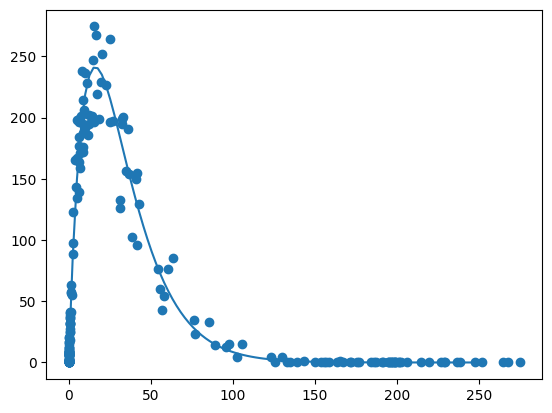

In [6]:
f = RickerFunction()

n = np.linspace(0, 250, 100)
data = make_samples(1, 200, f, f.max_val, noise=0.25)

plt.plot(n, f(n))
plt.scatter(data[:-1], data[1:])

Best regression result:
Spline Transformer with Ridge Regression

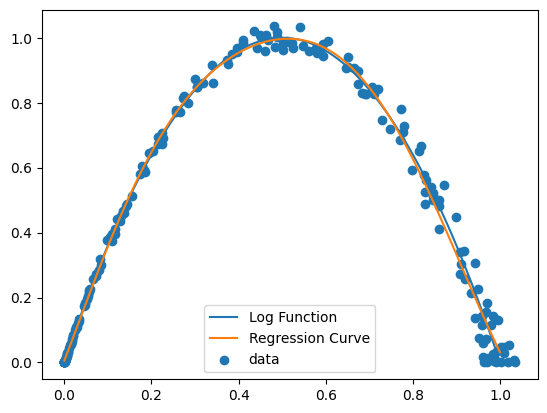

In [7]:
g = LogisticFunction()

# Chaos in the logistic function does not really like noise
log_data = make_samples(1, 200, g, g.max_val, noise=0.05, limit=True)
x = log_data[:-1]
y = log_data[1:]

X_train = x[:, None]
y_train = y[:, None]
model = make_pipeline(SplineTransformer(n_knots=5, degree=10,knots="quantile"), Ridge(alpha=1e-2 ))
model.fit(X_train, y_train)

n = np.linspace(0, 1, 100)
plt.plot(n, g(n), label="Log Function")
plt.plot(n, model.predict(n[:,None]), label="Regression Curve")
plt.scatter(X_train, y_train, label="data")
plt.legend()

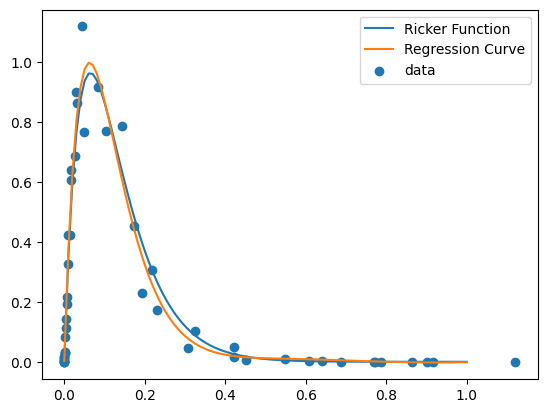

In [8]:
data = make_samples(1, 50, f, f.max_val, noise=0.25)
x = data[:-1] / 250
y = data[1:] / 250

X_train = x[:, None]
y_train = y[:, None]
model = make_pipeline(SplineTransformer(n_knots=5, degree=10,knots="quantile"), Ridge(alpha=1e-2 ))
model.fit(X_train, y_train)

n = np.linspace(0, 1, 100)
plt.plot(n, f(n*250) / 250, label="Ricker Function")
plt.plot(n, model.predict(n[:,None]), label="Regression Curve")

plt.scatter(X_train, y_train, label="data")
plt.legend()

### Graph Construction

### Sampling Based All-in-One Approach



In [9]:
def plot_partition(i, j, min_val, max_val, f=None, e=None, Edge=None, save=False):
  """ Function to visualize the curve walking
  """
  # Area of interest
  if not e is None:
      plt.gca().add_patch(Rectangle((i*e, j*e), e,e, alpha=0.3, color="r"))
  n = np.linspace(min_val, max_val, 200)
  plt.plot(n, f(n), label="Ricker")
  plt.legend()
  plt.xlim(min_val, max_val)
  plt.ylim(min_val, max_val)

  if Edge is None:
      pass
  elif Edge:
      plt.title(f"Partition i={i} and j={j} with edge in G_f")
  else:
      plt.title(f"Partition i={i} and j={j} with no edge in G_f")

  if save:
      filename = f'plot_{i}_{j}.png'
      plt.savefig(filename)
      filenames.append(filename)
      plt.close()

  plt.show()

In [10]:
class GraphConstructor:

    def __init__(self, n_partitions, x=None, y=None, f=None, min_val=None, max_val=None, automatic_padding="None", verbose=False):
        """ Initializes the first adjacency matrix with the first datapoints
        Args:
          x: Array containing the x value of the datapoints
          y: Array containing the y value of the datapoints
          n_partitions: Number of equally spaces partitions beween min and max
          min: Minimal partition edge
          max: Maximal partition edge
          automatic_padding: ["max"]Add more rows and collumns in case new data exceeds the current min/max edges
        """
        self.N = n_partitions
        self.verbose = verbose

        # Initialize cumulated adjacency matrix and node edge counter
        self.CA = dok((n_partitions, n_partitions), dtype=int) # Using Sparse Matrix format
        # Regression Matrix, gets initialized as dok
        self.RM = None
        # Transition values, gets initialized as dok
        self.TVals = None
        self.G = None
        self.slope = None
        self.edge_cntr = np.zeros(n_partitions)

        # Convert parameter to bool
        if automatic_padding == "max":
          self.max_padding = True
        else:
          self.max_padding = False

        # Preset in case not specified
        self.x = np.array([])
        self.y = np.array([])
        self.function = None

        # if function is specified
        if not f is None:
            self.function = f
            # gets overritten if x and y are specified
            self.min = min_val
            self.max = max_val

            # Set partition size
            self.e = (self.max - self.min) / self.N

        if not(x is None or y is None):
            # Set min and max values
            if min_val is None:
                self.min = min(min(x), min(y)) - 1e-10
            else:
                self.min = min_val

            if max_val is None:
                self.max = max(max(x), max(y)) + 1e-10
            else:
                self.max = max_val

            self.x = x
            self.y = y

            # Set partition size
            self.e = (self.max - self.min) / self.N

            # Fill first matrix
            self.update(x, y)


    def _Af(self, i,j):
        """ Tests whether there is an edge between two nodes using a function
        Args:
          i: node 1 (N_t) (X)
          j: node 2 (N_t+1) (Y)
        """
        f_i0 = self._f(i*self.e)
        f_i1 = self._f((i+1)*self.e)

        # In the partition when f is increasing between j*e and (j+1)*e
        if (f_i0 <= f_i1 and f_i0 <=(j+1)*self.e and f_i1 > j*self.e):
            return 1
        # In the partition when f is decreasing between (j+1)*e and j*e
        if (f_i0 >= f_i1 and f_i0 >=j*self.e and f_i1 < (j+1)*self.e):
            return 1

        return 0


    def _splineReg(self, x, y, n_knots=5, degree=10, alpha=1e-2, **kwargs):
        """ Fits a spline regression
        Args:
          x, y: as in __init__
          degree: degree of the regression
        """
        self.model = make_pipeline(SplineTransformer(n_knots=n_knots, degree=degree, knots="quantile"), Ridge(alpha=alpha))
        self.model.fit(self._arrayNorm(x), self._arrayNorm(y))

    def _f(self, x):
        """ Performs the regression with data transformation for the first construction.
        Args:
          x: Single Value

        Returns:
          Prediction from the model for x unnormalized. Values stay between self.min and self.max
        """
        if self.function is None:
            return np.clip(self._renorm(self.model.predict(self._norm(x))), self.min, self.max)
        else:
            return self.function(x)

    def f(self, x, clip=True):
        if self.function is None:
            if clip:
                return np.clip(self._renorm(self.model.predict(self._arrayNorm(x))), self.min, self.max)
            return self._renorm(self.model.predict(self._arrayNorm(x)))
        else:
            return self.function(x)

    def _arrayNorm(self, vals):
        """ Normalizes an Array for the regression
        Args:
          vals: Numpy array

        Returns:
          Normalized vals array with the shape (len(vals), 1)
        """
        return np.reshape((vals - self.min) / (self.max - self.min), (len(vals), 1))

    def _norm(self, val):
        """ Normalizes a single value for the construction
        Args:
          val: Single Numeric value

        Returns:
          Normalized value as an two dimensional array with a single element
        """
        return np.reshape((val - self.min) / (self.max - self.min), (1, 1))

    def _renorm(self, val):
        """ Transforms normalized values b
        Args:
          val: Either array or single element
        """
        return np.squeeze(val * (self.max - self.min) + self.min)


    def _construct(self, probs_r=-1, **kwargs):
        """ Constructs an adjacency matrix by following a given curve
        Args:
          probs_r: [-1, 0<=] Range of the neighborhood to take into account for
                   calculating the probabilies or use no probabilies (-1)
          **kwargs: Arguments for the spline regression
        """

        # Separate Matrix for regression
        self.RM = dok((self.N, self.N), dtype=float)

        # Create regression curve for traversion if no function is specified
        if self.function is None:
            self._splineReg(self.x, self.y, kwargs=kwargs)

        # Initialize wandering
        col = int(self.min // self.e)
        row = int(self._f(self.min) // self.e)
        if probs_r >= 0:
          self.RM[row, col] = self._get_probs_vicinity(row, col, probs_r)
        else:
          self.RM[row, col] = 1

        # Save previous column
        prev_row = 0
        # Stores wheter graph is rising of falling
        sign_slope = 1
        self.slope = np.zeros(self.N)

        while True:
            # Go up
            if (prev_row != row + 1) & (row + 1 < self.N) & self._Af(col, row + 1):
                prev_row = row
                row += 1
                # Graph has positive slope
                sign_slope = 0

            # Go down
            elif (prev_row != row - 1) & (row > 0) & self._Af(col, row - 1):
                prev_row = row
                row -= 1
                # Graph has negative slope
                sign_slope = 1

            # Go right
            elif (col + 1 < self.N) & self._Af(col + 1, row):
                # save the slope for the current row
                self.slope[col] = sign_slope
                prev_row = row
                col += 1

            # In Case the function is not continous
            else:
                break

            # Set value in matrix
            if probs_r >= 0:
                self.RM[col, row] = self._get_probs_vicinity(row, col, probs_r)
            else:
                self.RM[col, row] = 1

            if self.verbose:
                plot_partition(col, row, self.min, self.max, self.f, self.e, 1)

    def _get_probs_vicinity(self, row, col, r=1):
        """Calculates the empirical probabilities of reaching a point in the vicinity of the actual point
        Args:
          row: N_t
          col: N_t+1
          r: What value range in the neighborhood is taken into account for
        """
        # Calculate how many neighbors are in the specific range
        r_ind = int(r // self.e)

        # Sum up the values in the specified vicinity
        vic_cnt = self.CA[[row],np.arange(max(0,col-r_ind), min(col+1+r_ind, self.N-1))].sum()

        if vic_cnt != 0:
            # Calculate probability
            return vic_cnt / self.edge_cntr[row]

        # If no values in vicinity nothing can be derived, thus prob is 1
        return 1


    def _updateSingle(self, x, y):
        """ Function that uptates the cumulated adjacency matrix with one x-y-pair
        Args:
          x: Single Value
          y: Single Value
        """

        # Forces lower bounds
        x = max(self.min, x)
        y = max(self.min, y)

        # Tests if the values exceed the maximal matrix boundaries
        # Pads the matrix if wanted, otherwise limit inputs
        if ((self.max < x ) or (self.max < y)):
            if self.max_padding:
                max_val = max(x,y)
                pad = int((max_val - self.min) // self.e + 1)
                self.CA.resize((pad, pad))
                self.edge_cntr.resize(pad)
                self.N = pad
                self.max = max_val + 1e-10
            else:
                x = min(self.max-1e-10, x)
                y = min(self.max-1e-10, y)

        # Get Row and Column
        row = int((x - self.min) // self.e)
        col = int((y - self.min) // self.e)

        # Incremenet partition
        self.CA[row, col] += 1
        # Increment node edge counter
        self.edge_cntr[row] += 1


    def update(self, x, y):
        """ Update the cumulated adjacency matrix with new edges for each x-y-pair
        Args:
          x: Single Value or array containing new x values
          y: Single Value or array containing new y values
          update_RM: Whether to also update the entries of the regression matrix if it
                     was already created

        Returns:
          A: The cumulated adjacency matrix
        """

        # If inputs are single numbers
        if isinstance(x, numbers.Number):
            self._updateSingle(x, y)

            # Add the samples to the the data
            self.x = np.concatenate([self.x, [x]])
            self.y = np.concatenate([self.y, [y]])
            return self.CA.copy()

        # If inputs are arrays
        x = x.squeeze()
        y = y.squeeze()

        # iterate over each x-y-pair
        for i in range(len(x)):

            self._updateSingle(x[i], y[i])

        self.x = np.concatenate([self.x, x])
        self.y = np.concatenate([self.y, y])
        return self.CA.copy()


    def get_node(self, y):
        """ Returns the node number for a given value
        Args:
          y: Value for which to get the node number
        """
        y_node = (np.clip(y, self.min, self.max-1e-4) - self.min) // self.e

        if isinstance(y_node, np.ndarray):
            return y_node.astype(int)
        else:
            return int(y_node)


    def get_cumulated_adjacency(self, density=True):
        """ Returns the adajacency matrix retrieved from the samples
        Args:
          density: Whether to return desities or absolut counts
        """

        if density:
            return (self.CA.T / np.where(self.edge_cntr != 0, self.edge_cntr, 1)).T.copy()
        else:
            return self.CA.copy()


    def get_regression_matrix(self, probs_r=-1, force_new=False, **kwargs):
        """ Returns the regression matrix
        Args:
          probs_r: [-1, 0<=] Range of the neighborhood to take into account for
                   calculating the probabilies or use no probabilies (-1)
          force_new: Whether to calculate the regression anew even though it already exists
        """

        if self.RM is None or force_new:
            self._construct(probs_r=probs_r, kwargs=kwargs)

        return self.RM.copy()


    def set_f(self, function=None):
        """ Set a function that will than be used in the construction or set no function. Than the interpolation is used
        Args:
          function: Callable function that fits the data
        """
        if callable(function) or function is None:
            self.function = function


    def create_graph(self, probs_r=-1, force_new=False, **kwargs):
        """ Creates Graph and saves it in the object
        Args:
          probs_r: [-1, 0<=] Range of the neighborhood to take into account for
                   calculating the probabilies or use no probabilies (-1)
          force_new: Whether to calculate the regression anew even though it already exists
        """

        if self.G is None or force_new:
            # If regression matrix has not been created jet
            if self.RM is None or force_new:
                self._construct(probs_r=probs_r, kwargs=kwargs)

            # Create Graph from regression Matrix
            self.G = nx.DiGraph(self.RM.toarray())

        return self.G


    def node_inverse(self, s_node, t_node):
        """ Approximates value in s_node to reach t_node based on the interpolation f
        Args:
          s_node: Starting node
          t_node: Target node

        Returns:
          trans_val: Value in s_node which transitions to t_node in the next step
        """

        self.create_graph()

        i = 0
        m = 1

        min_node = min(self.G[s_node])
        # slope as 0 and 1
        slope1 = self.slope[s_node]
        # slope as 1 and -1
        slope2 = slope1 * 2 - 1

        outDeg = self.G.out_degree(s_node)

        linear_partition = (abs(slope1 * (outDeg - 1) - t_node + min_node) + 0.5) / outDeg

        trans_val = (s_node + linear_partition) * self.e

        # Check the target node with the regression
        f_val = self.f(np.array([trans_val]))
        f_node = self.get_node(f_val)


        # adapt until the next predicted node is the target node
        while f_node != t_node:

            trans_val -= (t_node - f_node ) * slope2 * m * self.e / outDeg

            f_val = self.f(np.array([trans_val]))
            f_node = self.get_node(f_val)



            # half the step size
            m /= 2
            i += 1

            if i == 5:
                break

        return trans_val

In [11]:
data = make_samples(1, 1000, f, f.max_val, noise=0.25)
gConst= GraphConstructor(20, x=data[:-1], y=data[1:], min_val=0, max_val=250, automatic_padding="max", verbose=False)
rm = gConst.get_regression_matrix(-1, force_new=True)
G = gConst.create_graph()

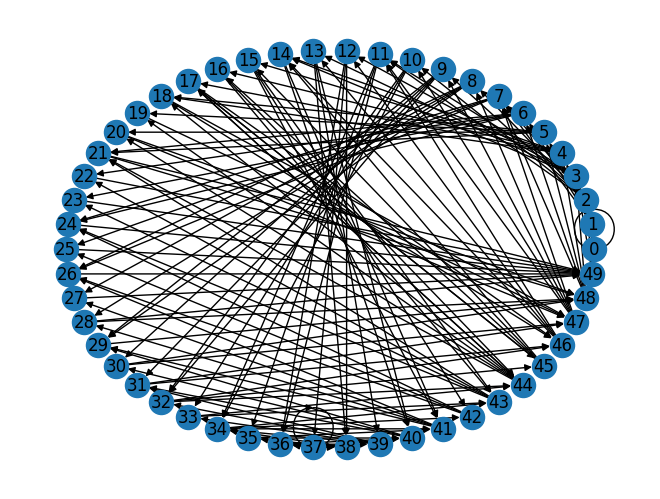

In [12]:
gConst= GraphConstructor(50, f=g, min_val=0, max_val=1, automatic_padding="max", verbose=False)
rm = gConst.get_regression_matrix(-1, force_new=True)
G = gConst.create_graph()
nx.draw(G, pos=nx.circular_layout(G), with_labels=True)

#### Graph and plot together

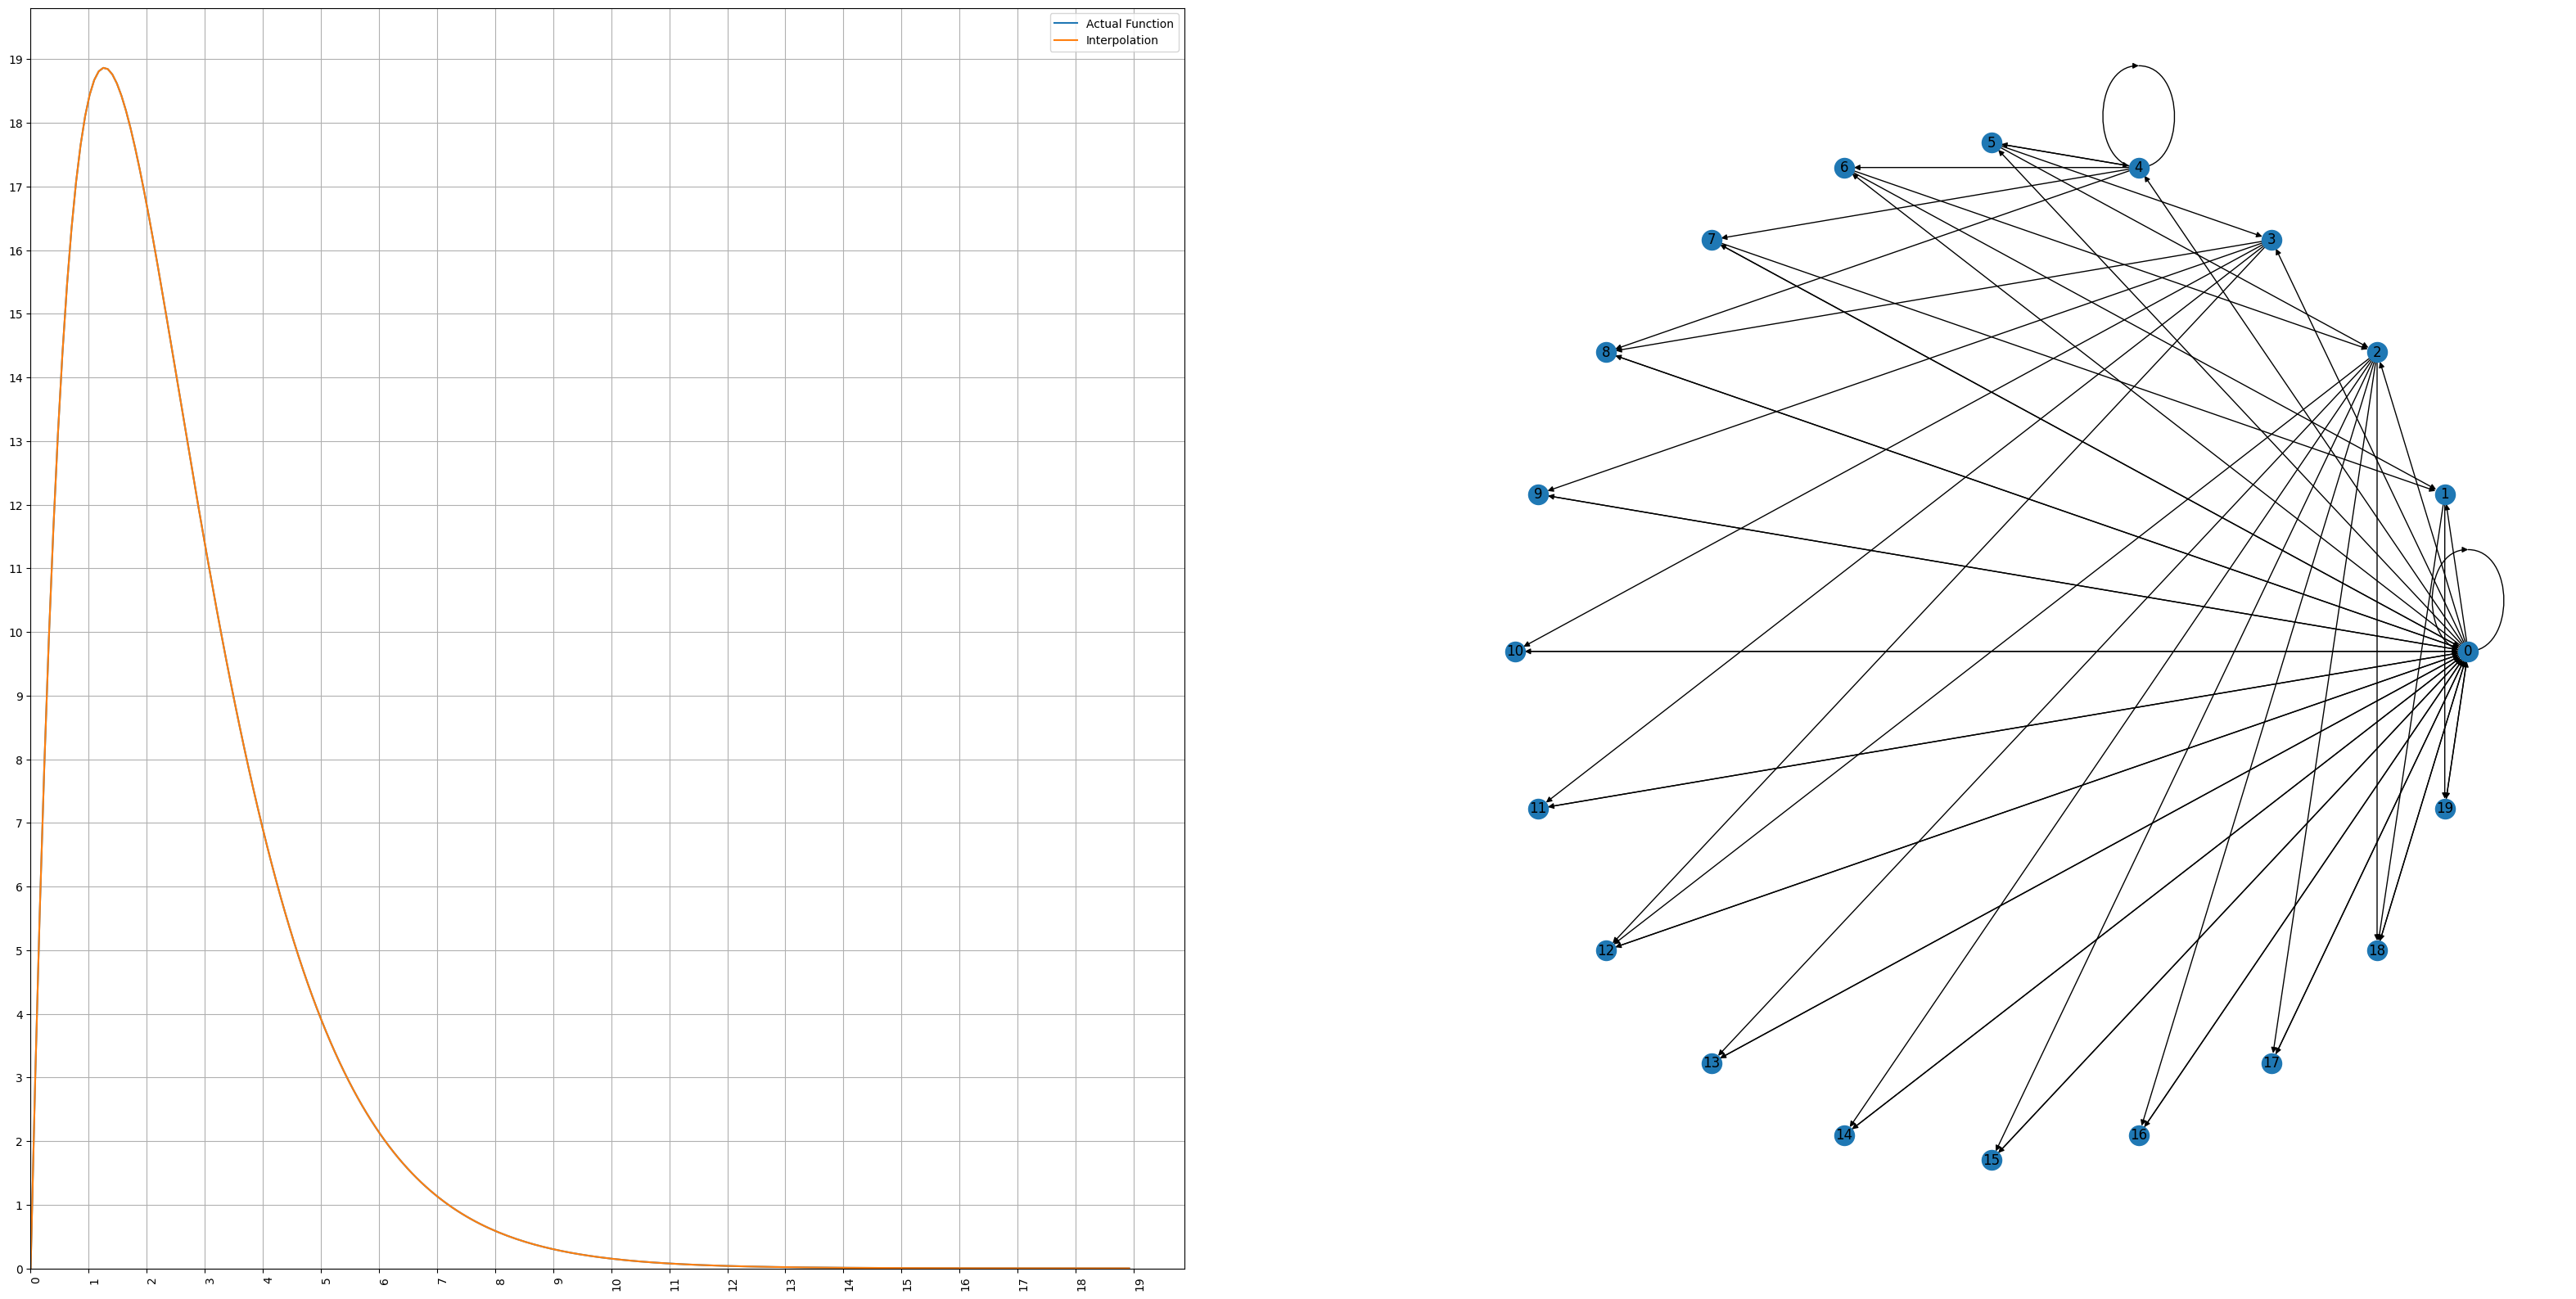

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))

# Show Plot of Regression
n = np.linspace(0, gConst.max, gConst.N)
ax1.set_xticks(n, np.arange(gConst.N), horizontalalignment="left", rotation=90)
ax1.set_yticks(n, np.arange(gConst.N))
ax1.grid()
ax1.plot(np.arange(243), f(np.arange(243)), label="Actual Function")
ax1.plot(np.arange(243), gConst.f(np.arange(243)), label="Interpolation")

ax1.legend()
ax1.set_xlim(0)
ax1.set_ylim(0)

# Draw Graph
nx.draw(G, pos=nx.circular_layout(G), ax=ax2, with_labels=True)

#### Comparison

In [ ]:
import time, timeit

In [ ]:
def Af(f,i,j,e):
        """ Tests whether there is an edge between two nodes using a function
        Args:
          i: node 1 (N_t) (X)
          j: node 2 (N_t+1) (Y)
        """
        f_i0 = f(i*e)
        f_i1 = f((i+1)*e)

        # In the partition when f is increasing between j*e and (j+1)*e
        if (f_i0 <= f_i1 and f_i0 <=(j+1)*e and f_i1 > j*e):
            return 1
        # In the partition when f is decreasing between (j+1)*e and j*e
        if (f_i0 >= f_i1 and f_i0 > j*e and f_i1 <=(j+1)*e):
            return 1

        return 0

##### Naive

In [ ]:
def naive_construction(f, N, min_val, max_val):

    e = (max_val - min_val) / N
    adj = dok((N, N), bool)
    cnt = 0

    for i in range(N):
        for j in range(N):
            cnt += 1
            if Af(f, i, j, e):
                adj[i, j] = True

    return adj, cnt

##### Naive + Pruning

In [ ]:
def pruning_construction(f, N, min_val, max_val):

    e = (max_val - min_val) / N
    adj = dok((N, N), bool)
    cnt = 0

    for i in range(N):
        flag = False
        for j in range(N):
            cnt += 1
            if Af(f, i, j, e):
                adj[i, j] = True
                flag = True

            elif flag:
                break

    return adj, cnt

##### Graph walking (bare)

In [ ]:
def walking_construction(f, N, min_val, max_val):

    e = (max_val - min_val) / N
    adj = dok((N, N), bool)
    cnt = 0

    i = 0
    j = 0
    adj[i, j] = True

    prev_i = 0

    while True:

        if (prev_i != i + 1) & (i + 1 < N) & Af(f, j, i + 1, e):
            prev_i = i
            i += 1
            cnt += 1

        elif (prev_i != i - 1) & (i > 0) & Af(f, j, i - 1, e):
            prev_i = i
            i -= 1
            cnt += 1

        elif (j + 1 < N) & Af(f, j + 1, i, e):
            prev_i = i
            j += 1
            cnt += 2

        else:
            cnt += 3
            break

        adj[j, i] = True

    return adj, cnt


##### Runntimes Ricker function

In [ ]:
Ns = [20, 50, 100, 1000, 2000, 3000, 4000, 5000]
ts = np.zeros((3, len(Ns)))
cnts = np.zeros((3, len(Ns)))
adjs_naive = {}
adjs_prune = {}
adjs_walk = {}

for i, N in enumerate(Ns):
  start = time.time()
  adjs_naive[N], cnts[0, i] = naive_construction(f, N, 0, 242)
  end = time.time()
  ts[0,i] = end - start

  start = time.time()
  adjs_prune[N], cnts[1, i] = pruning_construction(f, N, 0, 242)
  end = time.time()
  ts[1,i] = end - start

  start = time.time()
  adjs_walk[N], cnts[2, i] = walking_construction(f, N, 0, 242)
  end = time.time()
  ts[2,i] = end - start

Text(4075, 8000000.0, '25,000,000')

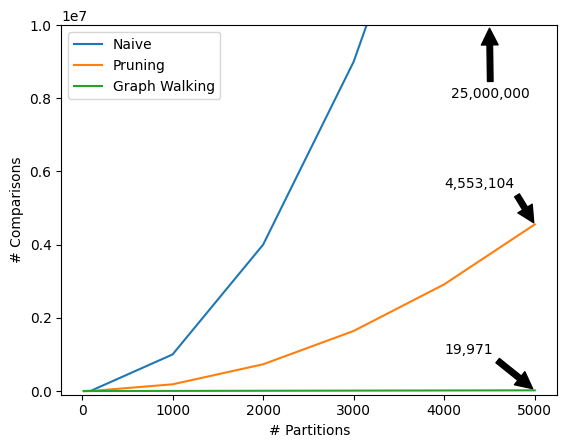

In [ ]:
plt.plot(Ns, cnts.T, label=["Naive", "Pruning", "Graph Walking"])
plt.ylim(-1e5,1e7)
plt.legend(loc="upper left")
plt.ylabel("# Comparisons")
plt.xlabel("# Partitions")
plt.annotate(f"{int(cnts[2,-1]):,}", xy=(Ns[-1], cnts[2,-1]), xytext=(Ns[-1] - 1000, cnts[2,-1] + 1e6),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.annotate(f"{int(cnts[1,-1]):,}", xy=(Ns[-1], cnts[1,-1]), xytext=(Ns[-1] - 1000, cnts[1,-1] + 1e6),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.annotate(f"{int(cnts[0,-1]):,}", xy=(Ns[-1] - 500, 1e7), xytext=(Ns[-1] - 925, 1e7 - 2e6),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

Text(4000, 93.38321614265442, '93.8832')

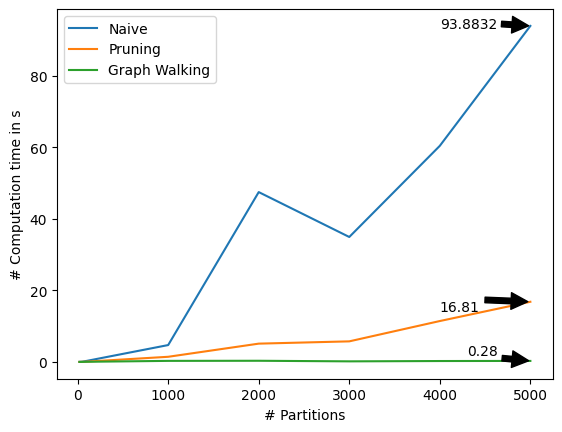

In [ ]:
plt.plot(Ns, ts.T, label=["Naive", "Pruning", "Graph Walking"])

plt.legend(loc="upper left")
plt.ylabel("# Computation time in s")
plt.xlabel("# Partitions")
plt.annotate(f"{ts[2,-1]:.2f}", xy=(Ns[-1], ts[2,-1]), xytext=(Ns[-1]-700, 2),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.annotate(f"{ts[1,-1]:.2f}", xy=(Ns[-1], ts[1,-1]), xytext=(Ns[-1]-1000, ts[1,-1]-2.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.annotate(f"{ts[0,-1]:.4f}", xy=(Ns[-1], ts[0,-1]), xytext=(Ns[-1]-1000, ts[0,-1]-0.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

In [ ]:
if (~(adjs_naive[20] != adjs_prune[20]).toarray()).all() and (~(adjs_naive[20] != adjs_walk[20]).toarray()).all():
    print("The three adjacency matrices are the same")

The three adjacency matrices are the same


##### Runtimes logistic function

In [ ]:
Ns = [20, 50, 100, 1000, 2000, 3000, 4000, 5000]
ts = np.zeros((3, len(Ns)))
cnts = np.zeros((3, len(Ns)))
adjs_naive = {}
adjs_prune = {}
adjs_walk = {}

for i, N in enumerate(Ns):
  start = time.time()
  adjs_naive[N], cnts[0, i] = naive_construction(g, N, 0, 1)
  end = time.time()
  ts[0,i] = end - start

  start = time.time()
  adjs_prune[N], cnts[1, i] = pruning_construction(g, N, 0, 1)
  end = time.time()
  ts[1,i] = end - start

  start = time.time()
  adjs_walk[N], cnts[2, i] = walking_construction(g, N, 0, 1)
  end = time.time()
  ts[2,i] = end - start

Text(4075, 8000000.0, '25,000,000 &\n   16,679,051')

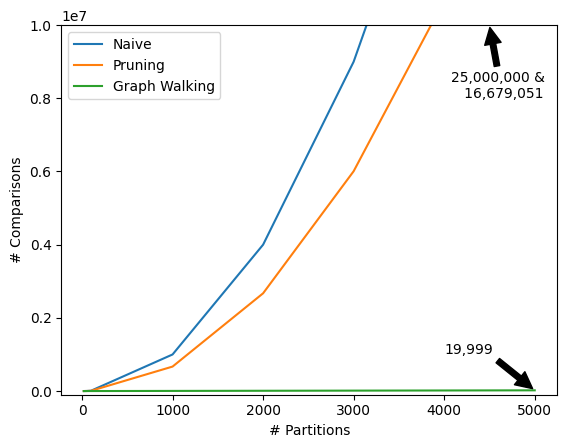

In [ ]:
plt.plot(Ns, cnts.T, label=["Naive", "Pruning", "Graph Walking"])
plt.ylim(-1e5,1e7)
plt.legend(loc="upper left")
plt.ylabel("# Comparisons")
plt.xlabel("# Partitions")
plt.annotate(f"{int(cnts[2,-1]):,}", xy=(Ns[-1], cnts[2,-1]), xytext=(Ns[-1] - 1000, cnts[2,-1] + 1e6),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.annotate(f"{int(cnts[0,-1]):,} &\n   {int(cnts[1,-1]):,}", xy=(Ns[-1] - 500, 1e7), xytext=(Ns[-1] - 925, 1e7 - 2e6),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

In [ ]:
if (~(adjs_naive[5000] != adjs_prune[5000]).toarray()).all() and (~(adjs_naive[5000] != adjs_walk[5000]).toarray()).all():
    print("The three adjacency matrices are the same.")

The three adjacency matrices are the same.


##### Comparison & runtime curve walking

In [ ]:
Ns = np.linspace(20, 20000, 100, dtype=int)
ts = np.zeros(100)
cnts = np.zeros(100)

for i, N in enumerate(Ns):
    start = time.time()
    _, cnts[i] = walking_construction(f, N, 0, 242)
    end = time.time()
    ts[i] = end - start

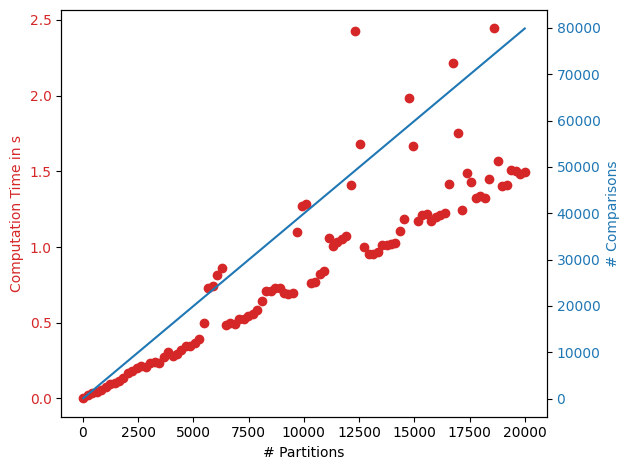

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('# Partitions')
ax1.set_ylabel('Computation Time in s', color=color)
ax1.scatter(Ns, ts, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('# Comparisons', color=color)  # we already handled the x-label with ax1
ax2.plot(Ns, cnts, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


#### Intervention Functions

In [31]:
class Interventor:

    def __init__(self, GraphConst, target_val, max_intervention=np.inf, verbose=False):
        """ Initializes the attributes, tests requirements and prepares intervention
        Args:
          GraphConst: GraphConstructor object were intervention is wanted
          source_val: Start value before the intervention
          target_val: Target value which is supposed to be reached after the interventions
          max_intervention: Maximal absolut intervention, must be bigger or equal to GraphConst.e
          inv_cost_func: Function that assignes costs to interventions, suggested is exponential function
        """

        # Initialize
        self.gCon = GraphConst
        self.t = target_val
        self.verbose = verbose
        if max_intervention < self.gCon.e:
            print(f"Warning: Maximal intervention smaller than e!\nMaximal Intervention has been set to e = {GraphConst.e}.")
            self.max_int = self.gCon.e
        else:
            self.max_int = max_intervention

        # Get target node
        self.t_node = GraphConst.get_node(target_val)

        # Reverse the graphs edges to find paths towards the target node
        if GraphConst.G is None:
            self.G_rev = GraphConst.create_graph().reverse()
        else:
            self.G_rev = GraphConst.G.reverse()

        # Calculate all paths towards the target node
        # This reduces computation costs as the changes to the
        # planned path only need a lookup in the dictionary
        # Also, paths are already reversed
        self.node_paths = nx.single_source_dijkstra_path(self.G_rev, self.t_node, weight="None")

        # If there is only one path in the reverse path that means that it has no incomming
        # edges in the actual graph and is therefore not reachable
        if len(self.node_paths) == 1:
            print("Target value not reachable!")

        # Save taken paths and values
        self.nodes = []
        self.values = []
        self.interventions = []
        self.target_step = []

        # flag if target has been reached
        self.reached = False

        # step counter
        self.steps = 0

    def intervention(self, x):
        """ Calculates intervention for one step based on the given value which
            is expected to be the next value from the current node

        """

        int_val = 0

        # increase step number
        self.steps += 1

        self.current_node = self.gCon.get_node(x)
        print("Current node: ", self.current_node)

        # if target is near by
        if not self.reached and self.current_node == self.t_node:
            int_val = self.t - x
            self.reached = True
            self.target_step.append((self.steps, self.t))

            # Save values to past path
            self.nodes.append(self.current_node)
            self.nodes.append(self.current_node)
            self.values.append(x)
            self.values.append(self.t)
            self.interventions.append(int_val)
            self.interventions.append(0.0)
            print(f"Target reached using {self.steps} steps")
            self.steps = 1
            return int_val, True

        # if the target has been reached and x is near a value we already had, intervene
        # to the already known value and from there on in the known way
        if self.reached and self.current_node in self.nodes:

            # if value has been reached before
            if x in self.values:
                # use known intervention
                idx = self.values.index(x)
                print("Using previous path.")
                return self.interventions[idx], False

            print("Node already visited")
            idx = self.nodes.index(self.current_node)
            int_val = self.values[idx] + self.interventions[idx] - x

            # Save values to past path
            self.nodes.append(self.current_node)
            self.values.append(x)
            self.interventions.append(int_val)

            return int_val, False


        # Save values to past path
        self.nodes.append(self.current_node)
        self.values.append(x)

        # Include neighbors
        min_node = min(self.current_node, self.gCon.get_node(x - self.max_int) + 1)
        max_node = max(self.current_node, self.gCon.get_node(x + self.max_int) - 1)

        # fing neighbor with shortest path to target node
        nbrs = np.arange(min_node, max_node + 1)
        path_lengths = list(map(lambda nbr: len(self.node_paths[nbr]), nbrs))

        # Use neighbor node only if path length is shorter
        if min(path_lengths) < len(self.node_paths[self.current_node]):
            best_node = nbrs[np.argmin(path_lengths)]

            # intervention to go to the lower boundary of the best node
            int_val = best_node * self.gCon.e - x
            print("Best node: ", best_node)
            # use the best node to calculate further intervention
            self.current_node = best_node
            # the lower boundary is now the new x
            x += int_val

            # Check again if new new current node is target node
            if self.current_node == self.t_node:
                int_val += self.t - x
                # Add intervention from original node
                self.interventions.append(int_val)

                # Add intervention from new node
                self.nodes.append(self.current_node)
                self.values.append(x)
                self.interventions.append(self.t-x)

                print(f"Target reached using {self.steps} steps")
                self.reached=True
                self.target_step.append((self.steps, self.t))
                self.steps = 1
                return int_val, True

        # Get next node in the path
        self.next_node = self.node_paths[self.current_node][-2]
        print("Shortest Path: ", self.node_paths[self.current_node])
        print(f"Expected Path Length: {len(self.node_paths[self.current_node])}")

        # Get number of successors of previous node
        outDeg = self.gCon.G.out_degree(self.current_node)

        # if the node has only one successor, set value to middle value of node
        if outDeg == 1:
            next_val = (self.current_node + 0.5) * self.gCon.e

        # Calculate the inverse of the node
        else:
            next_val = self._precise_approx(x, outDeg)


        # Intervention is the calculated value to reach the next node minus the current value
        int_val +=  next_val - x

        self.interventions.append(int_val)
        return int_val, False


    def _precise_approx(self, x, outDeg):
        """ Approximates inverse value more accurately
        Args:
          x: Current value
          outDeg: Outgoing degree of current node
        """
        i = 0
        m = 1

        min_node = min(self.gCon.G[self.current_node])
        # slope as 0 and 1
        slope1 = self.gCon.slope[self.current_node]
        # slope as 1 and -1
        slope2 = slope1 * 2 - 1

        linear_partition = (abs(slope1 * (outDeg - 1) - self.next_node + min_node) + 0.5) / outDeg

        next_val = (self.current_node + linear_partition) * self.gCon.e

        # Check the target node with the regression
        f_val = self.gCon.f(np.array([next_val]))
        f_node = self.gCon.get_node(f_val)


        # adapt until the next predicted node is the target node
        while f_node != self.next_node:

            next_val -= (self.next_node - f_node ) * slope2 * m * self.gCon.e / outDeg

            f_val = self.gCon.f(np.array([next_val]))
            f_node = self.gCon.get_node(f_val)

            # half the step size
            m /= 2
            i += 1

            if i == 5:
                break

        return next_val


    def update_target(self, t):
        """ Sets a new target
        Args:
          t: New value to reach with interventions
        """


        self.t = np.clip(t, gConst.min, gConst.max)

        # Get target node
        t_node = self.gCon.get_node(t)

        # Calculate new paths if necessary
        if t_node != self.t_node:
            self.t_node = t_node
            self.node_paths = nx.single_source_dijkstra_path(self.G_rev, self.t_node, weight="None")

            # If there is only one path in the reverse path that means that it has no incomming
            # edges in the actual graph and is therefore not reachable
            if len(self.node_paths) == 1:
                print("Target value not reachable!")

            else:
                self.values = []
                self.interventions = []
                self.nodes = []
                self.reached = False
                self.steps = 0

        else:
            self.reached = False
            self.steps = 0

        print(f"New target value {self.t} in node {self.t_node}")


In [13]:
class Interventor:

    def __init__(self, GraphConst, target_val, max_intervention=np.inf, verbose=False):
        """ Initializes the attributes, tests requirements and prepares intervention
        Args:
          GraphConst: GraphConstructor object were intervention is wanted
          source_val: Start value before the intervention
          target_val: Target value which is supposed to be reached after the interventions
          max_intervention: Maximal absolut intervention, must be bigger or equal to GraphConst.e
          inv_cost_func: Function that assignes costs to interventions, suggested is exponential function
        """

        # Initialize
        self.gCon = GraphConst
        self.t = target_val
        self.verbose = verbose
        if max_intervention < self.gCon.e:
            print(f"Warning: Maximal intervention smaller than e!\nMaximal Intervention has been set to e = {GraphConst.e}.")
            self.max_int = self.gCon.e
        else:
            self.max_int = max_intervention

        # Get target node
        self.t_node = GraphConst.get_node(target_val)

        # Reverse the graphs edges to find paths towards the target node
        if GraphConst.G is None:
            self.G_rev = GraphConst.create_graph().reverse()
        else:
            self.G_rev = GraphConst.G.reverse()

        # Calculate all paths towards the target node
        # This reduces computation costs as the changes to the
        # planned path only need a lookup in the dictionary
        # Also, paths are already reversed
        self.node_paths = nx.single_source_dijkstra_path(self.G_rev, self.t_node, weight="None")

        # If there is only one path in the reverse path that means that it has no incomming
        # edges in the actual graph and is therefore not reachable
        if len(self.node_paths) == 1:
            print("Target value not reachable!")

        # Save taken paths and values
        self.nodes = []
        self.values = []
        self.interventions = []
        self.target_step = []

        # flag if target has been reached
        self.reached = False

        # step counter
        self.steps = 0

    def intervention(self, x):
        """ Calculates intervention for one step based on the given value which
            is expected to be the next value from the current node

        """

        int_val = 0

        # increase step number
        self.steps += 1

        self.current_node = self.gCon.get_node(x)
        print("Current node: ", self.current_node)

        # if target is near by
        if  self.current_node == self.t_node:
            int_val = self.t - x
            self.reached = True
            self.target_step.append((self.steps, self.t))

            # Save values to past path
            self.nodes.append(self.current_node)
            self.nodes.append(self.current_node)
            self.values.append(x)
            self.values.append(self.t)
            self.interventions.append(int_val)
            self.interventions.append(0.0)
            print(f"Target reached using {self.steps} steps")
            self.steps = 1
            return int_val, True

        # Save values to past path
        self.nodes.append(self.current_node)
        self.values.append(x)

        # Include neighbors
        min_node = min(self.current_node, self.gCon.get_node(x - self.max_int) + 1)
        max_node = max(self.current_node, self.gCon.get_node(x + self.max_int) - 1)

        # fing neighbor with shortest path to target node
        nbrs = np.arange(min_node, max_node + 1)
        path_lengths = list(map(lambda nbr: len(self.node_paths[nbr]), nbrs))

        # Use neighbor node only if path length is shorter
        if min(path_lengths) < len(self.node_paths[self.current_node]):
            best_node = nbrs[np.argmin(path_lengths)]

            # intervention to go to the lower boundary of the best node
            int_val = best_node * self.gCon.e - x
            print("Best node: ", best_node)
            # use the best node to calculate further intervention
            self.current_node = best_node
            # the lower boundary is now the new x
            x += int_val

            # Check again if new new current node is target node
            if self.current_node == self.t_node:
                int_val += self.t - x
                # Add intervention from original node
                self.interventions.append(int_val)

                print(f"Target reached using {self.steps} steps")
                self.reached=True
                self.target_step.append((self.steps, self.t))
                self.steps = 1
                return int_val, True

        # Get next node in the path
        self.next_node = self.node_paths[self.current_node][-2]
        print("Shortest Path: ", self.node_paths[self.current_node])
        print(f"Expected Path Length: {len(self.node_paths[self.current_node])}")

        # Get number of successors of previous node
        outDeg = self.gCon.G.out_degree(self.current_node)

        # if the node has only one successor, set value to middle value of node
        if outDeg == 1:
            next_val = (self.current_node + 0.5) * self.gCon.e

        # Calculate the inverse of the node
        else:
            next_val = self.gCon.node_inverse(self.current_node, self.next_node)


        # Intervention is the calculated value to reach the next node minus the current value
        int_val +=  next_val - x

        self.interventions.append(int_val)
        return int_val, False


    def update_target(self, t):
        """ Sets a new target
        Args:
          t: New value to reach with interventions
        """

        # Remove steps where the target has been reached
        # to prevent getting stuck
        # idx = self.nodes.index(self.t_node)
        # del self.values[idx]
        # del self.nodes[idx]
        # del self.interventions[idx]
        # print("nodes deleted")

        self.t = np.clip(t, gConst.min, gConst.max)

        # Get target node
        t_node = self.gCon.get_node(t)

        # Calculate new paths if necessary

        if t_node != self.t_node:
            self.t_node = t_node
            self.node_paths = nx.single_source_dijkstra_path(self.G_rev, self.t_node, weight="None")

            # If there is only one path in the reverse path that means that it has no incomming
            # edges in the actual graph and is therefore not reachable
            if len(self.node_paths) == 1:
                print("Target value not reachable!")

            else:
                self.values = []
                self.interventions = []
                self.nodes = []
                self.reached = False
                self.steps = 0

        else:
            self.reached = False
            self.steps = 0

        print(f"New target value {self.t} in node {self.t_node}")


#### Tests

##### Test 1

In [ ]:
data = make_samples(1, 1000, f, f.max_val, noise=0.25)
gConst= GraphConstructor(200, x=data[:-1], y=data[1:], min_val=0, max_val=250, automatic_padding="max", verbose=False)
rm = gConst.get_regression_matrix(-1, force_new=True)
G = gConst.create_graph()

In [ ]:
t = 0
max_int = 15
testInt = Interventor(gConst, t, max_int)

all_vals = []

In [ ]:
x = 29
for i in range(20):
    int_val, _ = testInt.intervention(x)
    print("Intervention: ", int_val)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Next value: ", x)
    print("")

Current node:  23
Shortest Path:  [0, 150, 23]
Expected Path Length: 3
Intervention:  1.0892857142857117
Next value:  190.31168960659477

Current node:  152
Shortest Path:  [0, 152]
Expected Path Length: 2
Intervention:  0.3133103934052315
Next value:  0.06051281089857274

Current node:  0
Target reached using 3 steps
Intervention:  -0.06051281089857274
Next value:  0.0

Current node:  0
Using previous path.
Intervention:  0.0
Next value:  0.0

Current node:  0
Using previous path.
Intervention:  0.0
Next value:  0.0

Current node:  0
Using previous path.
Intervention:  0.0
Next value:  0.0

Current node:  0
Using previous path.
Intervention:  0.0
Next value:  0.0

Current node:  0
Using previous path.
Intervention:  0.0
Next value:  0.0

Current node:  0
Using previous path.
Intervention:  0.0
Next value:  0.0

Current node:  0
Using previous path.
Intervention:  0.0
Next value:  0.0

Current node:  0
Using previous path.
Intervention:  0.0
Next value:  0.0

Current node:  0
Using pre

''

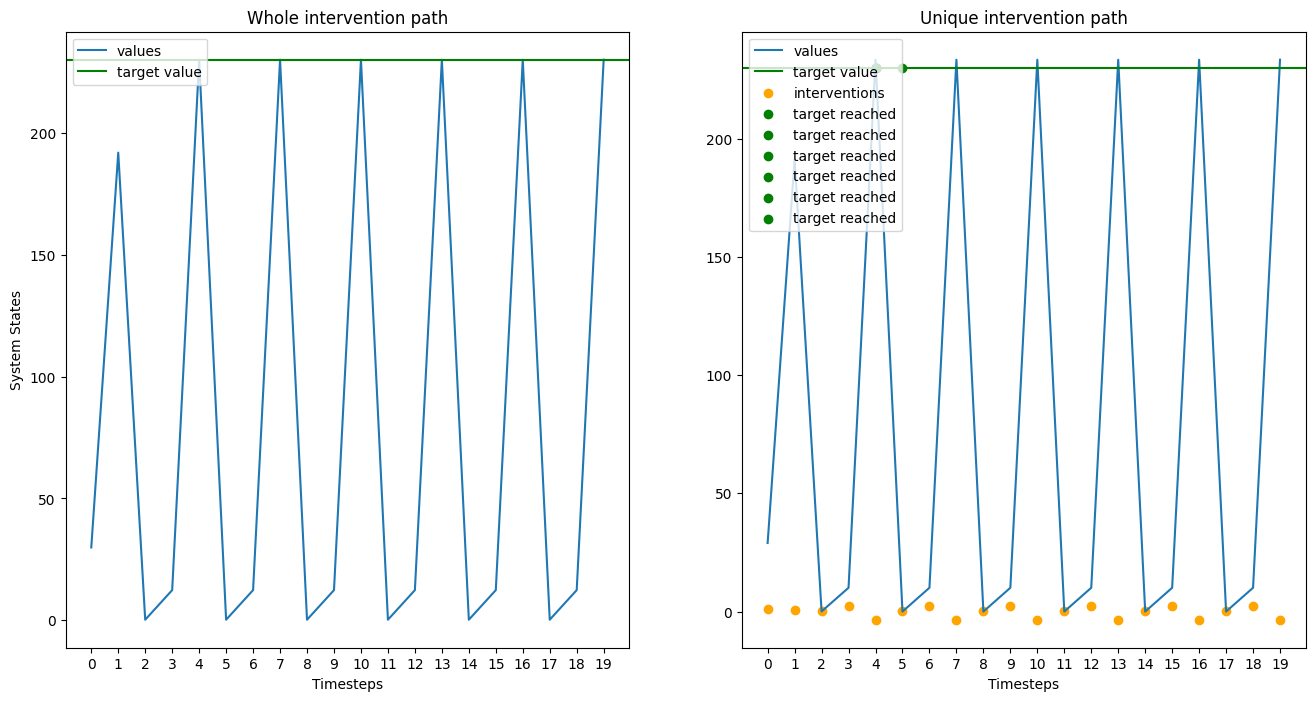

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t, label="target value", color="g")
ax1.legend(loc="upper left")
ax1.set_xticks(n)
ax1.set_xlabel("Timesteps")
ax1.set_title("Whole intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(testInt.values))
idx = np.argwhere(np.array(testInt.interventions) != 0).squeeze()

ax2.plot(n, testInt.values, label="values")
ax2.axhline(t, label="target value", color="g")
ax2.scatter(idx, [testInt.interventions[i] for i in idx], label="interventions", color="orange")

for (s,t) in testInt.target_step:
  ax2.scatter(s, t, label="target reached", color="g")

ax2.legend(loc="upper left")
ax2.set_xticks(n)
ax2.set_xlabel("Timesteps")
ax2.set_title("Unique intervention path")
;

##### Test 1 with Noise

In [ ]:
t = 230
max_int = 5
testInt = Interventor(gConst, t, max_int)

all_vals = []

In [ ]:
x = 29
for i in range(20):
    int_val, _ = testInt.intervention(x)
    print("Intervention: ", int_val)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Next value: ", x)
    x *= 1 + 0.25 * (random.rand()*1.5-0.75)
    print("Next value with noise: ", x)
    print("")

Current node:  23
Shortest Path:  [184, 9, 0, 153, 23]
Expected Path Length: 5
Intervention:  0.8958333333333357
Next value:  191.35737027904068
Next value with noise:  165.46648137210656

Current node:  132
Shortest Path:  [184, 9, 0, 132]
Expected Path Length: 4
Intervention:  0.15851862789344295
Next value:  0.24565787331707625
Next value with noise:  0.24050308822840732

Current node:  0
Shortest Path:  [184, 9, 0]
Expected Path Length: 3
Intervention:  0.012473102247783141
Next value:  10.07381918129086
Next value with noise:  10.55069232946664

Current node:  8
Best node:  9
Shortest Path:  [184, 9]
Expected Path Length: 2
Intervention:  1.8451410038666918
Next value:  233.44597325534508
Next value with noise:  232.47406458192418

Current node:  185
Best node:  184
Target reached using 5 steps
Intervention:  -2.474064581924182
Next value:  0.00643982428349221
Next value with noise:  0.006202626559229705

Current node:  0
Node already visited
Intervention:  0.24677356391696076
Nex

''

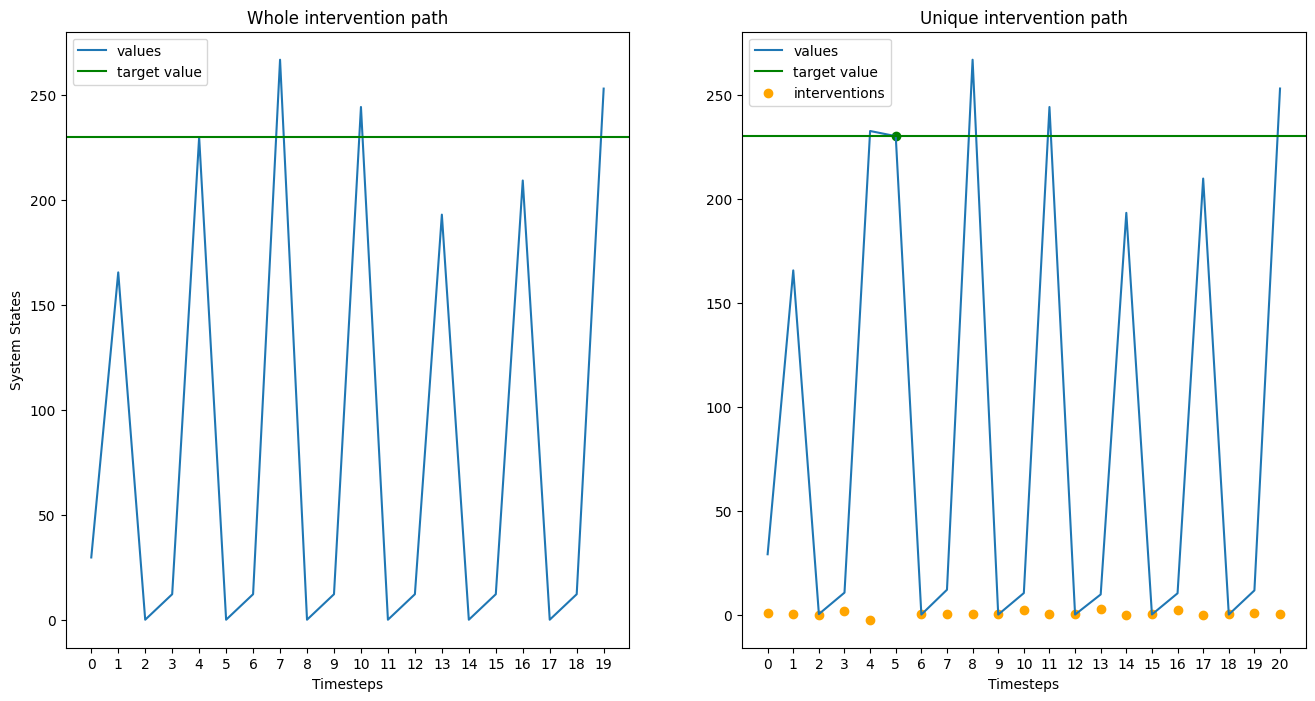

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t, label="target value", color="g")
ax1.legend(loc="upper left")
ax1.set_xticks(n)
ax1.set_xlabel("Timesteps")
ax1.set_title("Whole intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(testInt.values))
idx = np.argwhere(np.array(testInt.interventions) != 0).squeeze()

ax2.plot(n, testInt.values, label="values")
ax2.axhline(t, label="target value", color="g")
ax2.scatter(idx, [testInt.interventions[i] for i in idx], label="interventions", color="orange")

s_cnt = 0
for (s,t) in testInt.target_step:
  s_cnt += s
  ax2.scatter(s_cnt, t, color="g")

ax2.legend(loc="upper left")
ax2.set_xticks(n)
ax2.set_xlabel("Timesteps")
ax2.set_title("Unique intervention path")
;

##### Test 1 with Noise and high intervention value

In [ ]:
t = 230
max_int = 15
testInt = Interventor(gConst, t, max_int)

all_vals = []

In [ ]:
x = 29
for i in range(20):
    int_val, _ = testInt.intervention(x)
    print("Intervention: ", int_val)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Next value: ", x)
    x *= 1 + 0.25 * (random.rand()*1.5-0.75)
    print("Next value with noise: ", x)
    print("")

Current node:  23
Best node:  17
Shortest Path:  [184, 17]
Expected Path Length: 2
Intervention:  -7.28125
Next value:  230.17802381145603
Next value with noise:  188.687942805397

Current node:  150
Shortest Path:  [184, 9, 0, 150]
Expected Path Length: 4
Intervention:  -0.5629428053970003
Next value:  0.06967351415818876
Next value with noise:  0.05985917403175086

Current node:  0
Best node:  9
Shortest Path:  [184, 9]
Expected Path Length: 2
Intervention:  12.335974159301582
Next value:  233.44597325534508
Next value with noise:  225.8860595798398

Current node:  180
Best node:  184
Target reached using 4 steps
Intervention:  4.113940420160191
Next value:  0.00643982428349221
Next value with noise:  0.006422592725111657

Current node:  0
Node already visited
Intervention:  12.38941074060822
Next value:  233.44597325534508
Next value with noise:  225.06728334186928

Current node:  180
Node already visited
Intervention:  4.932716658130715
Next value:  0.00643982428349221
Next value w

''

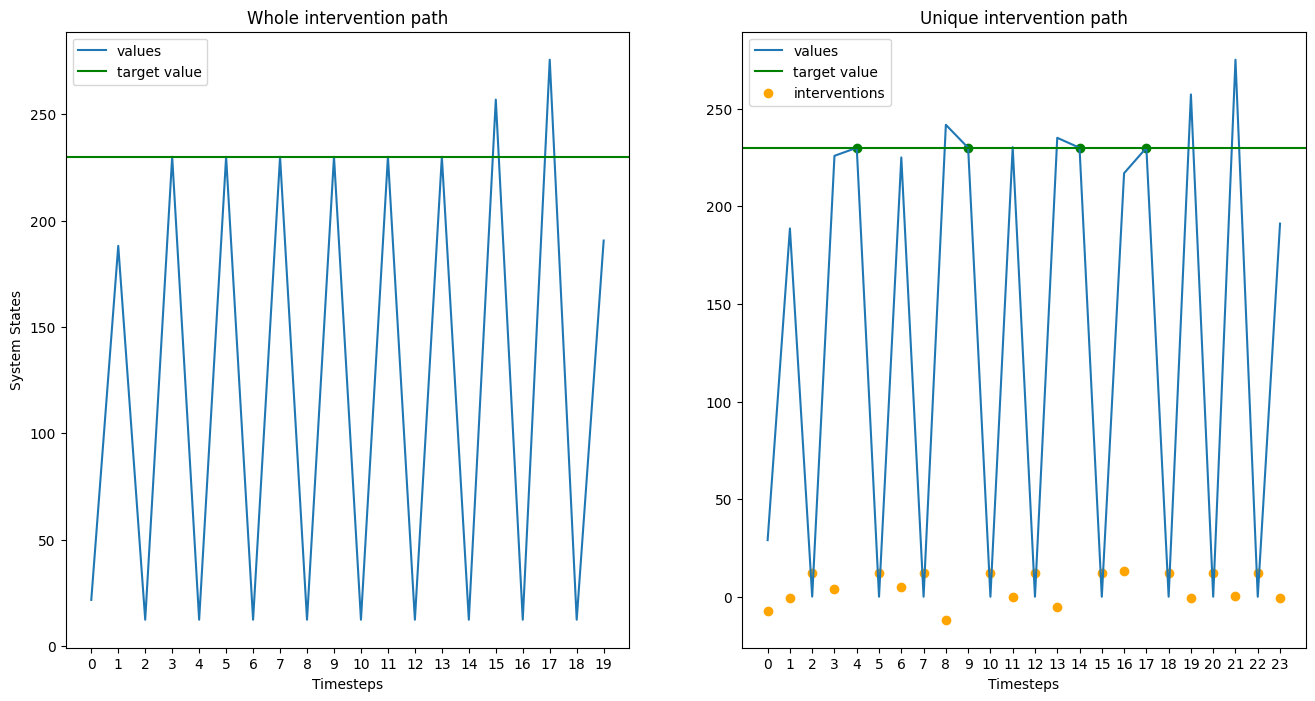

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t, label="target value", color="g")
ax1.legend(loc="upper left")
ax1.set_xticks(n)
ax1.set_xlabel("Timesteps")
ax1.set_title("Whole intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(testInt.values))
idx = np.argwhere(np.array(testInt.interventions) != 0).squeeze()

ax2.plot(n, testInt.values, label="values")
ax2.axhline(t, label="target value", color="g")
ax2.scatter(idx, [testInt.interventions[i] for i in idx], label="interventions", color="orange")

s_cnt = 0
for (s,t) in testInt.target_step:
  s_cnt += s
  ax2.scatter(s_cnt, t, color="g")

ax2.legend(loc="upper left")
ax2.set_xticks(n)
ax2.set_xlabel("Timesteps")
ax2.set_title("Unique intervention path")
;

##### Test 2

In [ ]:
t = 10
max_int = 5
testInt = Interventor(gConst, t, max_int)

all_vals = []

In [ ]:
x = 29
for i in range(20):
    int_val, _ = testInt.intervention(x)
    print("Intervention: ", int_val)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Next value: ", x)
    print("")

Current node:  23
Shortest Path:  [8, 0, 153, 23]
Expected Path Length: 4
Intervention:  0.8958333333333357
Next value:  191.35737027904068

Current node:  153
Shortest Path:  [8, 0, 153]
Expected Path Length: 3
Intervention:  0.5176297209593201
Next value:  0.05639089620424744

Current node:  0
Shortest Path:  [8, 0]
Expected Path Length: 2
Intervention:  0.18170434189099063
Next value:  9.489946119788756

Current node:  7
Best node:  8
Target reached using 4 steps
Intervention:  0.5100538802112435
Next value:  218.31051418620845

Current node:  174
Shortest Path:  [8, 0, 174]
Expected Path Length: 3
Intervention:  -0.18551418620845084
Next value:  0.012702285085507508

Current node:  0
Node already visited
Intervention:  0.22539295300973058
Next value:  9.489946119788756

Current node:  7
Using previous path.
Intervention:  0.5100538802112435
Next value:  218.31051418620845

Current node:  174
Using previous path.
Intervention:  -0.18551418620845084
Next value:  0.012702285085507508


''

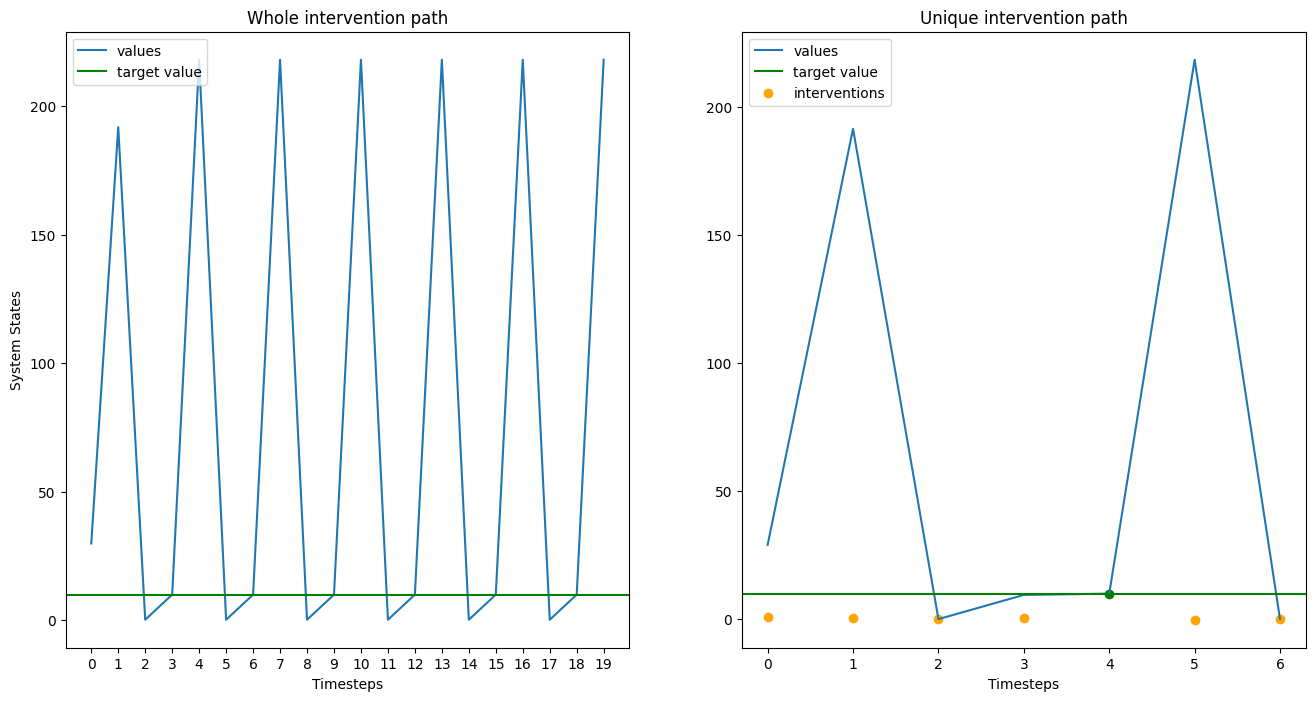

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t, label="target value", color="g")
ax1.legend(loc="upper left")
ax1.set_xticks(n)
ax1.set_xlabel("Timesteps")
ax1.set_title("Whole intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(testInt.values))
idx = np.argwhere(np.array(testInt.interventions) != 0).squeeze()

ax2.plot(n, testInt.values, label="values")
ax2.axhline(t, label="target value", color="g")
ax2.scatter(idx, [testInt.interventions[i] for i in idx], label="interventions", color="orange")

s_cnt = 0
for (s,t) in testInt.target_step:
  s_cnt += s
  ax2.scatter(s_cnt, t, color="g")

ax2.legend(loc="upper left")
ax2.set_xticks(n)
ax2.set_xlabel("Timesteps")
ax2.set_title("Unique intervention path")
;

In [ ]:
n1 = len(all_vals)
t2 = 42
testInt.update_target(t2)

for i in range(20):
    int_val = testInt.intervention(x)
    all_vals.append(x+int_val)
    print("Intervention: ", int_val)
    x = f(x+int_val)
    print("Next value: ", x)
    print("")

New target value 42.0 in node 33
Current node:  0
Shortest Path:  [33, 0]
Expected Path Length: 2
Intervention:  0.9545596196763972
Next value:  36.85776092122461

Current node:  29
Shortest Path:  [33, 0, 119, 29]
Expected Path Length: 4
Intervention:  0.7315247930611051
Next value:  149.71194826954596

Current node:  119
Shortest Path:  [33, 0, 119]
Expected Path Length: 3
Intervention:  -0.3369482695459567
Next value:  0.6035065346108621

Current node:  0
Shortest Path:  [33, 0]
Expected Path Length: 2
Intervention:  0.36375537015104265
Next value:  36.85776092122461

Current node:  29
Shortest Path:  [33, 0, 119, 29]
Expected Path Length: 4
Intervention:  0.7315247930611051
Next value:  149.71194826954596

Current node:  119
Shortest Path:  [33, 0, 119]
Expected Path Length: 3
Intervention:  -0.3369482695459567
Next value:  0.6035065346108621

Current node:  0
Shortest Path:  [33, 0]
Expected Path Length: 2
Intervention:  0.36375537015104265
Next value:  36.85776092122461

Current 

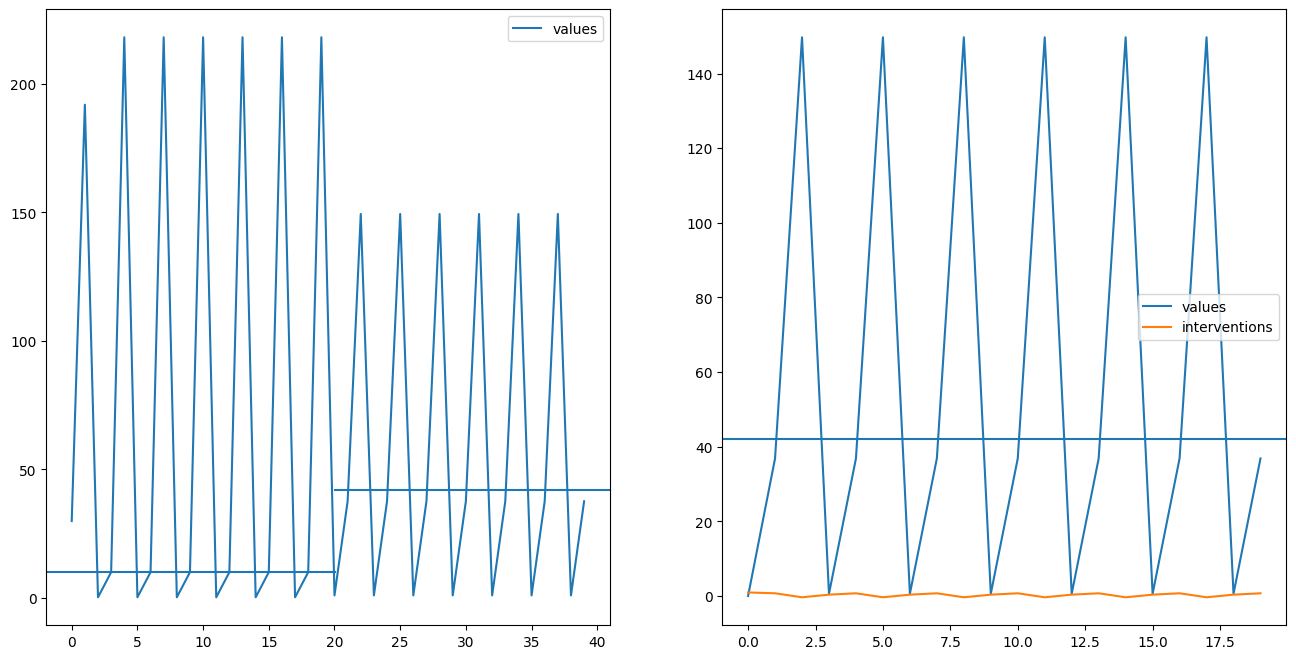

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

# # Show Plot of Regression
# n = np.linspace(0, gConst.max, gConst.N)
# ax1.set_xticks(n, np.arange(gConst.N), horizontalalignment="left", rotation=90)
# ax1.set_yticks(n, np.arange(gConst.N))
# ax1.grid()
# ax1.plot(np.arange(280), gConst.f(np.arange(280)), label="Regression")
# ax1.plot(np.arange(280), f(np.arange(280)), label="Ricker")
# ax1.set_xlim(0)
# ax1.set_ylim(0)
# ax1.legend()

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t, 0, n1 / max(n))
ax1.axhline(t2, n1 / max(n), 1)
ax1.legend();

n = np.arange(len(testInt.values))
ax2.plot(n, testInt.values, label="values")
ax2.plot(n, testInt.interventions, label="interventions")
ax2.axhline(t2, 0, 1)
ax2.legend();

In [ ]:
n2 = len(all_vals)
t3 = 60
testInt.update_target(t3)

for i in range(20):
    int_val = testInt.intervention(x)
    all_vals.append(x+int_val)
    print("Intervention: ", int_val)
    x = f(x+int_val)
    print("Next value: ", x)
    print("")

New target value 60.0 in node 48
Current node:  1
Shortest Path:  [48, 1]
Expected Path Length: 2
Intervention:  -0.30523604040874597
Next value:  58.04107960401259

Current node:  46
Best node:  48
Target reached using 2 steps
Intervention:  1.9589203959874126
Next value:  60.0

Current node:  48
Using previous path.
Intervention:  0.0
Next value:  60.0

Current node:  48
Using previous path.
Intervention:  0.0
Next value:  60.0

Current node:  48
Using previous path.
Intervention:  0.0
Next value:  60.0

Current node:  48
Using previous path.
Intervention:  0.0
Next value:  60.0

Current node:  48
Using previous path.
Intervention:  0.0
Next value:  60.0

Current node:  48
Using previous path.
Intervention:  0.0
Next value:  60.0

Current node:  48
Using previous path.
Intervention:  0.0
Next value:  60.0

Current node:  48
Using previous path.
Intervention:  0.0
Next value:  60.0

Current node:  48
Using previous path.
Intervention:  0.0
Next value:  60.0

Current node:  48
Using pr

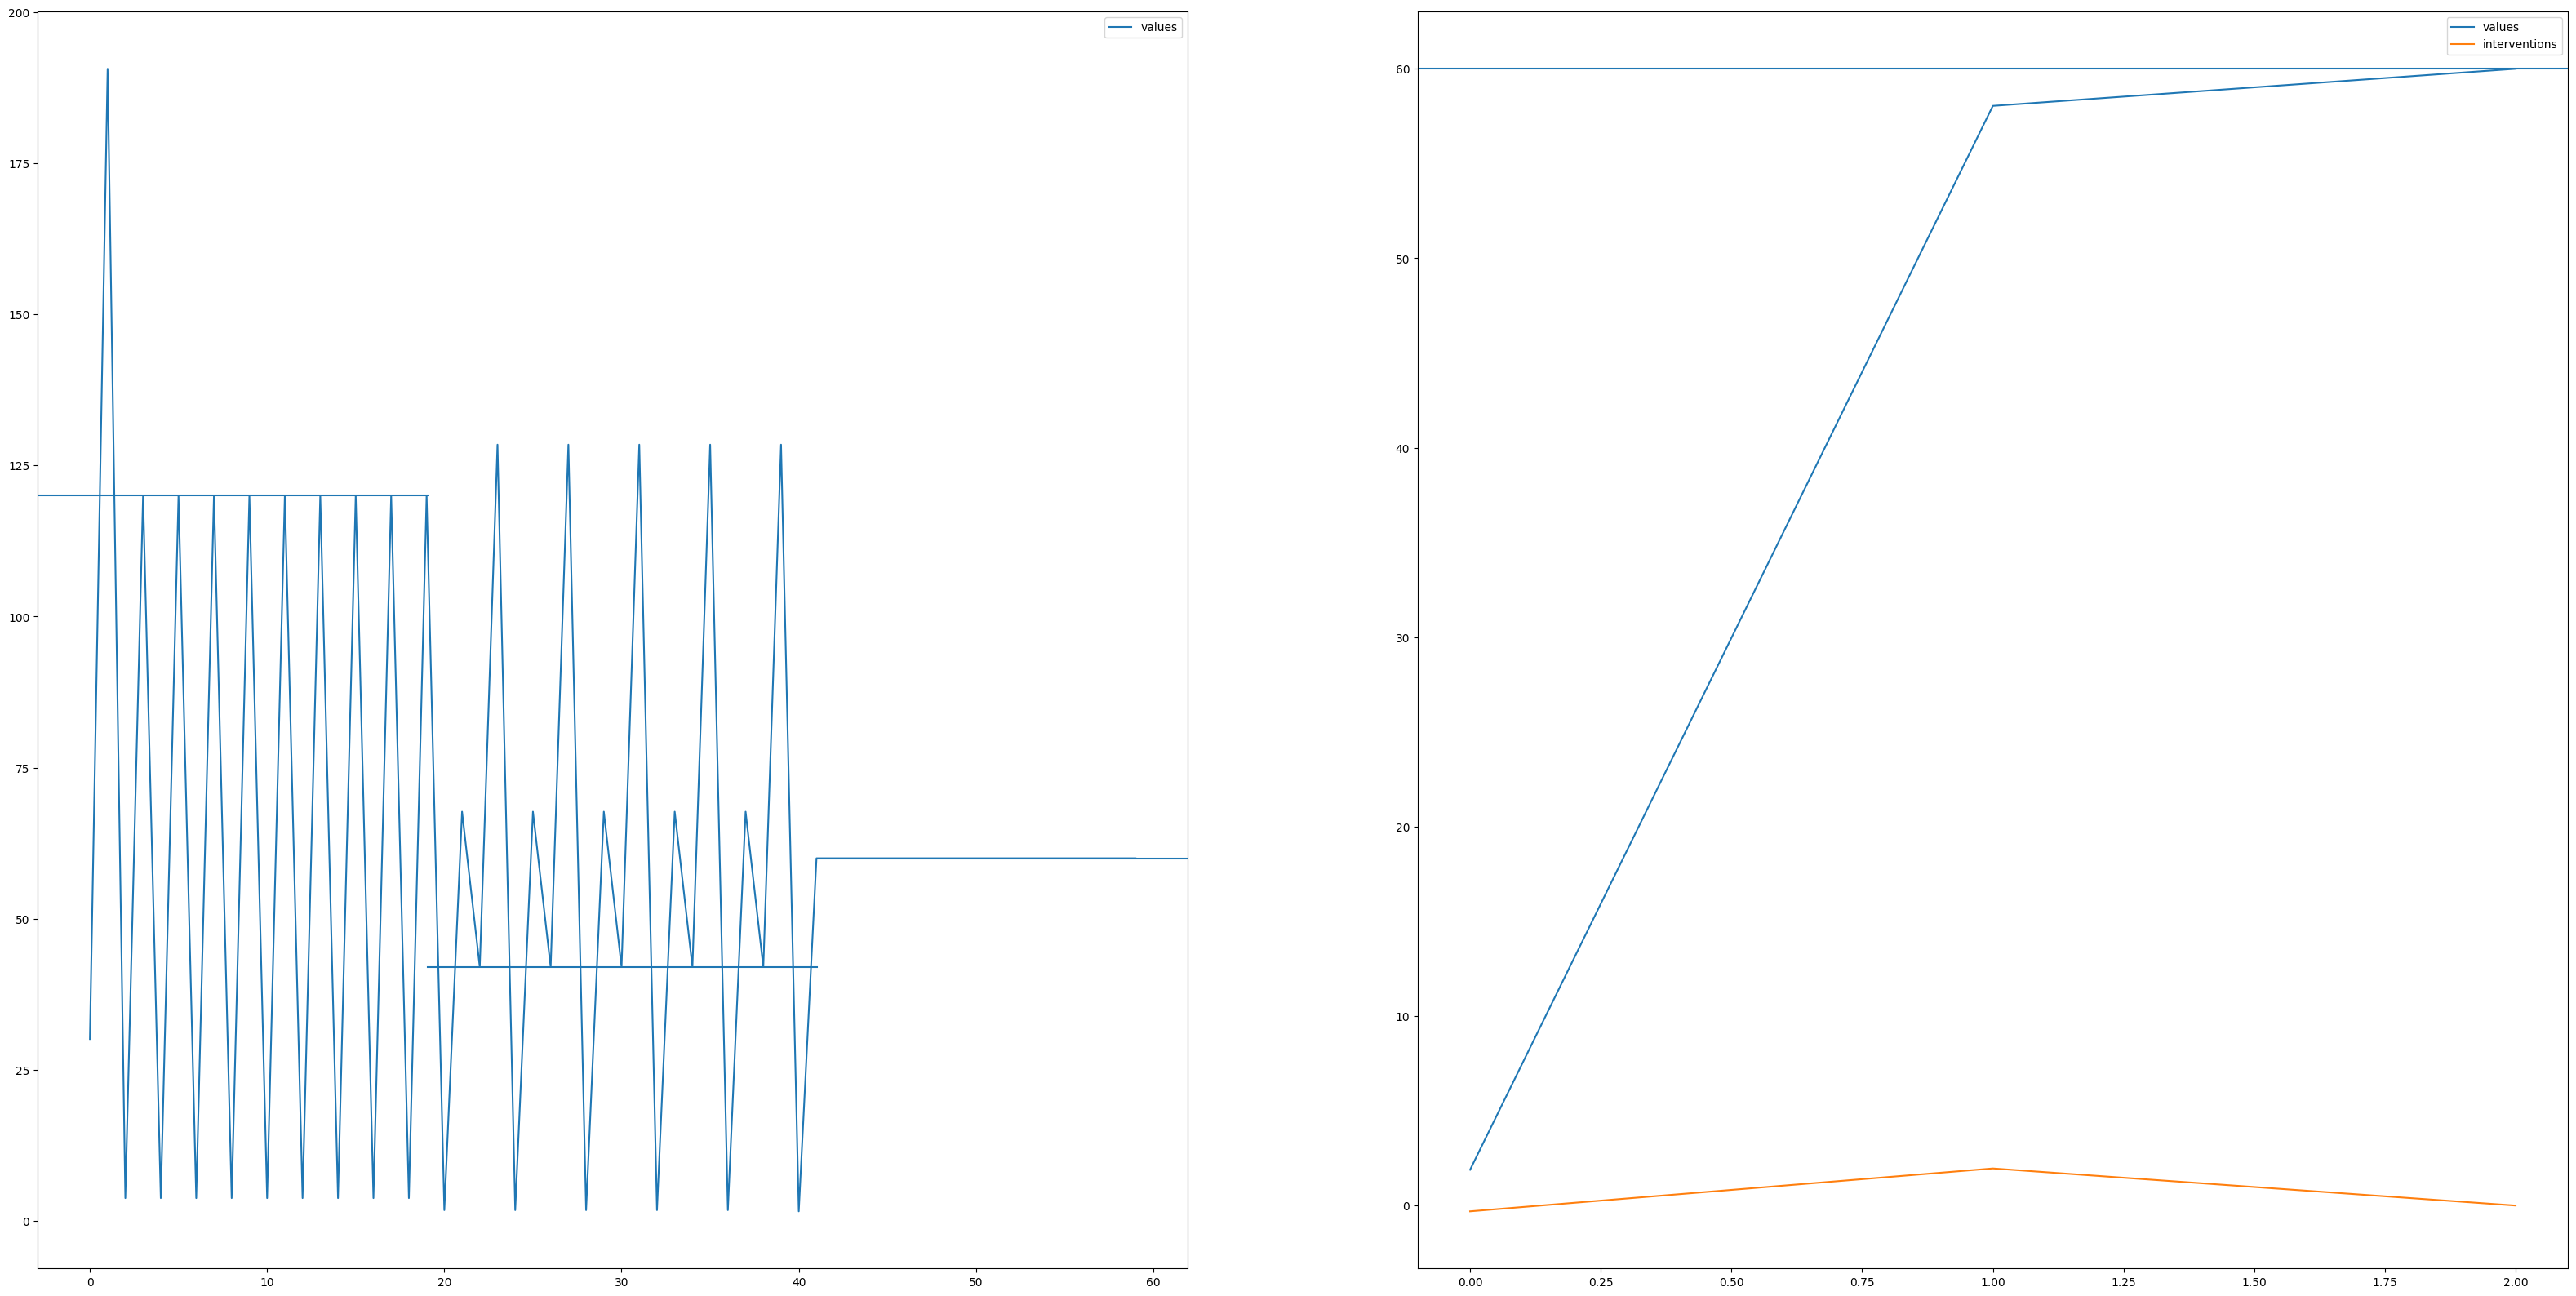

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))

# # Show Plot of Regression
# n = np.linspace(0, gConst.max, gConst.N)
# ax1.set_xticks(n, np.arange(gConst.N), horizontalalignment="left", rotation=90)
# ax1.set_yticks(n, np.arange(gConst.N))
# ax1.grid()
# ax1.plot(np.arange(280), gConst.f(np.arange(280)), label="Regression")
# ax1.plot(np.arange(280), f(np.arange(280)), label="Ricker")
# ax1.set_xlim(0)
# ax1.set_ylim(0)
# ax1.legend()

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t, 0, n1 / max(n))
ax1.axhline(t2, n1 / max(n), n2 / max(n))
ax1.axhline(t3, n2 / max(n), 1)
ax1.legend();

n = np.arange(len(testInt.values))
ax2.plot(n, testInt.values, label="values")
ax2.plot(n, testInt.interventions, label="interventions")
ax2.axhline(t3, 0, 1)
ax2.legend();

##### Test 3: 2 Point Oscillation

In [ ]:
t1 = 170
t2 = 42
max_int = 25

Int1 = Interventor(gConst, t1, max_int)
Int2 = Interventor(gConst, t2, max_int)

switch = bool
all_vals = []

In [ ]:
x = 29
for i in range(20):

    if switch:
        int_val = Int1.intervention(x)
    else:
        int_val = Int2.intervention(x)

    print("Intervention: ", int_val)
    all_vals.append(x+int_val)

    if x+int_val == t1 or x+int_val == t2:
        switch = not switch

    x = f(x+int_val)
    print("Next value: ", x)
    print("")

Current node:  23
Best node:  5
Shortest Path:  [136, 5]
Expected Path Length: 2
Intervention:  -22.7109375
Next value:  172.60167664735428

Current node:  138
Best node:  136
Target reached using 2 steps
Intervention:  -2.6016766473542816
Next value:  0.19252391556243306

Current node:  0
Shortest Path:  [33, 0]
Expected Path Length: 2
Intervention:  0.8543510844375669
Next value:  39.69607214417864

Current node:  31
Best node:  33
Target reached using 2 steps
Intervention:  2.3039278558213567
Next value:  127.44305256629842

Current node:  101
Best node:  86
Shortest Path:  [136, 5, 86]
Expected Path Length: 3
Intervention:  -19.00555256629842
Next value:  5.469541562323977

Current node:  4
Best node:  5
Shortest Path:  [136, 5]
Expected Path Length: 2
Intervention:  0.8195209376760229
Next value:  172.60167664735428

Current node:  138
Using previous path.
Intervention:  -2.6016766473542816
Next value:  0.19252391556243306

Current node:  0
Using previous path.
Intervention:  0.85

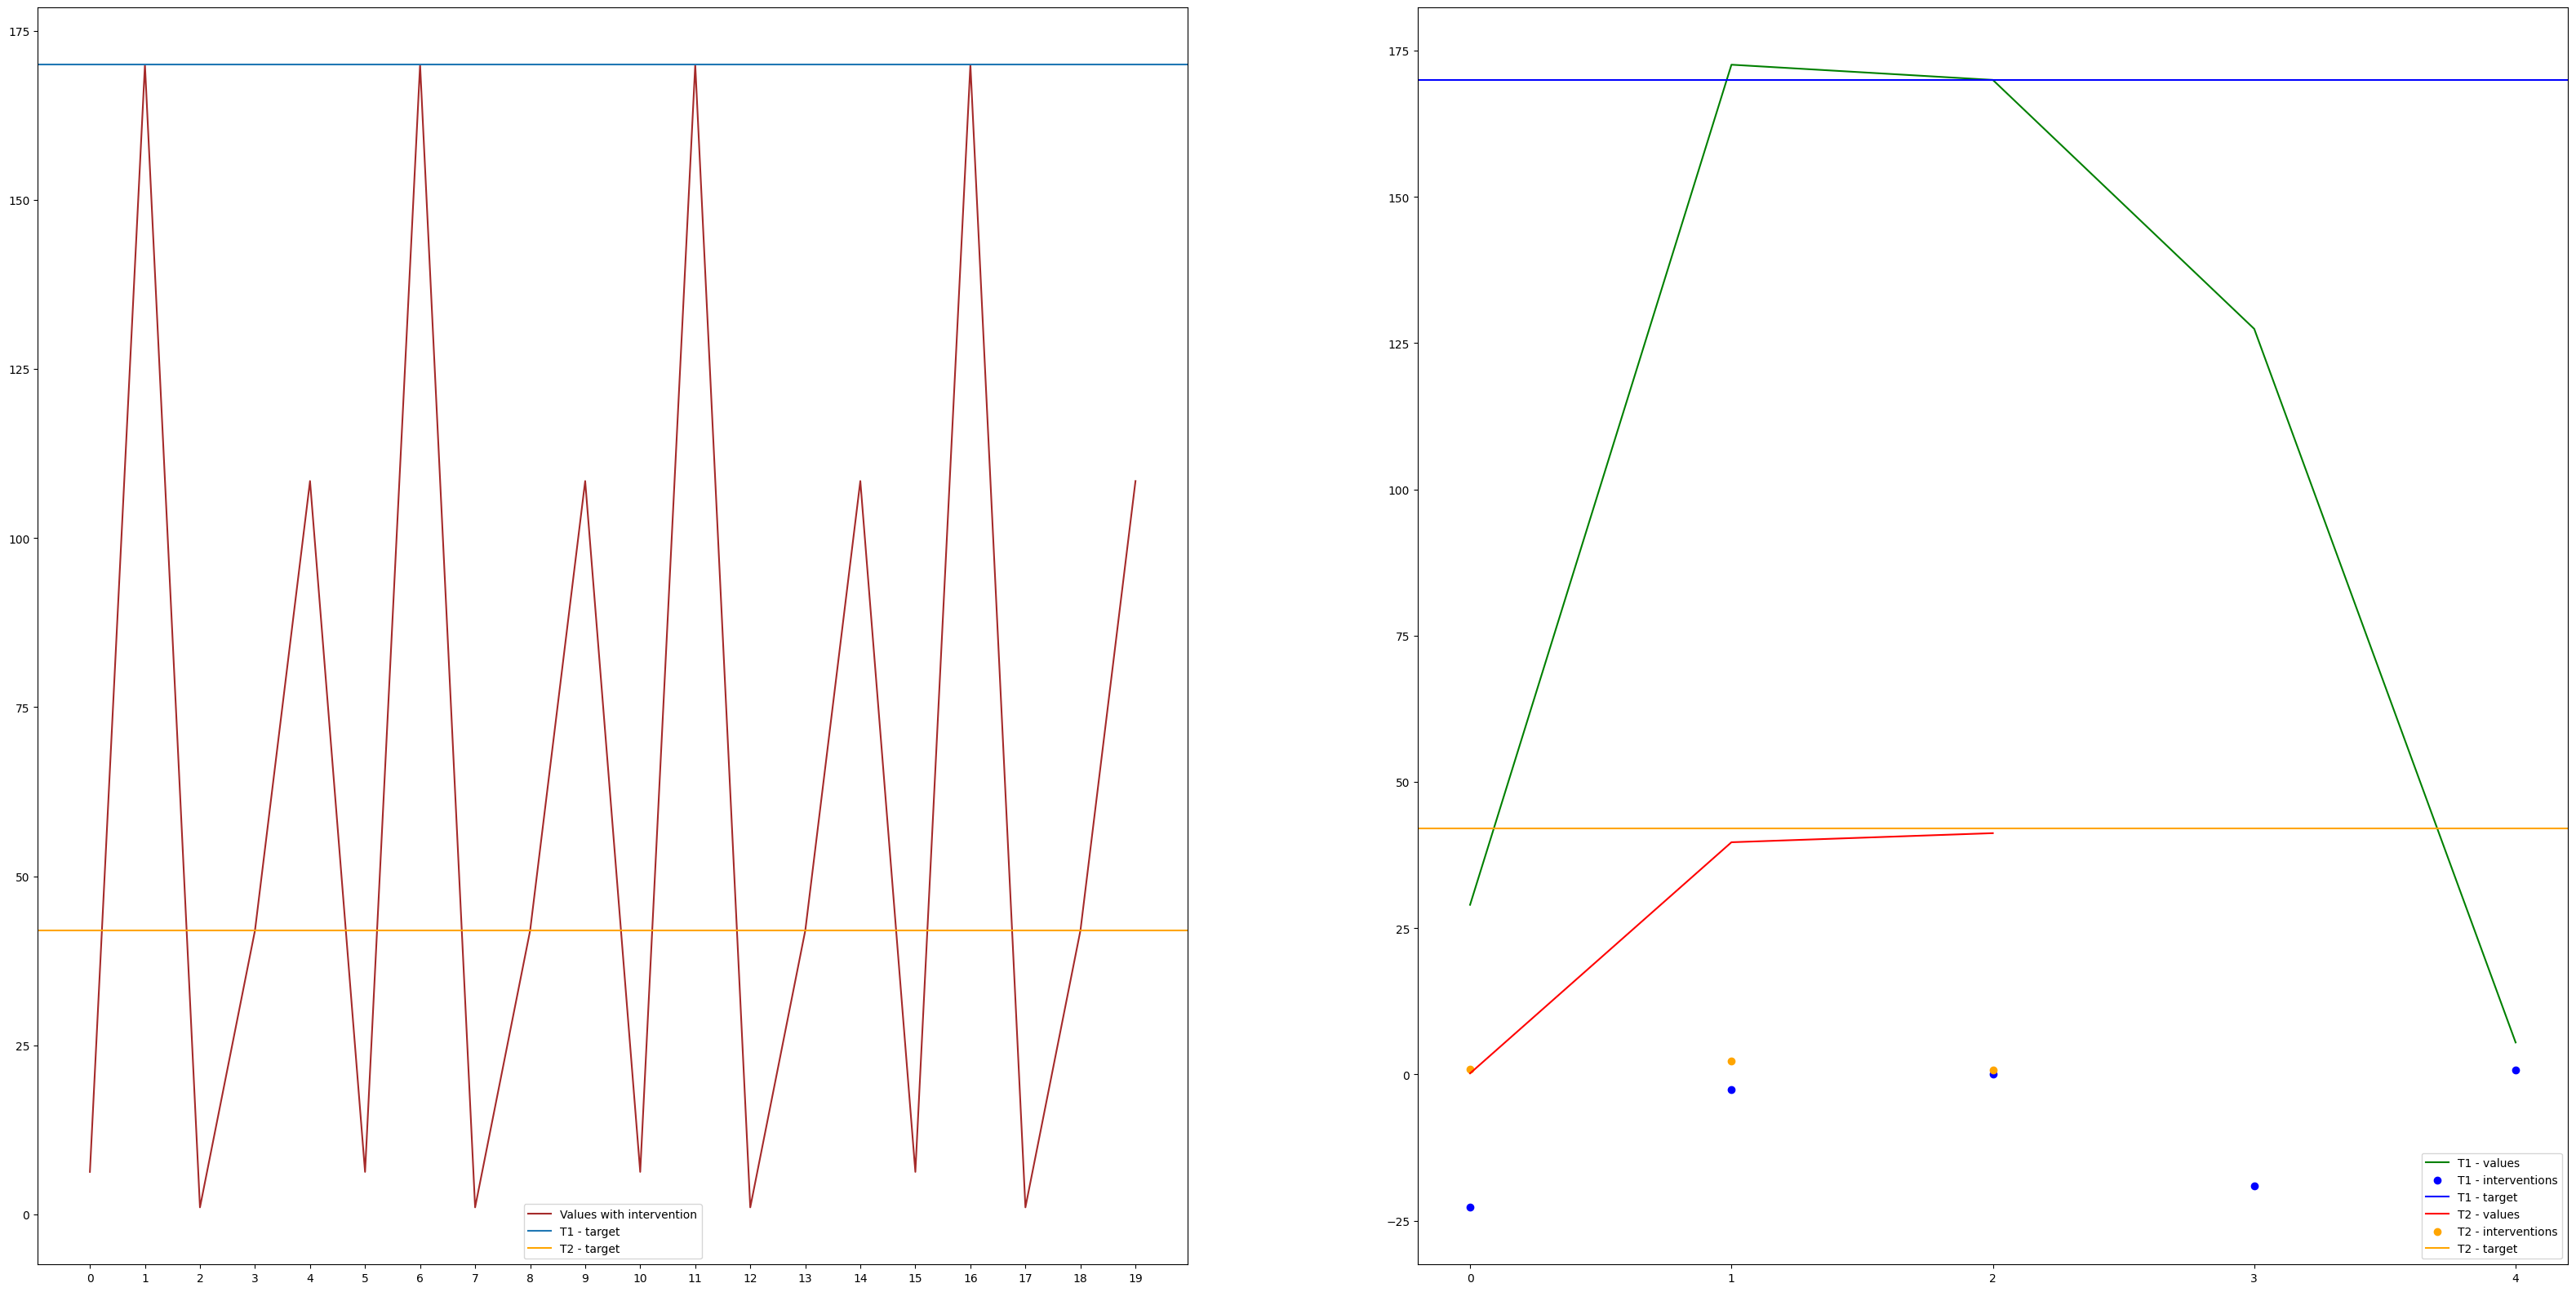

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, c="brown", label="Values with intervention")
ax1.axhline(t1, label="T1 - target")
ax1.axhline(t2, c="orange", label="T2 - target")
ax1.set_xticks(n)
ax1.legend();

n1 = np.arange(len(Int1.values))
ax2.plot(n1, Int1.values, c="green", label="T1 - values")
ax2.scatter(n1, Int1.interventions, c="blue", label="T1 - interventions")
ax2.axhline(t1, c="blue", label="T1 - target")

n2 = np.arange(len(Int2.values))
ax2.plot(n2, Int2.values, c="red", label="T2 - values")
ax2.scatter(n2, Int2.interventions, c="orange", label="T2 - interventions")
ax2.axhline(t2, c="orange", label="T2 - target")
ax2.set_xticks(n1 if n1[-1] > n2[-1] else n2)
ax2.legend();

##### Test 4: Few samples

In [14]:
data = make_samples(1, 20, f, f.max_val, noise=0.25)
data.max()

245.5968540352527

In [15]:
gConst= GraphConstructor(200, x=data[:-1], y=data[1:], min_val=0, max_val=250, automatic_padding="max")
gConst.create_graph();

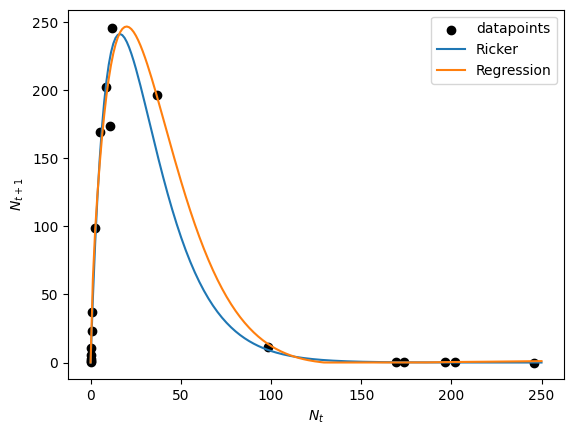

In [16]:
n = np.linspace(0, 250, 200)

plt.scatter(data[:-1], data[1:], label="datapoints", color="k")
plt.plot(n, f(n), label="Ricker")
plt.plot(n, gConst.f(n), label="Regression")
plt.xlabel("$N_t$")
plt.ylabel("$N_{t+1}$")
plt.legend()
plt.show()

In [35]:
t = 70
max_int = 5
testInt = Interventor(gConst, t, max_int)

all_vals = []

In [36]:
x = 29
for i in range(20):
    int_val, _ = testInt.intervention(x)
    print("Intervention: ", int_val)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Next value: ", x)
    print("")

Current node:  23
Shortest Path:  [56, 1, 0, 179, 23]
Expected Path Length: 5
Intervention:  1.125
Next value:  190.11840427852317

Current node:  152
Shortest Path:  [56, 1, 0, 152]
Expected Path Length: 4
Intervention:  0.5065957214768275
Next value:  0.06051281089857274

Current node:  0
Best node:  1
Shortest Path:  [56, 1]
Expected Path Length: 2
Intervention:  1.4603205224347606
Next value:  56.00683338474228

Current node:  44
Best node:  41
Shortest Path:  [56, 1, 98, 41]
Expected Path Length: 4
Intervention:  -3.6318333847422792
Next value:  83.81715595842819

Current node:  67
Shortest Path:  [56, 1, 0, 171, 25, 67]
Expected Path Length: 6
Intervention:  0.1411773749051548
Next value:  19.16125149417711

Current node:  15
Shortest Path:  [56, 1, 0, 197, 15]
Expected Path Length: 5
Intervention:  0.2137485058228883
Next value:  237.2683807263503

Current node:  189
Shortest Path:  [56, 1, 0, 189]
Expected Path Length: 4
Intervention:  -0.3933807263503013
Next value:  0.0043405

''

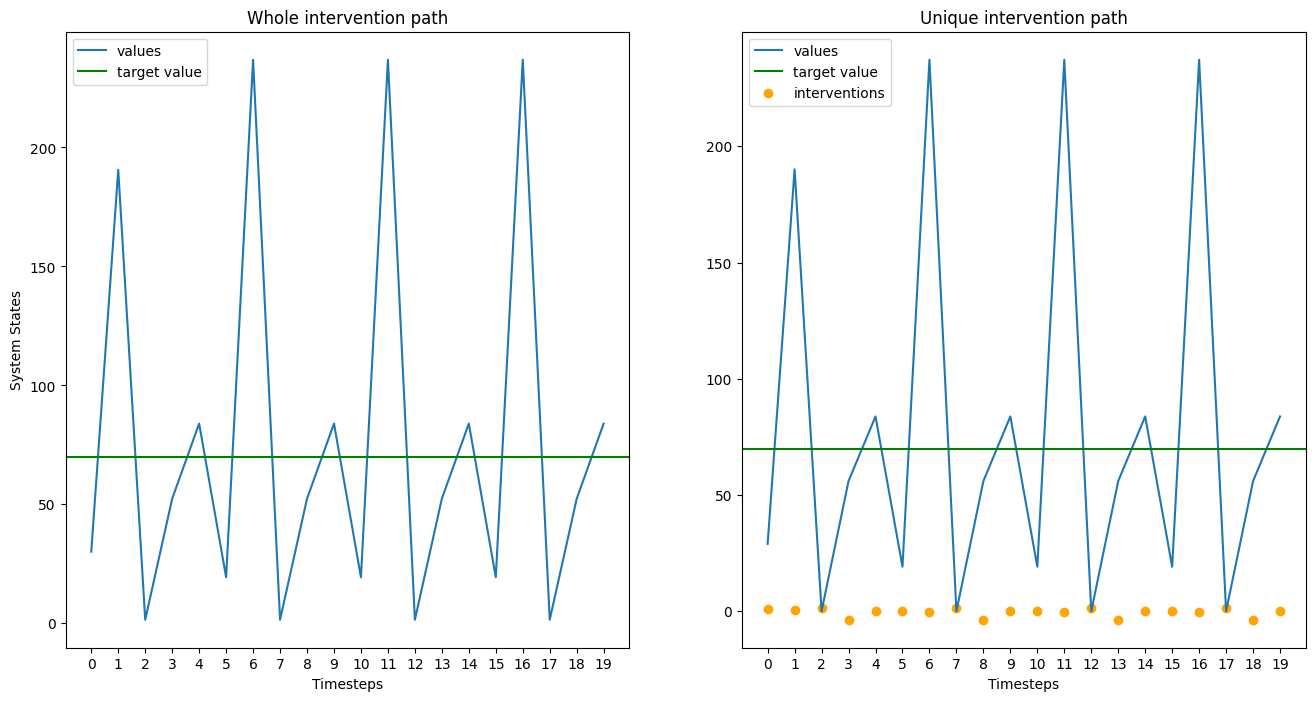

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t, label="target value", color="g")
ax1.legend(loc="upper left")
ax1.set_xticks(n)
ax1.set_xlabel("Timesteps")
ax1.set_title("Whole intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(testInt.values))
idx = np.argwhere(np.array(testInt.interventions) != 0).squeeze()

ax2.plot(n, testInt.values, label="values")
ax2.axhline(t, label="target value", color="g")
ax2.scatter(idx, [testInt.interventions[i] for i in idx], label="interventions", color="orange")

s_cnt = 0
for (s,t) in testInt.target_step:
  s_cnt += s
  ax2.scatter(s_cnt, t, color="g")

ax2.legend(loc="upper left")
ax2.set_xticks(n)
ax2.set_xlabel("Timesteps")
ax2.set_title("Unique intervention path")
;

In [24]:
max(testInt.interventions)

1.5164928045153454

In [32]:
t = 70
max_int = 15
testInt = Interventor(gConst, t, max_int)

all_vals = []

In [33]:
x = 29
for i in range(20):
    int_val, _ = testInt.intervention(x)
    print("Intervention: ", int_val)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Next value: ", x)
    print("")

Current node:  23
Shortest Path:  [56, 1, 0, 179, 23]
Expected Path Length: 5
Intervention:  1.125
Next value:  190.11840427852317

Current node:  152
Shortest Path:  [56, 1, 0, 152]
Expected Path Length: 4
Intervention:  0.5065957214768275
Next value:  0.06051281089857274

Current node:  0
Best node:  1
Shortest Path:  [56, 1]
Expected Path Length: 2
Intervention:  1.4603205224347606
Next value:  56.00683338474228

Current node:  44
Best node:  53
Shortest Path:  [56, 53]
Expected Path Length: 2
Intervention:  11.02441661525772
Next value:  43.44801554699396

Current node:  34
Best node:  41
Shortest Path:  [56, 1, 98, 41]
Expected Path Length: 4
Intervention:  8.926984453006042
Next value:  83.81715595842819

Current node:  67
Best node:  56
Target reached using 6 steps
Intervention:  -13.817155958428188
Next value:  37.781840433652874

Current node:  30
Best node:  41
Shortest Path:  [56, 1, 98, 41]
Expected Path Length: 4
Intervention:  14.593159566347126
Next value:  83.8171559584

''

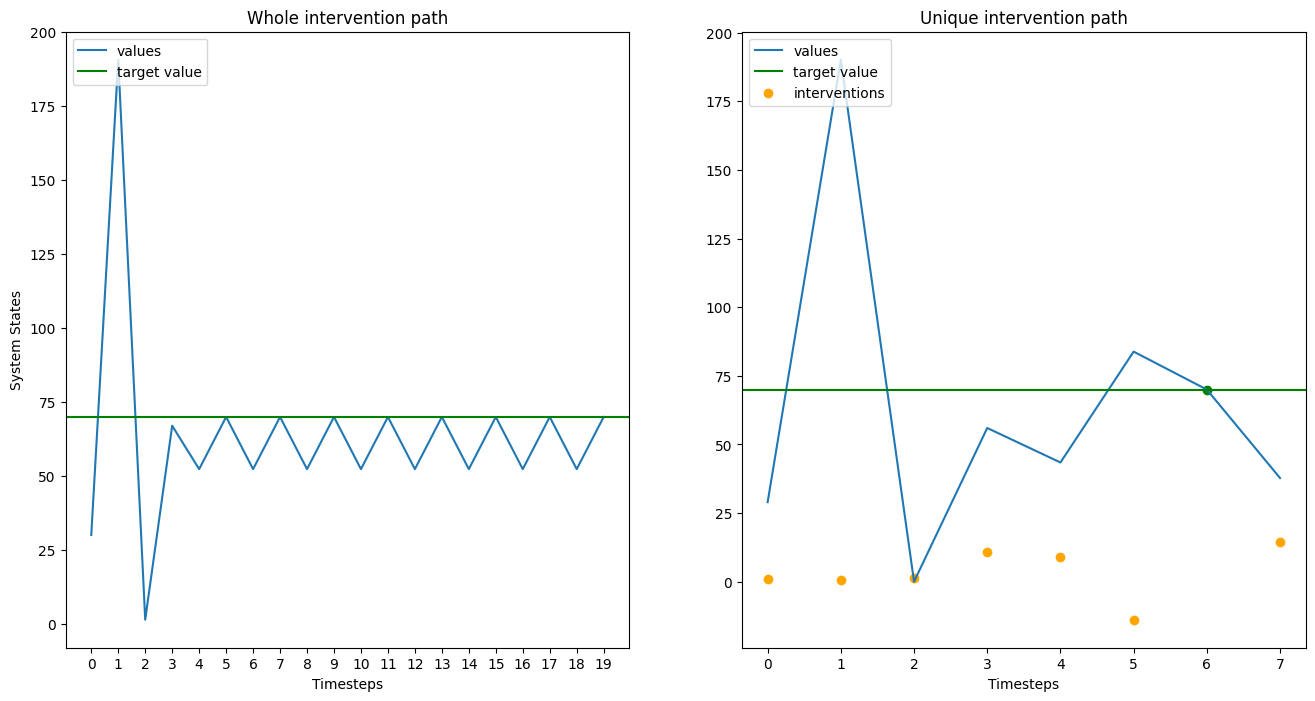

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t, label="target value", color="g")
ax1.legend(loc="upper left")
ax1.set_xticks(n)
ax1.set_xlabel("Timesteps")
ax1.set_title("Whole intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(testInt.values))
idx = np.argwhere(np.array(testInt.interventions) != 0).squeeze()

ax2.plot(n, testInt.values, label="values")
ax2.axhline(t, label="target value", color="g")
ax2.scatter(idx, [testInt.interventions[i] for i in idx], label="interventions", color="orange")

s_cnt = 0
for (s,t) in testInt.target_step:
  s_cnt += s
  ax2.scatter(s_cnt, t, color="g")

ax2.legend(loc="upper left")
ax2.set_xticks(n)
ax2.set_xlabel("Timesteps")
ax2.set_title("Unique intervention path")
;

##### Test 5 Few Samples with Noise

In [38]:
t = 70
max_int = 10
testInt = Interventor(gConst, t, max_int)

all_vals = []

In [39]:
x = 29
for i in range(20):
    int_val, _ = testInt.intervention(x)
    print("Intervention: ", int_val)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Next value: ", x)
    x *= 1 + 0.25 * (random.rand()*1.5-0.75)
    print("Next value with noise: ", x)
    print("")

Current node:  23
Shortest Path:  [56, 1, 0, 179, 23]
Expected Path Length: 5
Intervention:  1.125
Next value:  190.11840427852317
Next value with noise:  202.06687441514217

Current node:  161
Shortest Path:  [56, 1, 0, 161]
Expected Path Length: 4
Intervention:  -0.1918744151421663
Next value:  0.032022719639960784
Next value with noise:  0.035719493749117495

Current node:  0
Best node:  1
Shortest Path:  [56, 1]
Expected Path Length: 2
Intervention:  1.4851138395842158
Next value:  56.00683338474228
Next value with noise:  61.5154933257655

Current node:  49
Best node:  56
Target reached using 4 steps
Intervention:  8.484506674234503
Next value:  37.781840433652874
Next value with noise:  42.0013208437057

Current node:  33
Shortest Path:  [56, 1, 0, 134, 33]
Expected Path Length: 5
Intervention:  0.6028458229609654
Next value:  124.54848939407059
Next value with noise:  121.53986408213711

Current node:  97
Shortest Path:  [56, 1, 97]
Expected Path Length: 3
Intervention:  0.33513

''

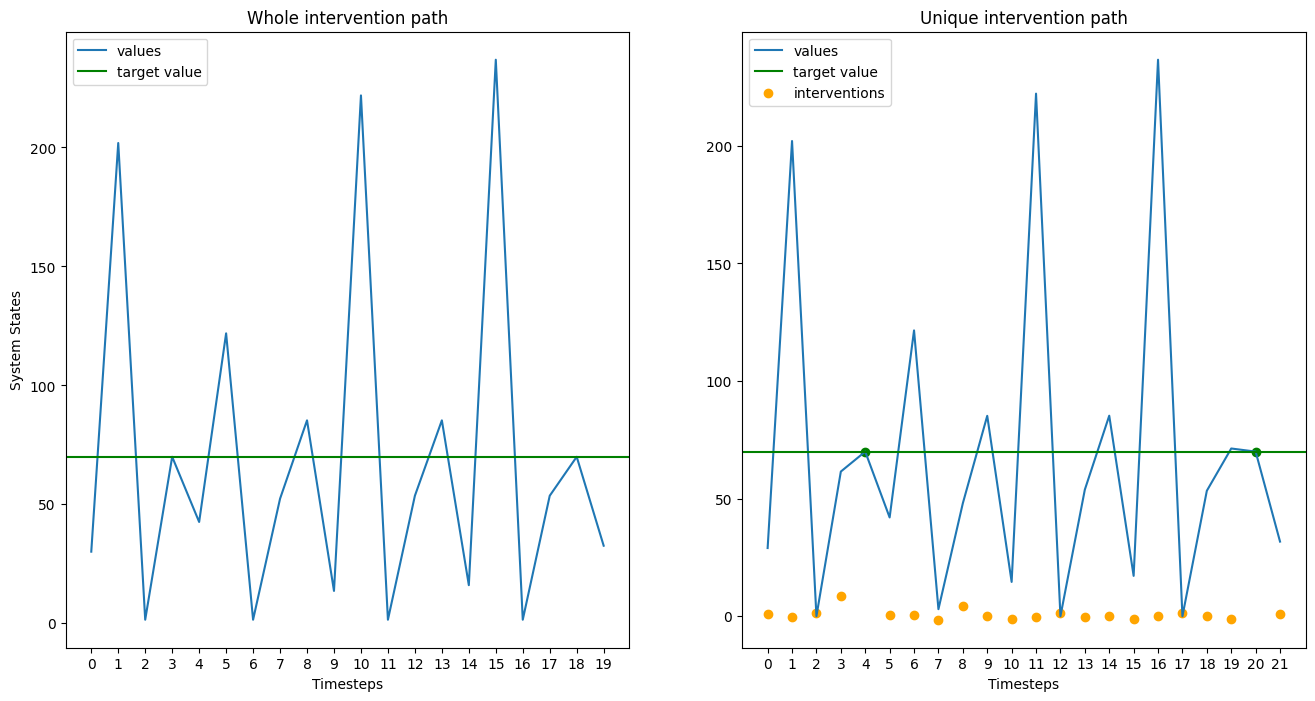

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t, label="target value", color="g")
ax1.legend(loc="upper left")
ax1.set_xticks(n)
ax1.set_xlabel("Timesteps")
ax1.set_title("Whole intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(testInt.values))
idx = np.argwhere(np.array(testInt.interventions) != 0).squeeze()

ax2.plot(n, testInt.values, label="values")
ax2.axhline(t, label="target value", color="g")
ax2.scatter(idx, [testInt.interventions[i] for i in idx], label="interventions", color="orange")

s_cnt = 0
for (s,t) in testInt.target_step:
  s_cnt += s
  ax2.scatter(s_cnt, t, color="g")

ax2.legend(loc="upper left")
ax2.set_xticks(n)
ax2.set_xlabel("Timesteps")
ax2.set_title("Unique intervention path")
;

In [41]:
t = 70
max_int = 5
testInt = Interventor(gConst, t, max_int)

all_vals = []

In [42]:
x = 29
for i in range(20):
    int_val, _ = testInt.intervention(x)
    print("Intervention: ", int_val)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Next value: ", x)
    x *= 1 + 0.25 * (random.rand()*1.5-0.75)
    print("Next value with noise: ", x)
    print("")

Current node:  23
Shortest Path:  [56, 1, 0, 179, 23]
Expected Path Length: 5
Intervention:  1.125
Next value:  190.11840427852317
Next value with noise:  202.1110350937123

Current node:  161
Shortest Path:  [56, 1, 0, 161]
Expected Path Length: 4
Intervention:  -0.23603509371230302
Next value:  0.032022719639960784
Next value with noise:  0.033457621833691206

Current node:  0
Best node:  1
Shortest Path:  [56, 1]
Expected Path Length: 2
Intervention:  1.487375711499642
Next value:  56.00683338474228
Next value with noise:  55.24011475733776

Current node:  44
Best node:  41
Shortest Path:  [56, 1, 98, 41]
Expected Path Length: 4
Intervention:  -2.865114757337757
Next value:  83.81715595842819
Next value with noise:  80.03865070425134

Current node:  64
Shortest Path:  [56, 1, 0, 149, 30, 64]
Expected Path Length: 6
Intervention:  0.27384929574866135
Next value:  22.950072795594945
Next value with noise:  26.07702293563091

Current node:  20
Shortest Path:  [56, 1, 0, 189, 20]
Expect

''

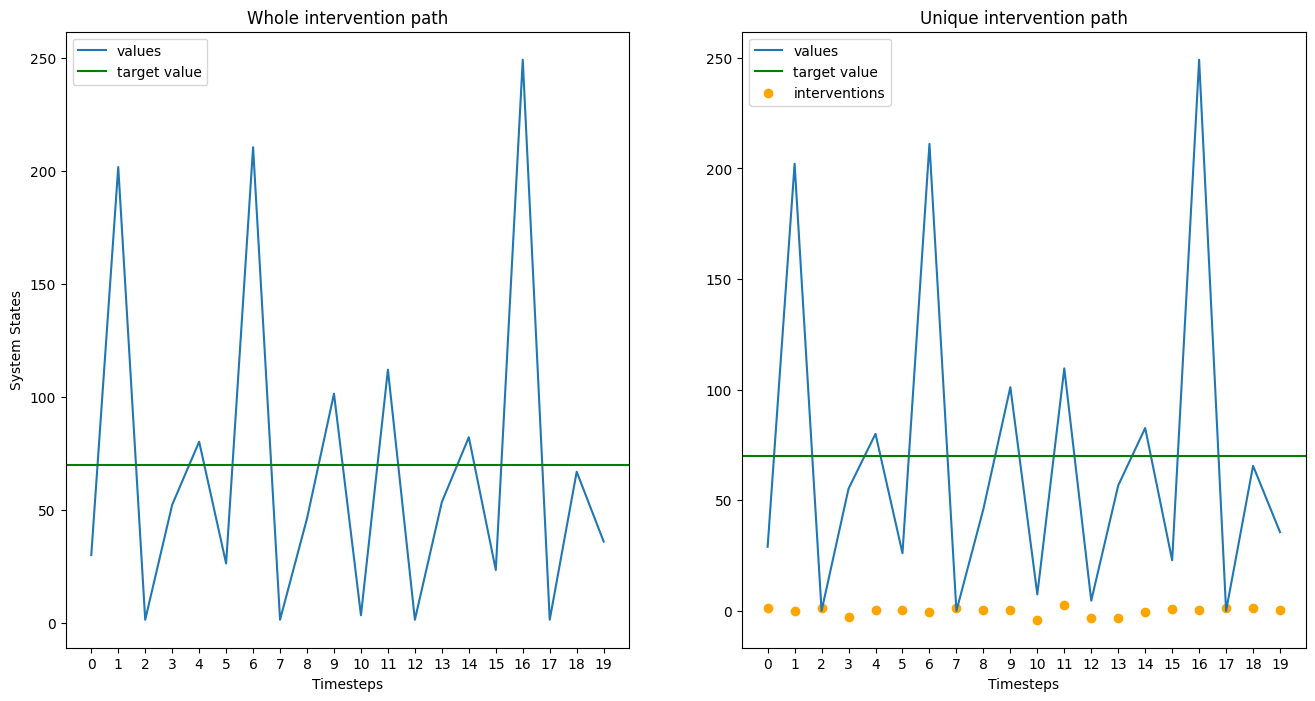

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t, label="target value", color="g")
ax1.legend(loc="upper left")
ax1.set_xticks(n)
ax1.set_xlabel("Timesteps")
ax1.set_title("Whole intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(testInt.values))
idx = np.argwhere(np.array(testInt.interventions) != 0).squeeze()

ax2.plot(n, testInt.values, label="values")
ax2.axhline(t, label="target value", color="g")
ax2.scatter(idx, [testInt.interventions[i] for i in idx], label="interventions", color="orange")

s_cnt = 0
for (s,t) in testInt.target_step:
  s_cnt += s
  ax2.scatter(s_cnt, t, color="g")

ax2.legend(loc="upper left")
ax2.set_xticks(n)
ax2.set_xlabel("Timesteps")
ax2.set_title("Unique intervention path")
;

##### Test 6: Few samples High Granularity

In [ ]:
gConst2 = GraphConstructor(1000, x=data[:-1], y=data[1:], min_val=0, max_val=250, automatic_padding="max")
rm = gConst2.get_regression_matrix()

In [ ]:
t = 230
max_int = 5
testInt = Interventor(gConst2, t, max_int)

all_vals = []

In [ ]:
x = 29
for i in range(20):
    int_val, _ = testInt.intervention(x)
    print("Intervention: ", int_val)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Next value: ", x)
    print("")

Current node:  116
Best node:  97
Shortest Path:  [920, 59, 2, 856, 97]
Expected Path Length: 5
Intervention:  -4.524999999999999
Next value:  218.84430080723993

Current node:  875
Best node:  856
Shortest Path:  [920, 59, 2, 856]
Expected Path Length: 4
Intervention:  -4.719300807239932
Next value:  0.015957680280529036

Current node:  0
Best node:  2
Shortest Path:  [920, 59, 2]
Expected Path Length: 3
Intervention:  0.5003466675455579
Next value:  20.228699550099613

Current node:  80
Best node:  79
Shortest Path:  [920, 79]
Expected Path Length: 2
Intervention:  -0.35369955009961274
Next value:  236.0013819055352

Current node:  944
Shortest Path:  [920, 59, 316, 12, 543, 23, 0, 944]
Expected Path Length: 8
Intervention:  0.12361809446480265
Next value:  0.004531599366119598

Current node:  0
Best node:  2
Shortest Path:  [920, 59, 2]
Expected Path Length: 3
Intervention:  0.5117727484599673
Next value:  20.228699550099613

Current node:  80
Best node:  79
Shortest Path:  [920, 79

''

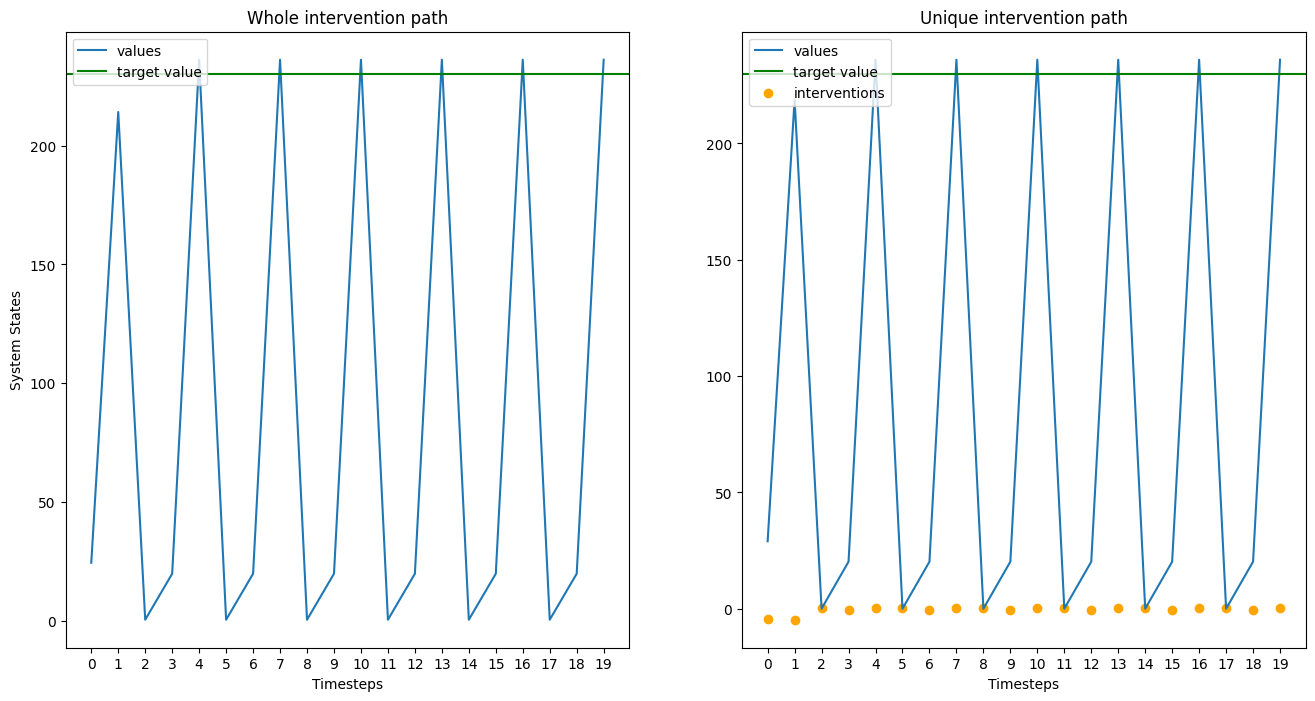

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t, label="target value", color="g")
ax1.legend(loc="upper left")
ax1.set_xticks(n)
ax1.set_xlabel("Timesteps")
ax1.set_title("Whole intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(testInt.values))
idx = np.argwhere(np.array(testInt.interventions) != 0).squeeze()

ax2.plot(n, testInt.values, label="values")
ax2.axhline(t, label="target value", color="g")
ax2.scatter(idx, [testInt.interventions[i] for i in idx], label="interventions", color="orange")

s_cnt = 0
for (s,t) in testInt.target_step:
  s_cnt += s
  ax2.scatter(s_cnt, t, color="g")

ax2.legend(loc="upper left")
ax2.set_xticks(n)
ax2.set_xlabel("Timesteps")
ax2.set_title("Unique intervention path")
;

##### Test 7: Logistic good fit

In [ ]:
data = make_samples(1, 50, g, g.max_val, noise=0.05, limit=True)
gConst= GraphConstructor(100, x=data[:-1], y=data[1:], min_val=0, max_val=1, automatic_padding="max")
data.max()
gConst.create_graph();

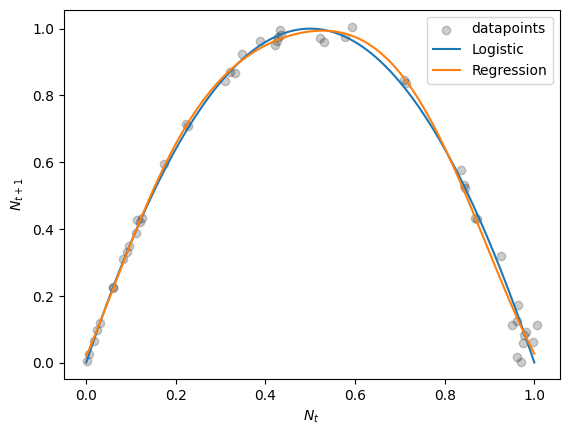

In [ ]:
n = np.linspace(0, 1, 200)

plt.scatter(data[:-1], data[1:], label="datapoints", color="k", alpha=0.2)
plt.plot(n, g(n), label="Logistic")
plt.plot(n, gConst.f(n), label="Regression")
plt.xlabel("$N_t$")
plt.ylabel("$N_{t+1}$")
plt.legend()
plt.show()

In [ ]:
# t = np.random.rand()
max_int = 0.02
testInt = Interventor(gConst, t, max_int)

all_vals = []
t

0.5801723692273323

In [ ]:
x = 0.1
for i in range(20):
    int_val, _ = testInt.intervention(x)
    print("Intervention: ", int_val)
    all_vals.append(x+int_val)
    x = g(x+int_val)
    print("Next value: ", x)
    print("")

Current node:  10
Shortest Path:  [58, 17, 94, 38, 10]
Expected Path Length: 5
Intervention:  0.006999999999999992
Next value:  0.382204

Current node:  38
Shortest Path:  [58, 17, 94, 38]
Expected Path Length: 4
Intervention:  0.005296000000000023
Next value:  0.9493750000000001

Current node:  94
Shortest Path:  [58, 17, 94]
Expected Path Length: 3
Intervention:  -0.0006250000000000977
Next value:  0.19449375000000008

Current node:  19
Shortest Path:  [58, 17, 94, 63, 19]
Expected Path Length: 5
Intervention:  -0.0007437500000000707
Next value:  0.62484375

Current node:  62
Best node:  63
Shortest Path:  [58, 17, 94, 63]
Expected Path Length: 4
Intervention:  0.012656250000000036
Next value:  0.924375

Current node:  92
Best node:  91
Shortest Path:  [58, 81, 27, 91]
Expected Path Length: 4
Intervention:  -0.008124999999999938
Next value:  0.30694374999999996

Current node:  30
Best node:  31
Shortest Path:  [58, 17, 94, 39, 87, 31]
Expected Path Length: 6
Intervention:  0.01055625

''

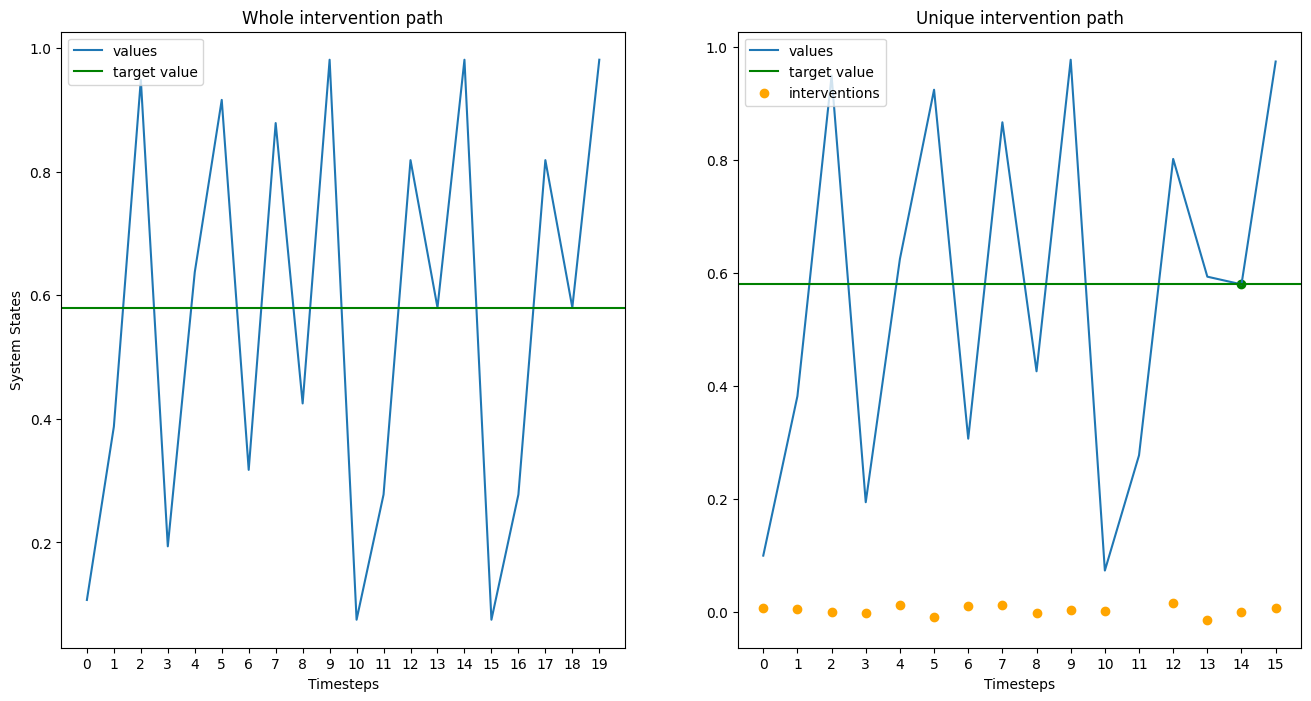

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t, label="target value", color="g")
ax1.legend(loc="upper left")
ax1.set_xticks(n)
ax1.set_xlabel("Timesteps")
ax1.set_title("Whole intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(testInt.values))
idx = np.argwhere(np.array(testInt.interventions) != 0).squeeze()

ax2.plot(n, testInt.values, label="values")
ax2.axhline(t, label="target value", color="g")
ax2.scatter(idx, [testInt.interventions[i] for i in idx], label="interventions", color="orange")

s_cnt = 0
for (s,t) in testInt.target_step:
  s_cnt += s
  ax2.scatter(s_cnt, t, color="g")

ax2.legend(loc="upper left")
ax2.set_xticks(n)
ax2.set_xlabel("Timesteps")
ax2.set_title("Unique intervention path")
;

##### Test 8: Logistic with Noise

In [ ]:
max_int = 0.03
testInt = Interventor(gConst, t, max_int)

all_vals = []

In [ ]:
x = 0.1
for i in range(20):
    int_val, _ = testInt.intervention(x)
    print("Intervention: ", int_val)
    all_vals.append(x+int_val)
    x = g(x+int_val)
    print("Next value: ", x)
    x *= 1 + 0.05 * (random.rand()*1.5-0.75)
    print("Next value with noise: ", x)
    print("")

Current node:  10
Shortest Path:  [58, 17, 94, 38, 10]
Expected Path Length: 5
Intervention:  0.006999999999999992
Next value:  0.382204
Next value with noise:  0.3836437588988719

Current node:  38
Shortest Path:  [58, 17, 94, 38]
Expected Path Length: 4
Intervention:  0.0038562411011280884
Next value:  0.9493750000000001
Next value with noise:  0.9168645455034284

Current node:  91
Shortest Path:  [58, 81, 27, 91]
Expected Path Length: 4
Intervention:  -0.000614545503428432
Next value:  0.30694374999999996
Next value with noise:  0.31000899869068654

Current node:  31
Shortest Path:  [58, 17, 94, 39, 87, 31]
Expected Path Length: 6
Intervention:  0.007491001309313461
Next value:  0.866775
Next value with noise:  0.896119884895588

Current node:  89
Best node:  91
Shortest Path:  [58, 81, 27, 91]
Expected Path Length: 4
Intervention:  0.020130115104411983
Next value:  0.30694374999999996
Next value with noise:  0.309282933484003

Current node:  30
Best node:  28
Shortest Path:  [58, 8

''

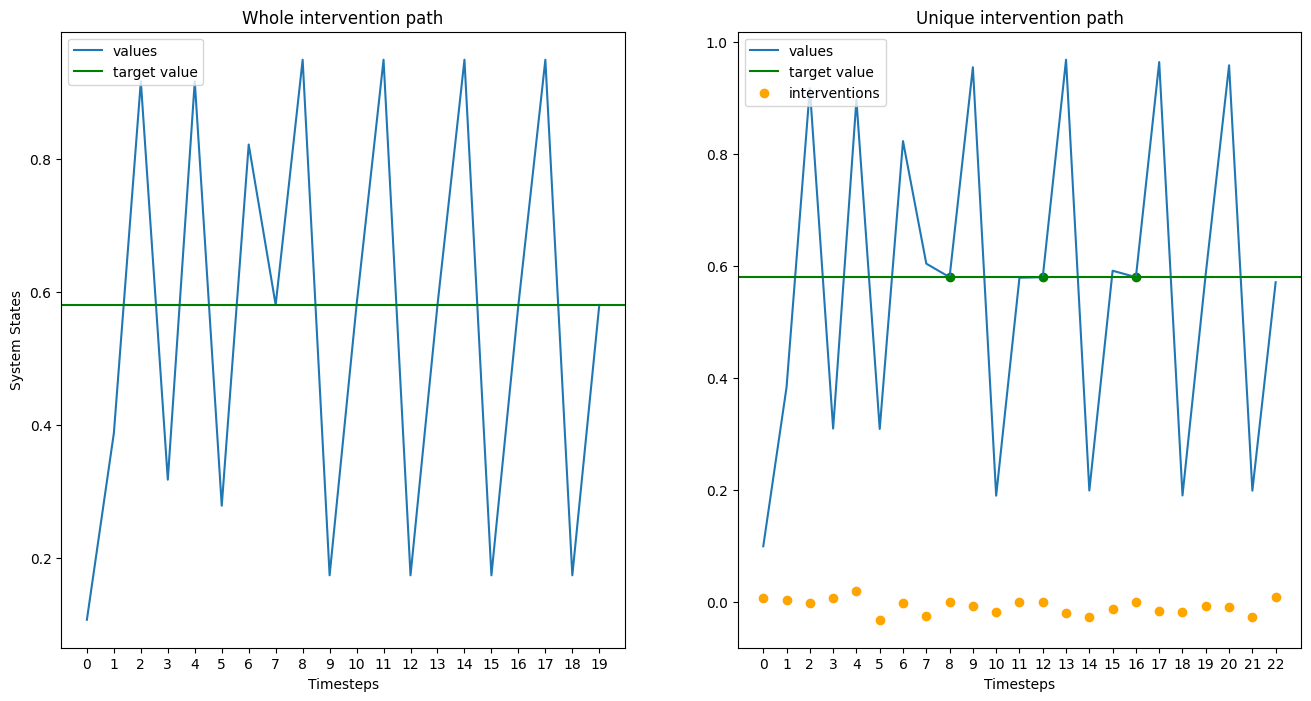

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t, label="target value", color="g")
ax1.legend(loc="upper left")
ax1.set_xticks(n)
ax1.set_xlabel("Timesteps")
ax1.set_title("Whole intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(testInt.values))
idx = np.argwhere(np.array(testInt.interventions) != 0).squeeze()

ax2.plot(n, testInt.values, label="values")
ax2.axhline(t, label="target value", color="g")
ax2.scatter(idx, [testInt.interventions[i] for i in idx], label="interventions", color="orange")

s_cnt = 0
for (s,t) in testInt.target_step:
  s_cnt += s
  ax2.scatter(s_cnt, t, color="g")

ax2.legend(loc="upper left")
ax2.set_xticks(n)
ax2.set_xlabel("Timesteps")
ax2.set_title("Unique intervention path")
;

##### Test 9: Logistic bad fit

In [ ]:
data = make_samples(1, 20, g, g.max_val, noise=0.05, limit=True)
gConst= GraphConstructor(100, x=data[:-1], y=data[1:], min_val=0, max_val=1, automatic_padding="max")
data.max()
gConst.create_graph();

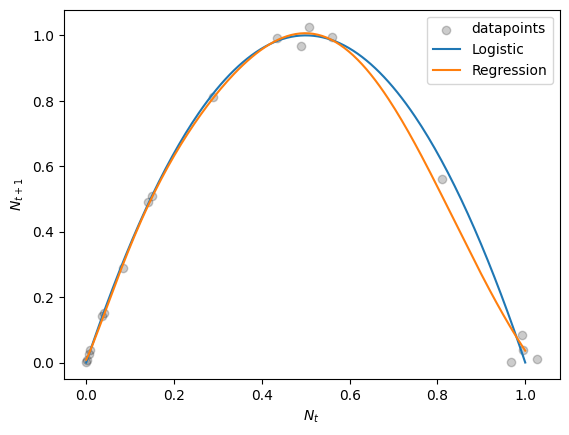

In [ ]:
n = np.linspace(0, 1, 200)

plt.scatter(data[:-1], data[1:], label="datapoints", color="k", alpha=0.2)
plt.plot(n, g(n), label="Logistic")
plt.plot(n, gConst.f(n), label="Regression")
plt.xlabel("$N_t$")
plt.ylabel("$N_{t+1}$")
plt.legend()
plt.show()

In [ ]:
max_int = 0.02
testInt = Interventor(gConst, t, max_int)

all_vals = []

In [ ]:
x = 0.1
for i in range(20):
    int_val, _ = testInt.intervention(x)
    print("Intervention: ", int_val)
    all_vals.append(x+int_val)
    x = g(x+int_val)
    print("Next value: ", x)
    print("")

Current node:  10
Using previous path.
Intervention:  0.006249999999999992
Next value:  0.37984375000000004

Current node:  37
Using previous path.
Intervention:  -0.0023437500000000333
Next value:  0.9399750000000001

Current node:  93
Using previous path.
Intervention:  -0.0037250000000000894
Next value:  0.2387437499999999

Current node:  23
Using previous path.
Intervention:  -0.003743749999999879
Next value:  0.7191000000000001

Current node:  71
Using previous path.
Intervention:  -0.015350000000000086
Next value:  0.83394375

Current node:  83
Using previous path.
Intervention:  -0.00019374999999999254
Next value:  0.55444375

Current node:  55
Using previous path.
Intervention:  -0.0019437500000000218
Next value:  0.988975

Current node:  98
Using previous path.
Intervention:  0.0026916666666665368
Next value:  0.03305555555555587

Current node:  3
Using previous path.
Intervention:  0.01594444444444413
Next value:  0.186396

Current node:  18
Using previous path.
Intervention:

''

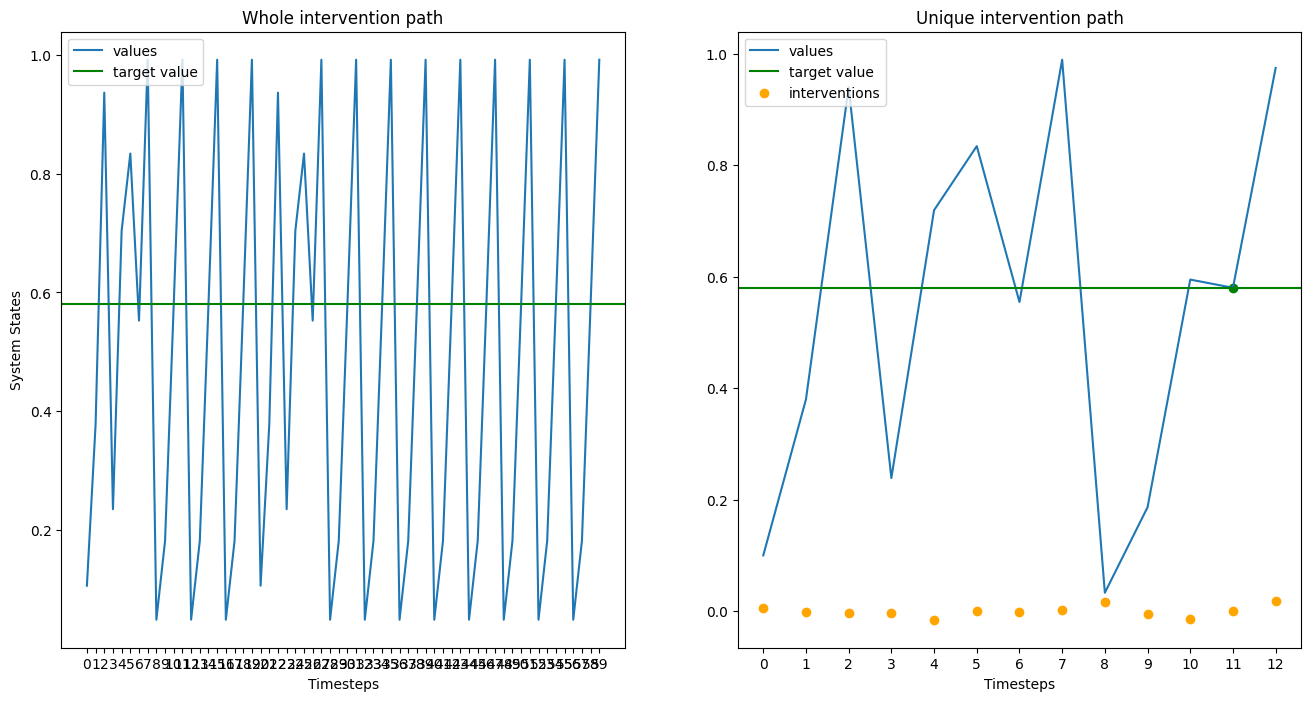

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t, label="target value", color="g")
ax1.legend(loc="upper left")
ax1.set_xticks(n)
ax1.set_xlabel("Timesteps")
ax1.set_title("Whole intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(testInt.values))
idx = np.argwhere(np.array(testInt.interventions) != 0).squeeze()

ax2.plot(n, testInt.values, label="values")
ax2.axhline(t, label="target value", color="g")
ax2.scatter(idx, [testInt.interventions[i] for i in idx], label="interventions", color="orange")

s_cnt = 0
for (s,t) in testInt.target_step:
  s_cnt += s
  ax2.scatter(s_cnt, t, color="g")

ax2.legend(loc="upper left")
ax2.set_xticks(n)
ax2.set_xlabel("Timesteps")
ax2.set_title("Unique intervention path")
;

##### Test 10: With Noise

In [ ]:
max_int = 0.06
testInt = Interventor(gConst, t, max_int)

all_vals = []

In [ ]:
x = 0.1
for i in range(20):
    int_val, _ = testInt.intervention(x)
    print("Intervention: ", int_val)
    all_vals.append(x+int_val)
    x = g(x+int_val)
    print("Next value: ", x)
    x *= 1 + 0.05 * (random.rand()*1.5-0.75)
    print("Next value with noise: ", x)
    print("")

Current node:  10
Best node:  5
Shortest Path:  [58, 18, 5]
Expected Path Length: 3
Intervention:  -0.04875
Next value:  0.19449375000000002
Next value with noise:  0.1886355347922334

Current node:  18
Shortest Path:  [58, 18]
Expected Path Length: 2
Intervention:  -0.006968868125566741
Next value:  0.5946555555555556
Next value with noise:  0.6018049232686355

Current node:  60
Best node:  58
Target reached using 3 steps
Intervention:  -0.021632554041303265
Next value:  0.9742895648499053
Next value with noise:  0.9936077293024723

Current node:  99
Shortest Path:  [58, 17, 4, 99]
Expected Path Length: 4
Intervention:  0.0013922706975276755
Next value:  0.01990000000000002
Next value with noise:  0.019549331794275086

Current node:  1
Best node:  4
Shortest Path:  [58, 17, 4]
Expected Path Length: 3
Intervention:  0.029450668205724916
Next value:  0.186396
Next value with noise:  0.17969895427172386

Current node:  17
Shortest Path:  [58, 17]
Expected Path Length: 2
Intervention:  -0

''

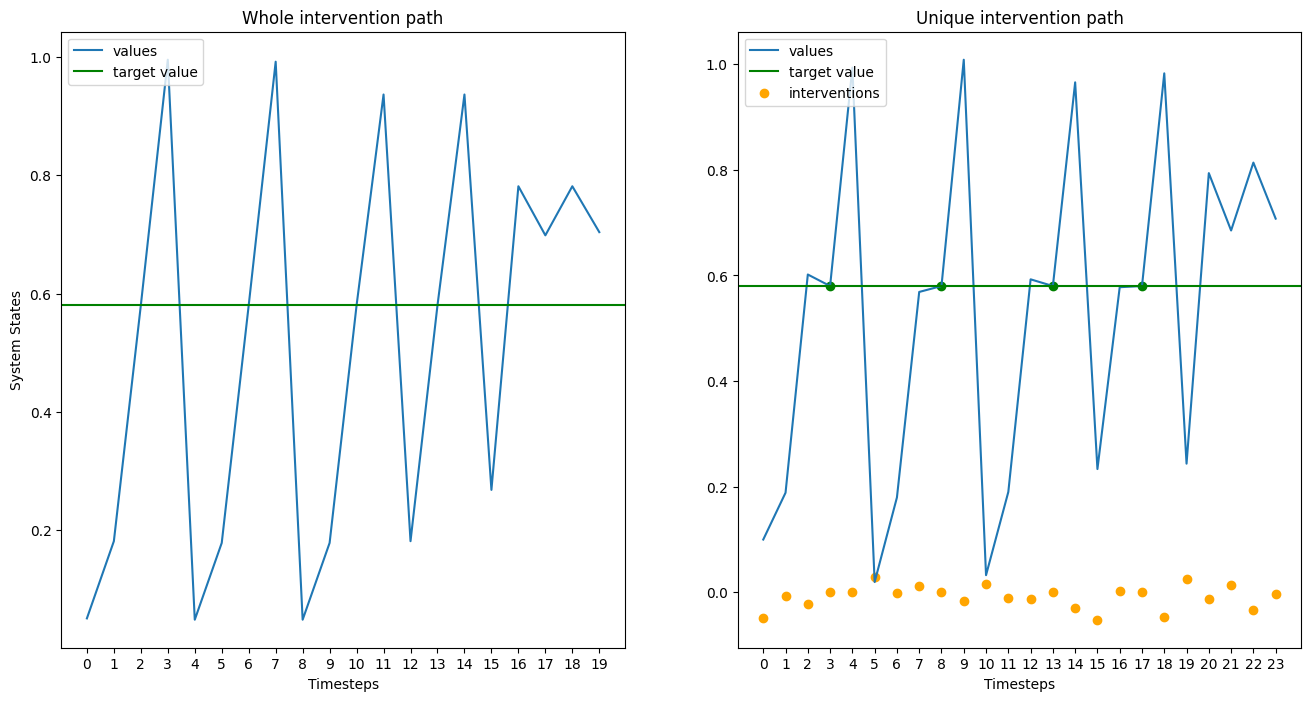

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t, label="target value", color="g")
ax1.legend(loc="upper left")
ax1.set_xticks(n)
ax1.set_xlabel("Timesteps")
ax1.set_title("Whole intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(testInt.values))
idx = np.argwhere(np.array(testInt.interventions) != 0).squeeze()

ax2.plot(n, testInt.values, label="values")
ax2.axhline(t, label="target value", color="g")
ax2.scatter(idx, [testInt.interventions[i] for i in idx], label="interventions", color="orange")

s_cnt = 0
for (s,t) in testInt.target_step:
  s_cnt += s
  ax2.scatter(s_cnt, t, color="g")

ax2.legend(loc="upper left")
ax2.set_xticks(n)
ax2.set_xlabel("Timesteps")
ax2.set_title("Unique intervention path")
;

### Finding Fixed Points

In [ ]:
class Stabilizer:

    def __init__(self, gConst, max_intervention=np.inf, buffer_size=5):
        self.gConst = gConst
        self.G = gConst.G
        self.e = gConst.e
        self.max_int = max_intervention

        # Find self-loops
        loops = list(nx.simple_cycles(self.G, 1))

        # No self-loops in graph
        if len(loops) == 0:
            print("No possible fixed points found!")
            return

        print("Possible fixed points:", loops)
        self.t_node = None
        while not [self.t_node] in loops:
            self.t_node = int(input("Choose point for stabilization: "))

        self.t_val = (self.t_node + 0.5) * self.e
        self.pivot = self.t_val
        self.prev_point_diff = np.inf
        self.interventor = Interventor(self.gConst, self.t_val, max_intervention)

        # Stable point approached Flag
        self.found = False
        # Current step of the search
        self.p_step = 0
        self.current_diff = 0
        # Step size modulator
        self.m = 0.5

        # List of all the targets tested
        self.targets = [self.t_val]
        # Buffer for filtering the noise
        self.buffer = np.zeros(buffer_size)
        self.b_size = buffer_size
        self.b_cnt = 0

        self.prev_reached = False

    def stabilize(self, x, epsilon=1e-3):

        # if point has been found, stop searching
        if self.found:
            int_val, _ = self.interventor.intervention(x)
            return int_val

        # If target was reached in previous step, save current value to buffer
        if self.prev_reached:
            self.buffer[self.b_cnt] = x
            self.b_cnt += 1

        # if buffer is not full continue intervention
        if self.b_cnt != self.b_size:
            int_val, self.prev_reached = self.interventor.intervention(x)
            return int_val

        #### if buffer is full try new target

        self.b_cnt = 0
        diff = abs(self.t_val - np.mean(self.buffer))
        print("Difference: ", diff)

        # if difference is smaller than epsilon, fixed point is found
        if diff < epsilon:
            print("Approached fixed point at", self.t_val)
            self.found = True
            int_val, _ = self.interventor.intervention(x)
            return int_val


        self._adjust_target(diff)

        self.interventor.update_target(self.t_val)
        int_val, self.prev_reached = self.interventor.intervention(x)

        # Save target for tracing
        self.targets.append(self.t_val)

        return int_val


    def _adjust_target(self, diff):

        print(f"Step: ", self.p_step)
        if self.p_step == 0:
            self._step0(diff)

        elif self.p_step == 1:
            self._step1(diff)

        elif self.p_step == 2:
            self._step2(diff)

        elif self.p_step == 3:
            self._step3(diff)

        self.t_val = np.clip(self.t_val, self.gConst.min, self.gConst.max)

  # Test direction
    def _step0(self, diff):
        self.pivot_diff = diff
        self.t_val = self.pivot + 0.1 * self.max_int * self.e
        self.p_step = 1

    def _step1(self, diff):
        if self.pivot_diff < diff:
                self.m *= -1

        self.pivot = self.t_val
        self.pivot_diff = diff
        self.t_val = self.pivot + self.m * self.e

        self.p_step = 2

    # Go in the direction until diff increases
    def _step2(self, diff):
        # If difference on one side is lower update pivot und set new target
        if self.pivot_diff > diff:
            self.pivot = self.t_val

            # Save value for comparison to the other side
            self.prev_point_diff = self.pivot_diff

            self.pivot_diff = diff
            self.t_val = self.pivot + self.m * self.e


        # otherwise keep pivot and halve step size
        # if difference to the first point was smaller check there
        elif self.prev_point_diff > diff:
            self.m /= 2
            self.t_val = self.pivot + self.m * self.e
            self.p_step = 3

        # if the difference on the second point was smaller check there
        else:
            self.m /= -2
            self.t_val = self.pivot + self.m * self.e
            self.p_step = 3


    # Close in on point
    def _step3(self, diff):

        if self.pivot_diff > diff:
            self.m /= -2
            self.pivot = self.t_val
            self.pivot_diff = diff
            self.t_val = self.pivot + self.m * self.e

        else:
            self.m /= 2
            self.t_val = self.pivot + self.m * self.e


#### Approximator

In [ ]:
class Approach:

    def __init__(self, t_val):
        self.p_step = 0
        self.t_vals = t_val
        self.m = 1
        self.e = 1
        self.pivot = t_val
        self.pivot_diff = 0
        self.prev_point_diff = np.inf

    def adjust_target(self, diff):

        print(f"Step: ", self.p_step)
        if self.p_step == 0:
            self._step0(diff)

        elif self.p_step == 1:
            self._step1(diff)

        elif self.p_step == 2:
            self._step2(diff)

        elif self.p_step == 3:
            self._step3(diff)

        return self.t_vals

  # Test direction
    def _step0(self, diff):
        self.pivot_diff = diff
        self.t_vals = self.pivot + 1e-2 * self.e
        self.p_step = 1

    def _step1(self, diff):
        if self.pivot_diff < diff:
                self.m *= -1

        self.pivot = self.t_vals
        self.pivot_diff = diff
        self.t_vals = self.pivot + self.m * self.e

        self.p_step = 2

    # Go in the direction until diff increases
    def _step2(self, diff):
        # If difference on one side is lower update pivot und set new target
        if self.pivot_diff > diff:
            self.pivot = self.t_vals

            # Save value for comparison to the other side
            self.prev_point_diff = self.pivot_diff

            self.pivot_diff = diff
            self.t_vals = self.pivot + self.m * self.e



        # otherwise keep pivot and halve step size
        # if difference to the first point was smaller check there
        elif self.prev_point_diff > diff:
            self.m /= 2
            self.t_vals = self.pivot + self.m * self.e
            self.p_step = 3

        # if the difference on the second point was smaller check there
        else:
            self.m /= -2
            self.t_vals = self.pivot + self.m * self.e
            self.p_step = 3


    # Close in on point
    def _step3(self, diff):

        if self.pivot_diff > diff:
            self.m /= -2
            self.pivot = self.t_vals
            self.pivot_diff = diff
            self.t_vals = self.pivot + self.m * self.e

        else:
            self.m /= 2
            self.t_vals = self.pivot + self.m * self.e

In [ ]:
target = 15.4
new_t = 11.99

appr = Approach(new_t)
diff = abs(target - new_t)


vals = [new_t]
for i in range(30):
  print(new_t, diff, appr.pivot, appr.pivot_diff)
  new_t = appr.adjust_target(diff)
  vals.append(new_t)
  diff = abs(new_t - target)

11.99 3.41 11.99 0
Step:  0
12.0 3.4000000000000004 11.99 3.41
Step:  1
13.0 2.4000000000000004 12.0 3.4000000000000004
Step:  2
14.0 1.4000000000000004 13.0 2.4000000000000004
Step:  2
15.0 0.40000000000000036 14.0 1.4000000000000004
Step:  2
16.0 0.5999999999999996 15.0 0.40000000000000036
Step:  2
15.5 0.09999999999999964 15.0 0.40000000000000036
Step:  3
15.25 0.15000000000000036 15.5 0.09999999999999964
Step:  3
15.375 0.025000000000000355 15.5 0.09999999999999964
Step:  3
15.4375 0.037499999999999645 15.375 0.025000000000000355
Step:  3
15.40625 0.006249999999999645 15.375 0.025000000000000355
Step:  3
15.390625 0.009375000000000355 15.40625 0.006249999999999645
Step:  3
15.3984375 0.0015625000000003553 15.40625 0.006249999999999645
Step:  3
15.40234375 0.0023437499999996447 15.3984375 0.0015625000000003553
Step:  3
15.400390625 0.00039062499999964473 15.3984375 0.0015625000000003553
Step:  3
15.3994140625 0.0005859375000003553 15.400390625 0.00039062499999964473
Step:  3
15.3999

#### Test 1: Ricker Function 1

In [ ]:
f = RickerFunction(K=58.34)
data = make_samples(1, 1000, f, f.max_val, noise=0.1)
gConst= GraphConstructor(200, x=data[:-1], y=data[1:], min_val=0, max_val=250, automatic_padding="max", verbose=False)
rm = gConst.get_regression_matrix(-1, force_new=True)
G = gConst.create_graph()

In [ ]:
x = 134
max_int = 5
stab = Stabilizer(gConst, max_int, buffer_size=1)
all_vals = []
all_ints = []
all_x = []
print("")
while not stab.found:
    int_val = stab.stabilize(x)
    all_ints.append(int_val)
    all_x.append(x)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Intervention: ", int_val)
    print("Next value: ", x)
    print("")

Possible fixed points: [[0], [46]]
Choose point for stabilization: 0

Current node:  107
Shortest Path:  [0, 107]
Expected Path Length: 2
Intervention:  0.375
Next value:  1.081548795221056

Current node:  0
Target reached using 2 steps
Intervention:  -0.45654879522105607
Next value:  24.297125318684316

Difference:  23.672125318684316
Step:  0
New target value 0.6375 in node 0
Current node:  19
Shortest Path:  [0, 167, 19]
Expected Path Length: 3
Intervention:  0.5778746813156843
Next value:  207.73388603610624

Current node:  166
Shortest Path:  [0, 166]
Expected Path Length: 2
Intervention:  0.3911139638937584
Next value:  0.015585347851749818

Current node:  0
Target reached using 3 steps
Intervention:  0.6219146521482501
Next value:  24.763428423862432

Difference:  24.125928423862433
Step:  1
New target value 0.012499999999999956 in node 0
Current node:  19
Shortest Path:  [0, 167, 19]
Expected Path Length: 3
Intervention:  0.11157157613756752
Next value:  207.73388603610624

Cur

''

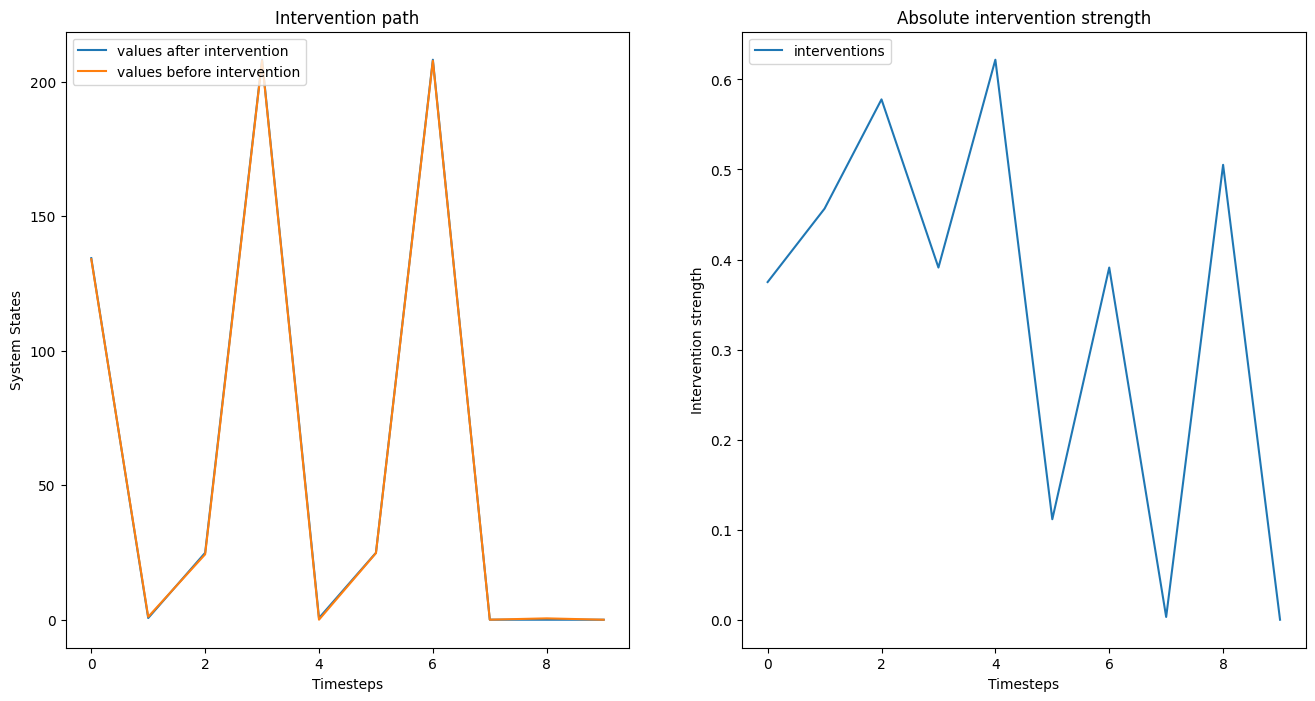

In [ ]:

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values after intervention")
ax1.plot(n, all_x, label="values before intervention")
ax1.legend(loc="upper left")

ax1.set_xlabel("Timesteps")
ax1.set_title("Intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(stab.interventor.values))
ax2.plot(np.abs(all_ints), label="interventions")
ax2.legend(loc="upper left")

ax2.set_xlabel("Timesteps")
ax2.set_ylabel("Intervention strength")
ax2.set_title("Absolute intervention strength")
;

###### Test 1: With Noise

In [ ]:
x = 134
max_int = 15
stab = Stabilizer(gConst, max_int, buffer_size=5)
all_vals = []
all_ints = []
all_x = []
print("")
i = 0
while ((not stab.found) or (len(all_ints) % 5 != 0)) and (i < 500):
    i += 1
    int_val = stab.stabilize(x, 0.1)
    all_ints.append(int_val)
    all_x.append(x)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Intervention: ", int_val)
    print("Next value: ", x)
    x *= 1 + 0.25 * (random.rand()*1.5-0.75)
    print("Next value with noise: ", x)
    print("")

if i >= 500:
    print("Aborted! Current target: ", stab.t_val)

Possible fixed points: [[0], [46]]
Choose point for stabilization: 0

Current node:  107
Shortest Path:  [0, 107]
Expected Path Length: 2
Intervention:  0.375
Next value:  1.081548795221056
Next value with noise:  1.2172447565467526

Current node:  0
Target reached using 2 steps
Intervention:  -0.5922447565467526
Next value:  24.297125318684316
Next value with noise:  25.75021196710338

Current node:  20
Shortest Path:  [0, 162, 20]
Expected Path Length: 3
Intervention:  0.3956213662299568
Next value:  201.43897712516187
Next value with noise:  168.14477428206274

Current node:  134
Shortest Path:  [0, 134]
Expected Path Length: 2
Intervention:  -0.019774282062741122
Next value:  0.15913502462712248
Next value with noise:  0.1864428557022665

Current node:  0
Target reached using 4 steps
Intervention:  0.4385571442977335
Next value:  24.297125318684316
Next value with noise:  21.087937925644454

Current node:  16
Shortest Path:  [0, 180, 16]
Expected Path Length: 3
Intervention:  0.005

''

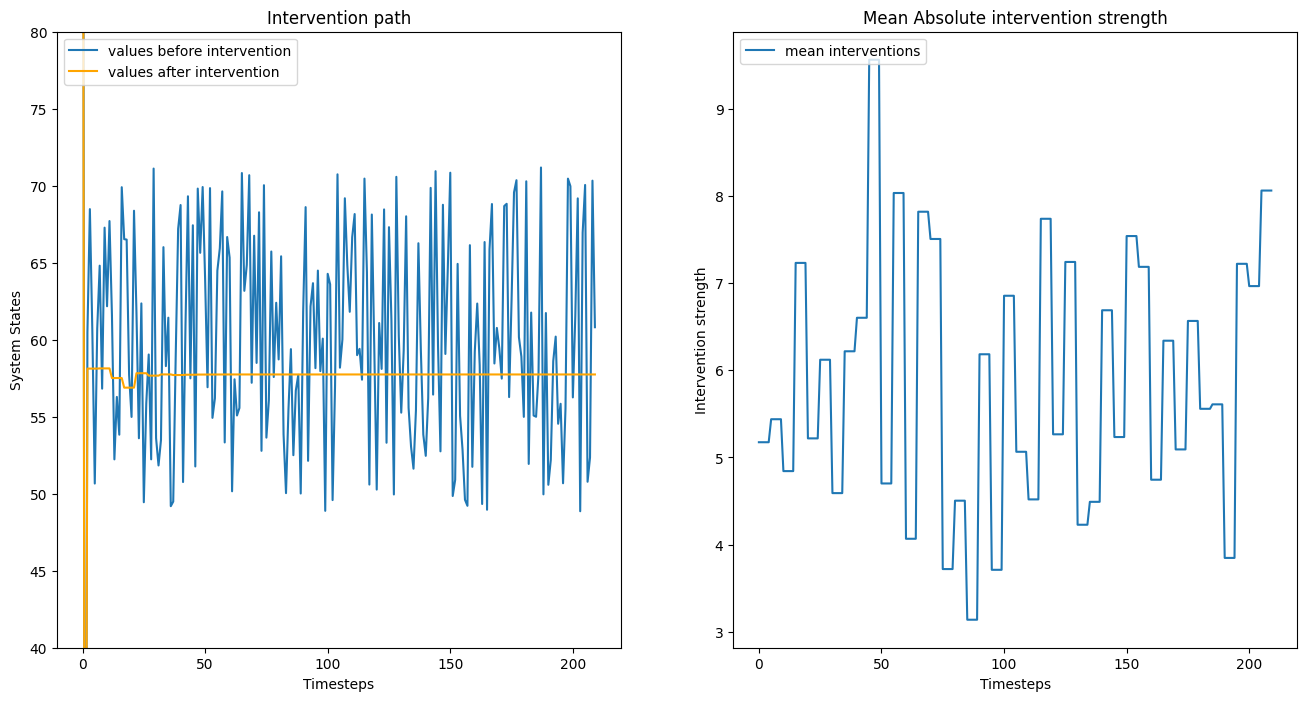

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_x, label="values before intervention", color="C0")
ax1.plot(n, all_vals, label="values after intervention", color="orange")

ax1.legend(loc="upper left")
ax1.set(ylim=(40, 80))

ax1.set_xlabel("Timesteps")
ax1.set_title("Intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(stab.interventor.values))
# ax2.plot(np.abs(all_ints), label="interventions")
ax2.plot(np.repeat(np.abs(all_ints).reshape(-1, 5).mean(-1),5), label="mean interventions")
ax2.legend(loc="upper left")

ax2.set_xlabel("Timesteps")
ax2.set_ylabel("Intervention strength")
ax2.set_title("Mean Absolute intervention strength")
;

###### Test 1: With Noise 2

In [ ]:
x = 134
max_int = 10
stab = Stabilizer(gConst, max_int, buffer_size=5)
all_vals = []
all_ints = []
all_x = []
print("")
while not stab.found or len(all_ints) % 5 != 0:
    int_val = stab.stabilize(x, 0.1)
    all_ints.append(int_val)
    all_x.append(x)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Intervention: ", int_val)
    print("Next value: ", x)
    x *= 1 + 0.15 * (random.rand()*1.5-0.75)
    print("Next value with noise: ", x)
    print("")

for _ in range(40):
    int_val = stab.stabilize(x, 0.1)
    all_ints.append(int_val)
    all_x.append(x)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    x *= 1 + 0.15 * (random.rand()*1.5-0.75)

Possible fixed points: [[0], [46]]
Choose point for stabilization: 46

Current node:  107
Best node:  100
Shortest Path:  [46, 1, 100]
Expected Path Length: 3
Intervention:  -8.375
Next value:  1.7612037816493105
Next value with noise:  1.7279913947340093

Current node:  1
Shortest Path:  [46, 1]
Expected Path Length: 2
Intervention:  -0.1850226447340093
Next value:  56.59107009117007
Next value with noise:  60.283978170363135

Current node:  48
Best node:  46
Target reached using 3 steps
Intervention:  -2.1589781703631346
Next value:  58.92299655989711
Next value with noise:  58.110454241183824

Current node:  46
Target reached using 2 steps
Intervention:  0.014545758816176146
Next value:  58.92299655989711
Next value with noise:  58.02048199572844

Current node:  46
Target reached using 2 steps
Intervention:  0.10451800427156144
Next value:  58.92299655989711
Next value with noise:  59.675892944350814

Current node:  47
Best node:  46
Target reached using 2 steps
Intervention:  -1.55

''

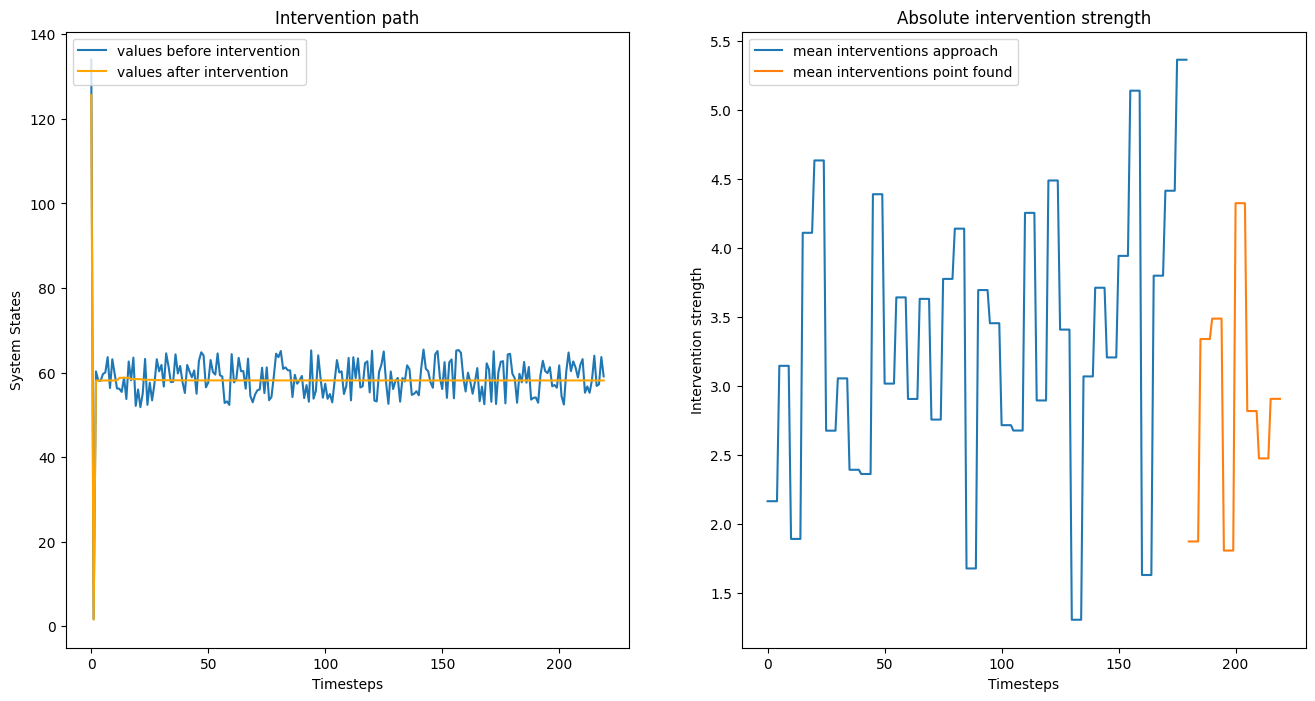

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_x, label="values before intervention", color="C0")
ax1.plot(n, all_vals, label="values after intervention", color="orange")
ax1.legend(loc="upper left")

ax1.set_xlabel("Timesteps")
ax1.set_title("Intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(all_ints))
ax2.plot(n[:-40], np.repeat(np.abs(all_ints[:-40]).reshape(-1, 5).mean(-1),5), label="mean interventions approach")
ax2.plot(n[-40:], np.repeat(np.abs(all_ints[-40:]).reshape(-1, 5).mean(-1),5), label="mean interventions point found")
ax2.legend(loc="upper left")

ax2.set_xlabel("Timesteps")
ax2.set_ylabel("Intervention strength")
ax2.set_title("Absolute intervention strength")
;

In [ ]:
testInt = Interventor(gConst, stab.targets[0], max_int)
means = []
x = 42

while not testInt.reached:
    int_val, _ = testInt.intervention(x)
    x = f(x+int_val)
    x *= 1 + 0.15 * (random.rand()*1.5-0.75)

for t in stab.targets:
    int_vals = []
    testInt.update_target(t)

    for _ in range(100):
        int_val, _ = testInt.intervention(x)
        int_vals.append(int_val)
        x = f(x+int_val)
        x *= 1 + 0.15 * (random.rand()*1.5-0.75)

    means.append(np.mean(int_vals))

print(stab.targets)
print(means)

Streaming output truncated to the last 5000 lines.
Target reached using 2 steps
Current node:  49
Best node:  46
Target reached using 2 steps
Current node:  49
Best node:  46
Target reached using 2 steps
Current node:  46
Target reached using 2 steps
Current node:  44
Best node:  46
Target reached using 2 steps
Current node:  47
Best node:  46
Target reached using 2 steps
Current node:  51
Best node:  46
Target reached using 2 steps
Current node:  48
Best node:  46
Target reached using 2 steps
Current node:  43
Best node:  46
Target reached using 2 steps
Current node:  49
Best node:  46
Target reached using 2 steps
Current node:  46
Target reached using 2 steps
Current node:  48
Best node:  46
Target reached using 2 steps
New target value 58.028564453125 in node 46
Current node:  49
Best node:  46
Target reached using 1 steps
Current node:  47
Best node:  46
Target reached using 2 steps
Current node:  50
Best node:  46
Target reached using 2 steps
Current node:  49
Best node:  46
Targe

#### Test 2: Logistic

In [ ]:
g = LogisticFunction(3.99)
data = make_samples(1, 1000, g, g.max_val, noise=0.05, limit=False)
gConst = GraphConstructor(50, x=data[:-1], y=data[1:], min_val=0, max_val=1, automatic_padding="max", verbose=False)
G = gConst.create_graph()

In [ ]:
x = 0.3
max_int = 0.05
stab = Stabilizer(gConst, max_int, buffer_size=1)
all_vals = []
all_ints = []
all_x = []
print("")
i = 0
while (not stab.found) and (i < 500):
    i += 1
    int_val = stab.stabilize(x)
    all_ints.append(int_val)
    all_x.append(x)
    all_vals.append(x+int_val)
    x = g(x+int_val)
    print("Intervention: ", int_val)
    print("Next value: ", x)
    # x *= 1 + 0.25 * (random.rand()*1.5-0.75)
    print("Next value with noise: ", x)
    print("")

if i >= 500:
    print("Aborted! Current target: ", stab.t_val)

Possible fixed points: [[37]]
Choose point for stabilization: 37

Current node:  14
Shortest Path:  [37, 12, 46, 30, 40, 14]
Expected Path Length: 6
Intervention:  -0.016666666666666663
Next value:  0.8101916666666668
Next value with noise:  0.8101916666666668

Current node:  40
Shortest Path:  [37, 12, 46, 30, 40]
Expected Path Length: 5
Intervention:  -0.002691666666666759
Next value:  0.6202205625
Next value with noise:  0.6202205625

Current node:  31
Shortest Path:  [37, 12, 46, 31]
Expected Path Length: 4
Intervention:  0.004779437499999983
Next value:  0.9351562500000001
Next value with noise:  0.9351562500000001

Current node:  46
Shortest Path:  [37, 12, 46]
Expected Path Length: 3
Intervention:  -0.007656250000000142
Next value:  0.26830256250000006
Next value with noise:  0.26830256250000006

Current node:  13
Best node:  12
Shortest Path:  [37, 12]
Expected Path Length: 2
Intervention:  -0.018302562500000064
Next value:  0.748125
Next value with noise:  0.748125

Current no

''

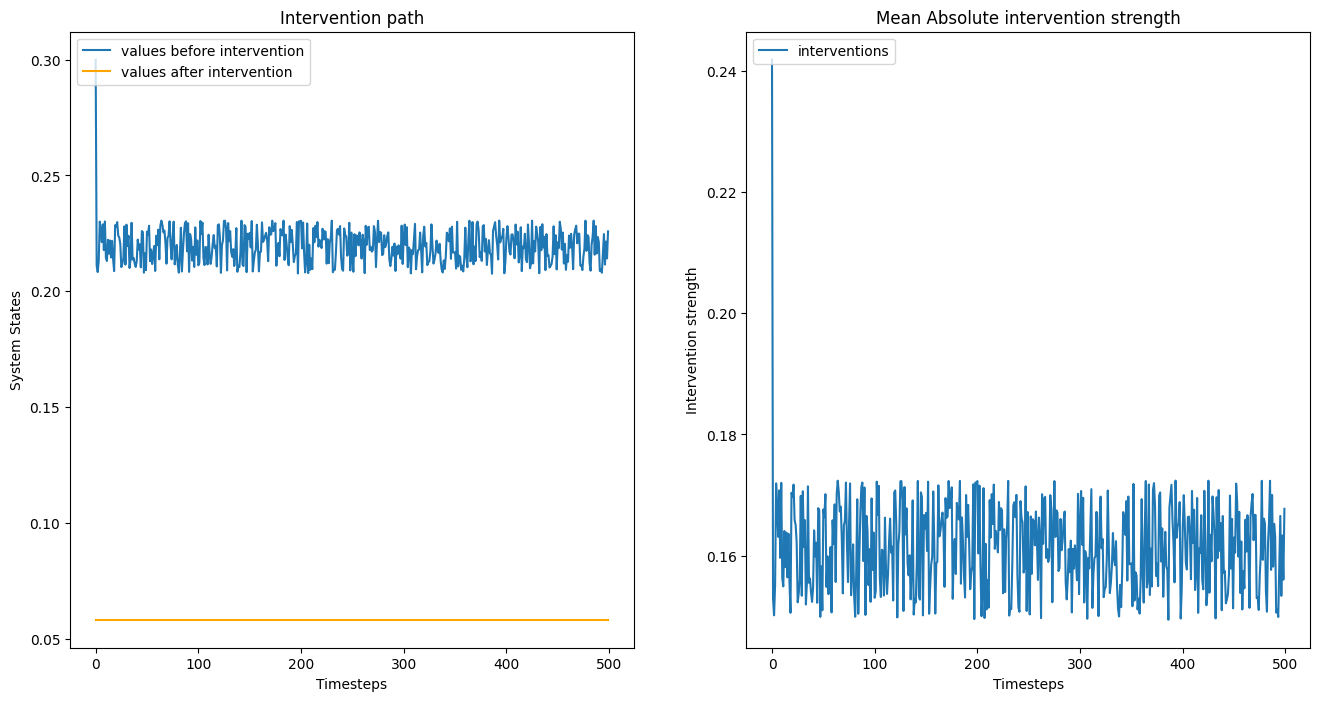

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_x, label="values before intervention", color="C0")
ax1.plot(n, all_vals, label="values after intervention", color="orange")

ax1.legend(loc="upper left")
# ax1.set(ylim=(40, 80))

ax1.set_xlabel("Timesteps")
ax1.set_title("Intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(stab.interventor.values))
ax2.plot(np.abs(all_ints), label="interventions")
# ax2.plot(np.repeat(np.abs(all_ints).reshape(-1, 5).mean(-1),5), label="mean interventions")
ax2.legend(loc="upper left")

ax2.set_xlabel("Timesteps")
ax2.set_ylabel("Intervention strength")
ax2.set_title("Mean Absolute intervention strength")
;

##### With noise

In [ ]:
x = 0.3
max_int = 0.05
stab = Stabilizer(gConst, max_int, buffer_size=20)
all_vals = []
all_ints = []
all_x = []
print("")
i = 0
while ((not stab.found) or (len(all_ints) % 5 != 0)) and (i < 700):
    i += 1
    int_val = stab.stabilize(x)
    all_ints.append(int_val)
    all_x.append(x)
    all_vals.append(x+int_val)
    x = g(x+int_val)
    print("Intervention: ", int_val)
    print("Next value: ", x)
    x *= 1 + 0.05 * (random.rand()*1.5-0.75)
    print("Next value with noise: ", x)
    print("")

if i >= 500:
    print("Aborted! Current target: ", stab.t_val)

Possible fixed points: [[37]]
Choose point for stabilization: 37

Current node:  14
Shortest Path:  [37, 12, 46, 31, 40, 14]
Expected Path Length: 6
Intervention:  -0.016666666666666663
Next value:  0.8101916666666668
Next value with noise:  0.8042135808089828

Current node:  40
Shortest Path:  [37, 12, 46, 31, 40]
Expected Path Length: 5
Intervention:  -0.001713580808982762
Next value:  0.6323900625000001
Next value with noise:  0.628275622238466

Current node:  31
Shortest Path:  [37, 12, 46, 31]
Expected Path Length: 4
Intervention:  0.006724377761534006
Next value:  0.92478225
Next value with noise:  0.924176951217654

Current node:  46
Shortest Path:  [37, 12, 46]
Expected Path Length: 3
Intervention:  0.0033230487823460164
Next value:  0.26830256250000006
Next value with noise:  0.2616092087783364

Current node:  13
Best node:  12
Shortest Path:  [37, 12]
Expected Path Length: 2
Intervention:  -0.011609208778336377
Next value:  0.748125
Next value with noise:  0.7454581242349673


''

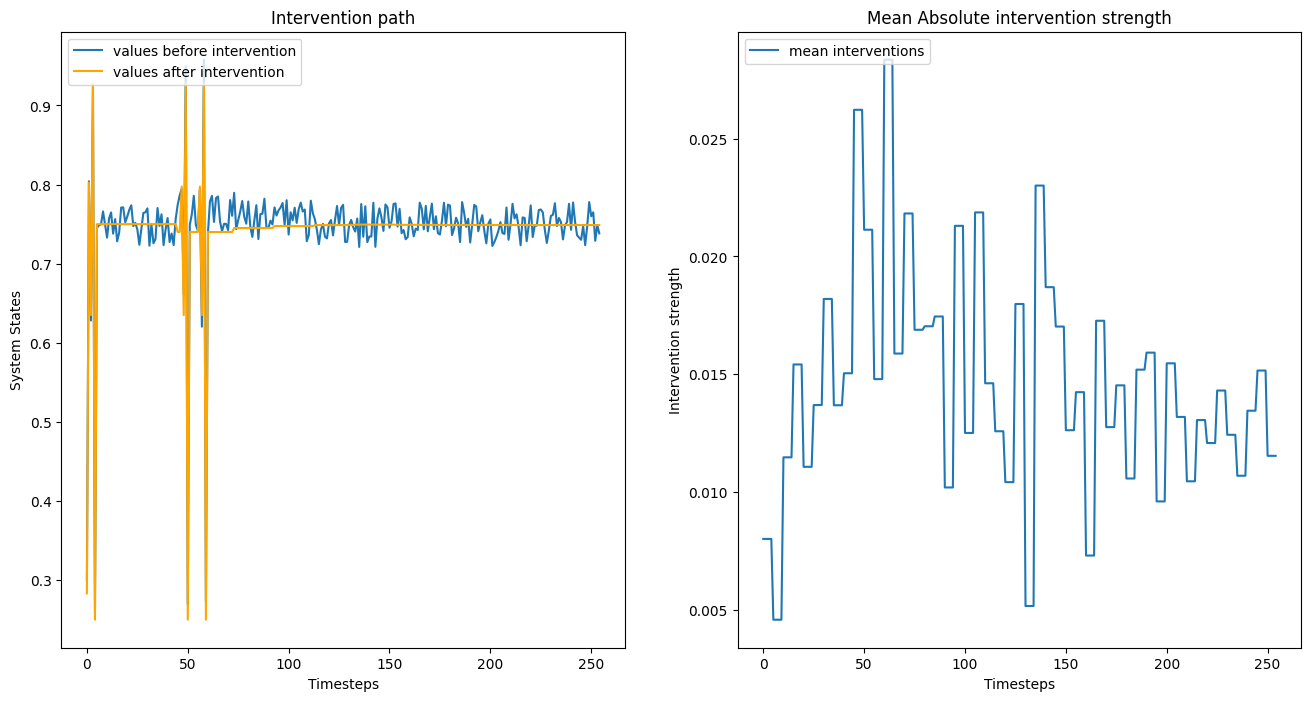

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_x, label="values before intervention", color="C0")
ax1.plot(n, all_vals, label="values after intervention", color="orange")

ax1.legend(loc="upper left")
# ax1.set(ylim=(40, 80))

ax1.set_xlabel("Timesteps")
ax1.set_title("Intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(stab.interventor.values))
# ax2.plot(np.abs(all_ints), label="interventions")
ax2.plot(np.repeat(np.abs(all_ints).reshape(-1, 5).mean(-1),5), label="mean interventions")
ax2.legend(loc="upper left")

ax2.set_xlabel("Timesteps")
ax2.set_ylabel("Intervention strength")
ax2.set_title("Mean Absolute intervention strength")
;

#### Test 3: Ricker Function low sample size

In [ ]:
f = RickerFunction(K=58.34)
data = make_samples(1, 30, f, f.max_val, noise=0.1)
gConst= GraphConstructor(200, x=data[:-1], y=data[1:], min_val=0, max_val=250, automatic_padding="max", verbose=False)
rm = gConst.get_regression_matrix(-1, force_new=True)
G = gConst.create_graph()

In [ ]:
x = 134
max_int = 15
stab = Stabilizer(gConst, max_int, buffer_size=1)
all_vals = []
all_ints = []
all_x = []
print("")
i = 0
while not stab.found and i <= 300:
    i += 1
    int_val = stab.stabilize(x)
    all_ints.append(int_val)
    all_x.append(x)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Intervention: ", int_val)
    print("Next value: ", x)
    print("")

if not stab.found:
    print("Aborted! Current target: ", stab.t_val)

Possible fixed points: [[0], [46]]
Choose point for stabilization: 46

Current node:  107
Best node:  96
Shortest Path:  [46, 1, 96]
Expected Path Length: 3
Intervention:  -13.0625
Next value:  2.282468652095133

Current node:  1
Shortest Path:  [46, 1]
Expected Path Length: 2
Intervention:  -0.6096745344480743
Next value:  60.849556813398586

Current node:  48
Best node:  46
Target reached using 3 steps
Intervention:  -2.7245568133985856
Next value:  58.92299655989711

Difference:  0.7979965598971077
Step:  0
New target value 60.0 in node 48
Current node:  47
Best node:  48
Target reached using 1 steps
Intervention:  1.0770034401028923
Next value:  54.00438060461469

Difference:  5.995619395385312
Step:  1
New target value 59.375 in node 47
Current node:  43
Best node:  47
Target reached using 1 steps
Intervention:  5.370619395385312
Next value:  55.60272399447168

Difference:  3.772276005528319
Step:  2
New target value 58.75 in node 47
Current node:  44
Best node:  47
Target reached

''

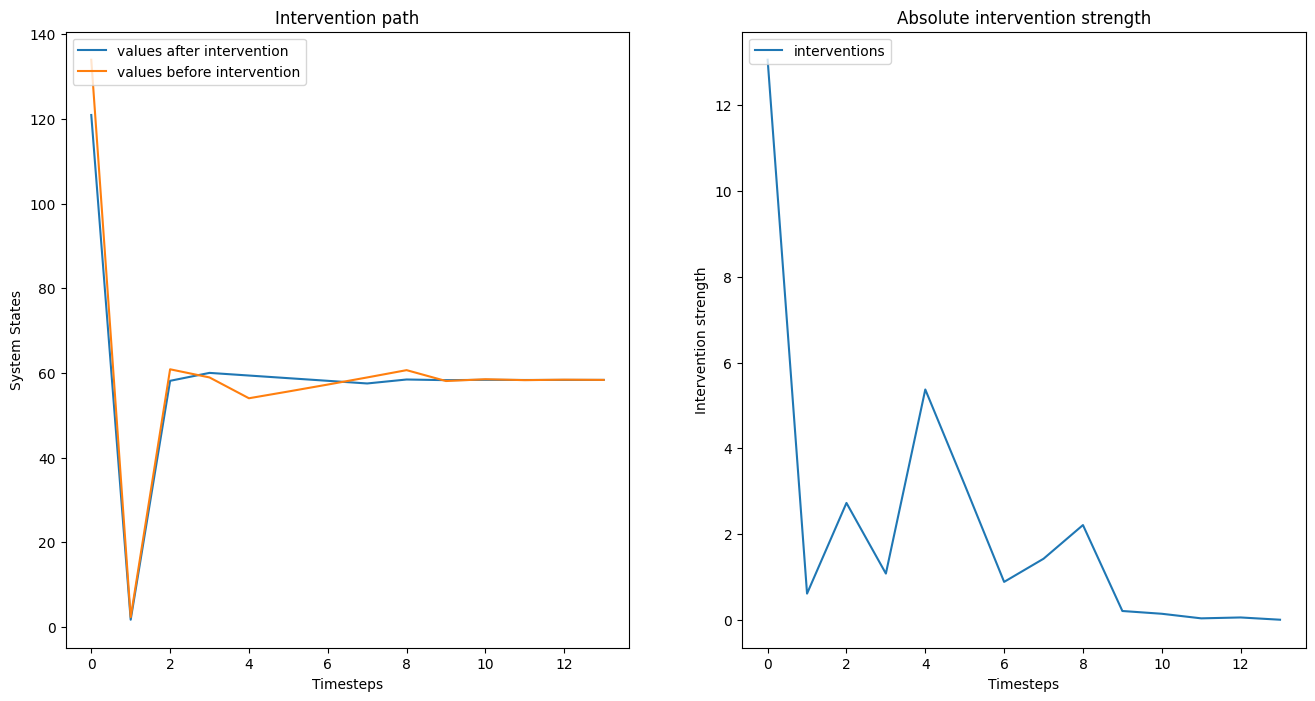

In [ ]:

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values after intervention")
ax1.plot(n, all_x, label="values before intervention")
ax1.legend(loc="upper left")

ax1.set_xlabel("Timesteps")
ax1.set_title("Intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(stab.interventor.values))
ax2.plot(np.abs(all_ints), label="interventions")
ax2.legend(loc="upper left")

ax2.set_xlabel("Timesteps")
ax2.set_ylabel("Intervention strength")
ax2.set_title("Absolute intervention strength")
;

###### Test 3.1: With Noise

In [ ]:
x = 134
max_int = 15
stab = Stabilizer(gConst, max_int, buffer_size=21)
all_vals = []
all_ints = []
all_x = []
print("")
i = 0
while ((not stab.found) or (len(all_ints) % 5 != 0)) and (i < 500):
    i += 1
    int_val = stab.stabilize(x, 0.1)
    all_ints.append(int_val)
    all_x.append(x)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Intervention: ", int_val)
    print("Next value: ", x)
    x *= 1 + 0.25 * (random.rand()*1.5-0.75)
    print("Next value with noise: ", x)
    print("")

if i >= 500:
    print("Aborted! Current target: ", stab.t_val)

Possible fixed points: [[0], [46]]
Choose point for stabilization: 46

Current node:  107
Best node:  96
Shortest Path:  [46, 1, 96]
Expected Path Length: 3
Intervention:  -13.0625
Next value:  2.282468652095133
Next value with noise:  2.6149325870443945

Current node:  2
Best node:  1
Shortest Path:  [46, 1]
Expected Path Length: 2
Intervention:  -0.9421384693973356
Next value:  60.849556813398586
Next value with noise:  62.52085069933613

Current node:  50
Best node:  46
Target reached using 3 steps
Intervention:  -4.39585069933613
Next value:  58.92299655989711
Next value with noise:  61.27357067867015

Current node:  49
Best node:  46
Target reached using 2 steps
Intervention:  -3.148570678670147
Next value:  58.92299655989711
Next value with noise:  51.60876794392832

Current node:  41
Best node:  46
Target reached using 2 steps
Intervention:  6.516232056071679
Next value:  58.92299655989711
Next value with noise:  66.8284061965884

Current node:  53
Best node:  46
Target reached 

''

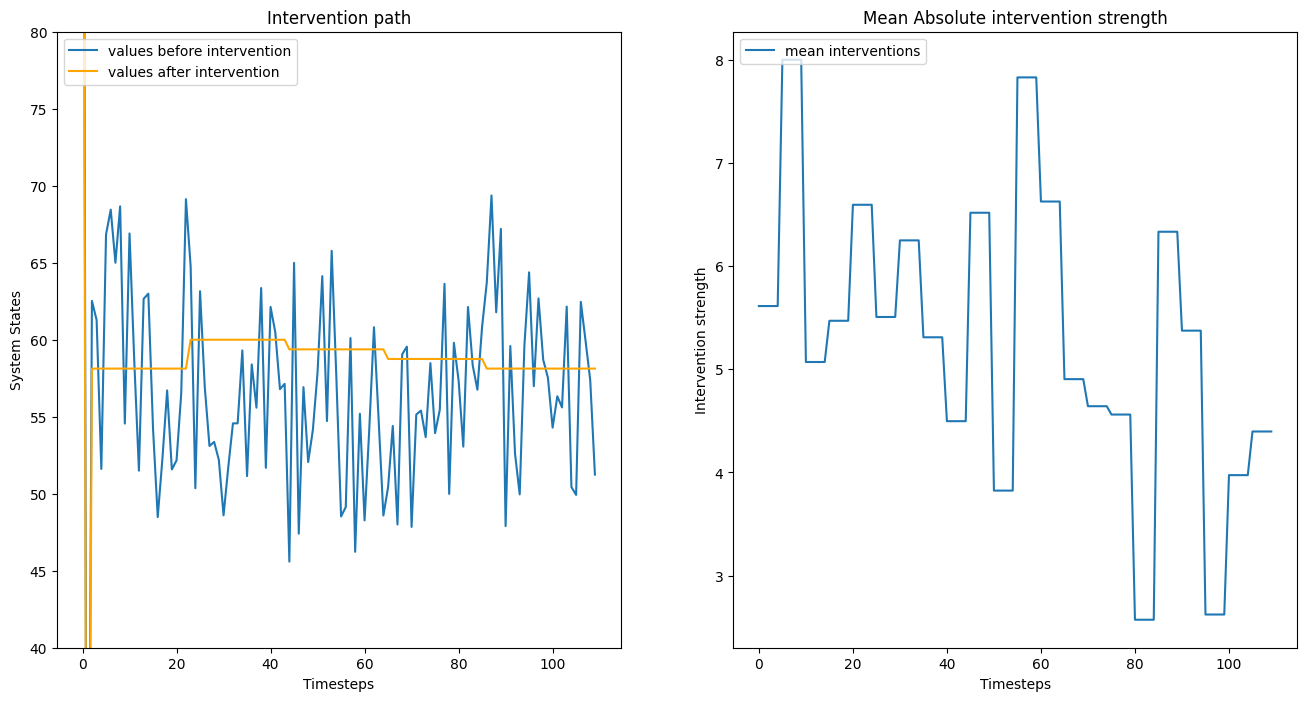

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_x, label="values before intervention", color="C0")
ax1.plot(n, all_vals, label="values after intervention", color="orange")

ax1.legend(loc="upper left")
ax1.set(ylim=(40, 80))

ax1.set_xlabel("Timesteps")
ax1.set_title("Intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(stab.interventor.values))
# ax2.plot(np.abs(all_ints), label="interventions")
ax2.plot(np.repeat(np.abs(all_ints).reshape(-1, 5).mean(-1),5), label="mean interventions")
ax2.legend(loc="upper left")

ax2.set_xlabel("Timesteps")
ax2.set_ylabel("Intervention strength")
ax2.set_title("Mean Absolute intervention strength")
;

###### Test 3.2: With Noise 2

In [ ]:
x = 134
max_int = 10
stab = Stabilizer(gConst, max_int, buffer_size=5)
all_vals = []
all_ints = []
all_x = []
print("")
while not stab.found or len(all_ints) % 5 != 0:
    int_val = stab.stabilize(x, 0.1)
    all_ints.append(int_val)
    all_x.append(x)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Intervention: ", int_val)
    print("Next value: ", x)
    x *= 1 + 0.15 * (random.rand()*1.5-0.75)
    print("Next value with noise: ", x)
    print("")

for _ in range(40):
    int_val = stab.stabilize(x, 0.1)
    all_ints.append(int_val)
    all_x.append(x)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    x *= 1 + 0.15 * (random.rand()*1.5-0.75)

Possible fixed points: [[0], [46]]
Choose point for stabilization: 46

Current node:  107
Best node:  100
Shortest Path:  [46, 1, 100]
Expected Path Length: 3
Intervention:  -8.375
Next value:  1.7612037816493105
Next value with noise:  1.7279913947340093

Current node:  1
Shortest Path:  [46, 1]
Expected Path Length: 2
Intervention:  -0.1850226447340093
Next value:  56.59107009117007
Next value with noise:  60.283978170363135

Current node:  48
Best node:  46
Target reached using 3 steps
Intervention:  -2.1589781703631346
Next value:  58.92299655989711
Next value with noise:  58.110454241183824

Current node:  46
Target reached using 2 steps
Intervention:  0.014545758816176146
Next value:  58.92299655989711
Next value with noise:  58.02048199572844

Current node:  46
Target reached using 2 steps
Intervention:  0.10451800427156144
Next value:  58.92299655989711
Next value with noise:  59.675892944350814

Current node:  47
Best node:  46
Target reached using 2 steps
Intervention:  -1.55

''

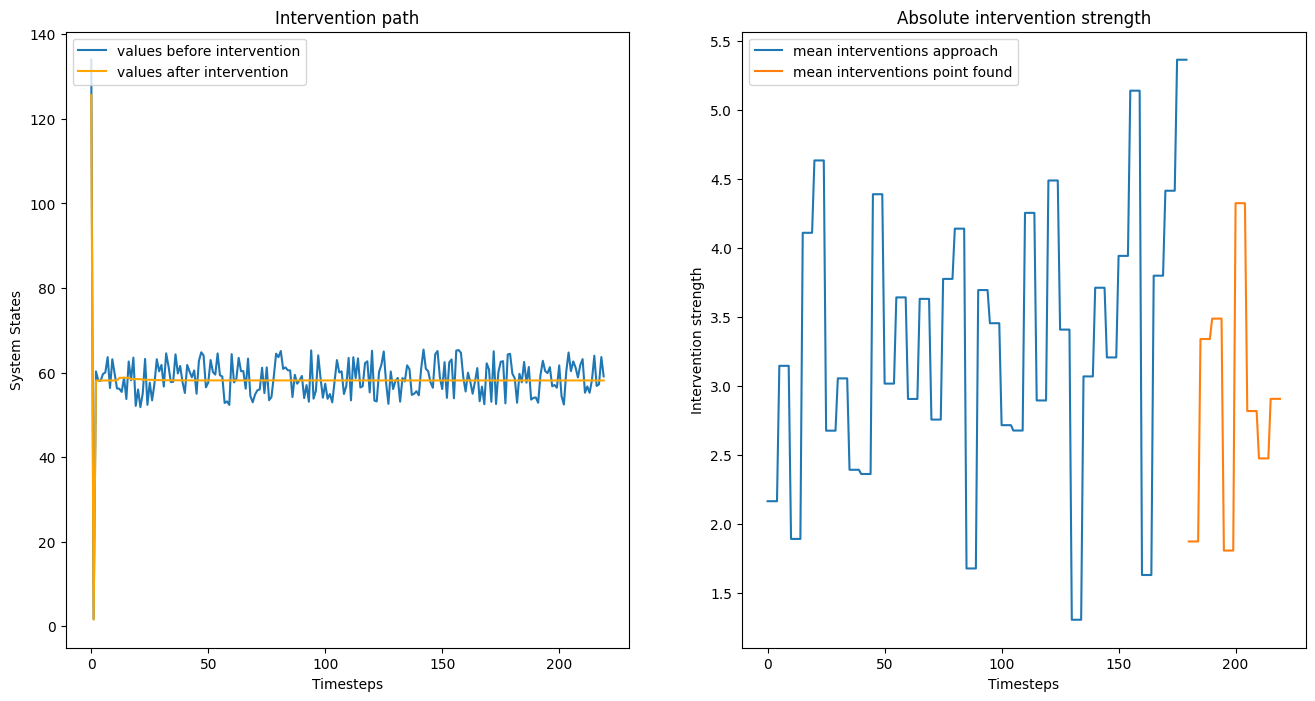

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

n = np.arange(len(all_vals))
ax1.plot(n, all_x, label="values before intervention", color="C0")
ax1.plot(n, all_vals, label="values after intervention", color="orange")
ax1.legend(loc="upper left")

ax1.set_xlabel("Timesteps")
ax1.set_title("Intervention path")
ax1.set_ylabel("System States")

n = np.arange(len(all_ints))
ax2.plot(n[:-40], np.repeat(np.abs(all_ints[:-40]).reshape(-1, 5).mean(-1),5), label="mean interventions approach")
ax2.plot(n[-40:], np.repeat(np.abs(all_ints[-40:]).reshape(-1, 5).mean(-1),5), label="mean interventions point found")
ax2.legend(loc="upper left")

ax2.set_xlabel("Timesteps")
ax2.set_ylabel("Intervention strength")
ax2.set_title("Absolute intervention strength")
;

In [ ]:
testInt = Interventor(gConst, stab.targets[0], max_int)
means = []
x = 42

while not testInt.reached:
    int_val, _ = testInt.intervention(x)
    x = f(x+int_val)
    x *= 1 + 0.15 * (random.rand()*1.5-0.75)

for t in stab.targets:
    int_vals = []
    testInt.update_target(t)

    for _ in range(100):
        int_val, _ = testInt.intervention(x)
        int_vals.append(int_val)
        x = f(x+int_val)
        x *= 1 + 0.15 * (random.rand()*1.5-0.75)

    means.append(np.mean(int_vals))

print(stab.targets)
print(means)

Streaming output truncated to the last 5000 lines.
Target reached using 2 steps
Current node:  49
Best node:  46
Target reached using 2 steps
Current node:  49
Best node:  46
Target reached using 2 steps
Current node:  46
Target reached using 2 steps
Current node:  44
Best node:  46
Target reached using 2 steps
Current node:  47
Best node:  46
Target reached using 2 steps
Current node:  51
Best node:  46
Target reached using 2 steps
Current node:  48
Best node:  46
Target reached using 2 steps
Current node:  43
Best node:  46
Target reached using 2 steps
Current node:  49
Best node:  46
Target reached using 2 steps
Current node:  46
Target reached using 2 steps
Current node:  48
Best node:  46
Target reached using 2 steps
New target value 58.028564453125 in node 46
Current node:  49
Best node:  46
Target reached using 1 steps
Current node:  47
Best node:  46
Target reached using 2 steps
Current node:  50
Best node:  46
Target reached using 2 steps
Current node:  49
Best node:  46
Targe

### Stabilizing Loops

In [ ]:
class LoopStabilizer:

    def __init__(self, gConst, target, max_intervention, loop_length=None, max_loop_length=5, buffer_size=5, starting_m=0.5):
        self.gConst = gConst
        self.G = gConst.create_graph()
        self.target = target
        self.max_int = max_intervention
        self.max_loop_length = max_loop_length
        self.buffer_size = buffer_size
        self.loops = None
        self.loop_len = 0

        # Set loop
        self._find_loops(target, loop_length, max_loop_length)


        # Assign target values and set of interventors
        self._get_first_targets()

        # Helpers
        self.found = False
        self.int_idx = self.l - 1
        self.prev_reached = False

        self.p_step = np.zeros(self.l)
        self.pivot = self.t_vals.copy()
        self.pivot_diff = np.zeros(self.l)
        self.prev_point_diff = np.ones(self.l)*np.inf
        self.m = np.ones(self.l) * starting_m


        self.all_targets = [[self.t_vals[i]] for i in range(self.l)]


    def _find_loops(self, target, loop_length=None, max_loop_length=5):

        # Find all loops up to a certain length
        if self.loops is None or self.loop_len < max_loop_length:
            self.loop_len = max_loop_length
            self._all_loops = list(nx.simple_cycles(self.G, max_loop_length))


        # get relevant loops
        self.rel_loops = self._find_loops_target(target)
        if not loop_length is None:
            self._select_length(loop_length)


        # Show and choose loop
        for i, l in enumerate(self.rel_loops):
            print(i, ": ", l)

        self.t_loop = None
        nbr = -1
        while not 0 <= nbr < len(self.rel_loops):
            nbr = int(input("Choose loop for stabilization (Number): "))

        # Select loop and put the node of the target value in the first spot
        idx = self.rel_loops[nbr].index(self.t_node)
        self.t_loop = self.rel_loops[nbr][idx:] + self.rel_loops[nbr][:idx]
        self.l = len(self.t_loop)


    def _find_loops_target(self, target):
        """ Finds the loops which contain the node where the target resides
        Args:
            target (int): Desired value
        """
        self.t_node = self.gConst.get_node(target)
        lps = []
        print("Target node: ", self.t_node)
        for l in self._all_loops:
            if self.t_node in l:
                lps.append(l)

        return lps


    def _select_length(self, loop_length):
        """ Function to select the loops with a certain length
        Args:
            loop_length (int): Length of the loops to select
        """

        tmp_loops = []
        for l in self.rel_loops:
            if len(l) == loop_length:
                tmp_loops.append(l)

        rel_loops = tmp_loops


    def _get_first_targets(self):
        """ Uses the inverse approximation implemented in the Interventor class to find the initial targets for the loop
        """

        self.ints = [Interventor(self.gConst, self.target, self.max_int)]
        self.t_vals = [self.target]

        # helpers
        self.buffer = np.zeros((self.l, self.buffer_size))
        self.b_cnt = np.zeros(self.l, dtype=int)


        for i in range(1, self.l):
            n_0 = self.t_loop[i]
            n_1 = self.t_loop[(i+1)%self.l]
            trans_val = self.gConst.node_inverse(n_0, n_1)
            self.t_vals.append(trans_val)
            self.ints.append(Interventor(self.gConst, trans_val, self.max_int))



    def stabilize(self, x, min_m=1e-5):
        """ Organizes the stabilization and calculates interventions
        Args:
            x (float): Current state of the system
            min_m (float): Minimal value of the modulator m
  	    """

        # If loop has been approached sufficiently
        if (self.found or abs(self.m[self.int_idx]) <= min_m) and self.prev_reached:
            self.int_idx = (self.int_idx + 1) % self.l

        elif self.prev_reached:
            # Target has been reached previously. Therefore save current value
            self.buffer[self.int_idx, self.b_cnt[self.int_idx]] = x
            self.b_cnt[self.int_idx] += 1


            # Buffer has been filled
            if self.b_cnt[self.int_idx] == self.buffer_size:
                # Get previous index
                i = self.int_idx
                self.int_idx = (self.int_idx + 1) % self.l
                self.b_cnt[i] = 0

                # Compare resulting mean with the target of the next interventor
                # In the case of the interventor towards the target always use the target!
                if i == self.l-1:
                    diff = abs(self.target - np.mean(self.buffer[i]))
                else:
                    diff = abs(self.t_vals[self.int_idx] - np.mean(self.buffer[i]))

                # adjust and update target of interventor
                self._adjust_target(i, diff)

                # if condition is met stop searching
                if all(np.abs(self.m) < min_m):
                    self.found = True
            else:
                # if the buffer is not full go on with the cycle
                self.int_idx = (self.int_idx + 1) % self.l

        # Calculate interventoin
        int_val, self.prev_reached = self.ints[self.int_idx].intervention(x)

        return int_val


    def _adjust_target(self, i, diff):
        """ Approaches and updates the target for a given interventor number based on the difference to the next target
        Args:
            i (int): Number of the interventor
            diff (float): Difference between the buffer mean and the next target
        """

        if self.p_step[i] == 0:
            self._step0(i, diff)

        elif self.p_step[i] == 1:
            self._step1(i, diff)

        elif self.p_step[i] == 2:
            self._step2(i, diff)

        elif self.p_step[i] == 3:
            self._step3(i, diff)

        self.t_vals[i] = np.clip(self.t_vals[i], gConst.min, gConst.max)
        # Update interventor with new target
        self.ints[i].update_target(self.t_vals[i])
        # Save new target for tracking
        self.all_targets[i].append(self.t_vals[i])

    # Test direction
    def _step0(self, i, diff):
        self.pivot_diff[i] = diff
        self.t_vals[i] = self.pivot[i] + 1e-2 * self.max_int
        self.p_step[i] = 1

    # Set direction
    def _step1(self, i, diff):
        if self.pivot_diff[i] < diff:
                self.m[i] *= -1

        self.pivot[i] = self.t_vals[i]
        self.pivot_diff[i] = diff
        self.t_vals[i] = self.pivot[i] + self.m[i] * self.gConst.e

        self.p_step[i] = 2

    # Go in the direction until diff increases
    def _step2(self, i, diff):
        # If difference on one side is lower update pivot und set new target
        if self.pivot_diff[i] > diff:
            self.pivot[i] = self.t_vals[i]

            # Save value for comparison to the other side
            self.prev_point_diff[i] = self.pivot_diff[i]

            self.pivot_diff[i] = diff
            self.t_vals[i] = self.pivot[i] + self.m[i] * self.gConst.e


        # otherwise keep pivot and halve step size
        # if difference to the first point was smaller check there
        elif self.prev_point_diff[i] > diff:
            self.m[i] /= 2
            self.t_vals[i] = self.pivot[i] + self.m[i] * self.gConst.e
            self.p_step[i] = 3

        # if the difference on the second point was smaller check there
        else:
            self.m[i] /= -2
            self.t_vals[i] = self.pivot[i] + self.m[i] * self.gConst.e
            self.p_step[i] = 3


    # Close in on point
    def _step3(self, i, diff):

        if self.pivot_diff[i] > diff:
            self.m[i] /= -2
            self.pivot[i] = self.t_vals[i]
            self.pivot_diff[i] = diff
            self.t_vals[i] = self.pivot[i] + self.m[i] * self.gConst.e

        else:
            self.m[i] /= 2
            self.t_vals[i] = self.pivot[i] + self.m[i] * self.gConst.e

#### Test 1: Ricker without Noise

In [ ]:
data = make_samples(1, 1000, f, f.max_val, noise=0.1)
gConst= GraphConstructor(200, x=data[:-1], y=data[1:], min_val=0, max_val=250, automatic_padding="max", verbose=False)

In [ ]:
lpr = LoopStabilizer(gConst, 123, 15, buffer_size=1, max_loop_length=6, starting_m=0.1)

Target node:  98
0 :  [2, 91, 3, 98]
1 :  [2, 92, 3, 98]
2 :  [2, 93, 3, 98]
3 :  [2, 94, 3, 98]
4 :  [2, 95, 3, 98]
Choose loop for stabilization (Number): 4


In [ ]:
%%capture
x=134
all_vals = []
all_ints = []
print("")
i = 0
while not lpr.found or len(all_vals) % lpr.l != 0:
    print(i)
    i += 1
    if i >= 601:
        break
    int_val = lpr.stabilize(x)
    all_ints.append(int_val)
    all_vals.append(x+int_val)
    print("Current Target: ",lpr.ints[lpr.int_idx].t)
    print("With Invervention: ", x+int_val)
    x = f(x+int_val)
    print("Result: ", x)
    print("")

''

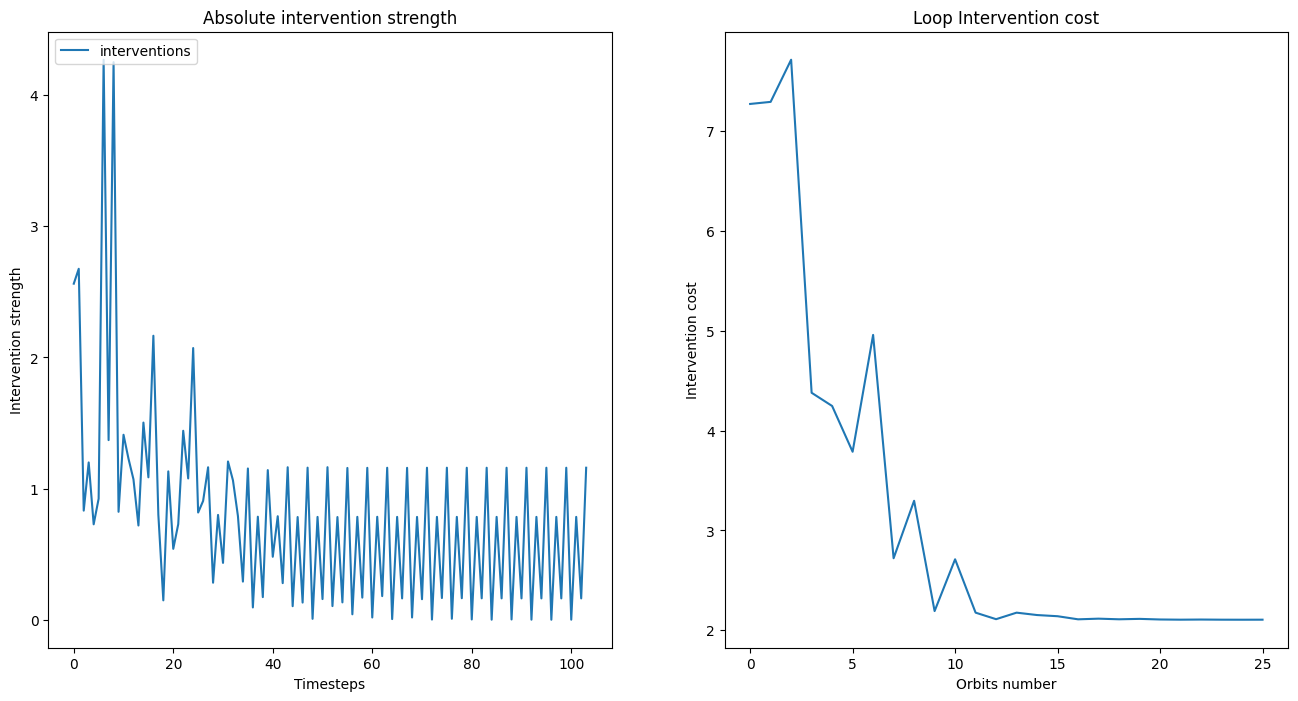

In [ ]:
_, (ax2, ax1) = plt.subplots(1, 2, figsize=(16,8))


ax1.plot(np.abs(np.array(all_ints).reshape((-1,lpr.l))).sum(-1))

ax1.set_xlabel("Orbits number")
ax1.set_title("Loop Intervention cost")
ax1.set_ylabel("Intervention cost")

ax2.plot(np.abs(all_ints), label="interventions")
ax2.legend(loc="upper left")

ax2.set_xlabel("Timesteps")
ax2.set_ylabel("Intervention strength")
ax2.set_title("Absolute intervention strength")
;

''

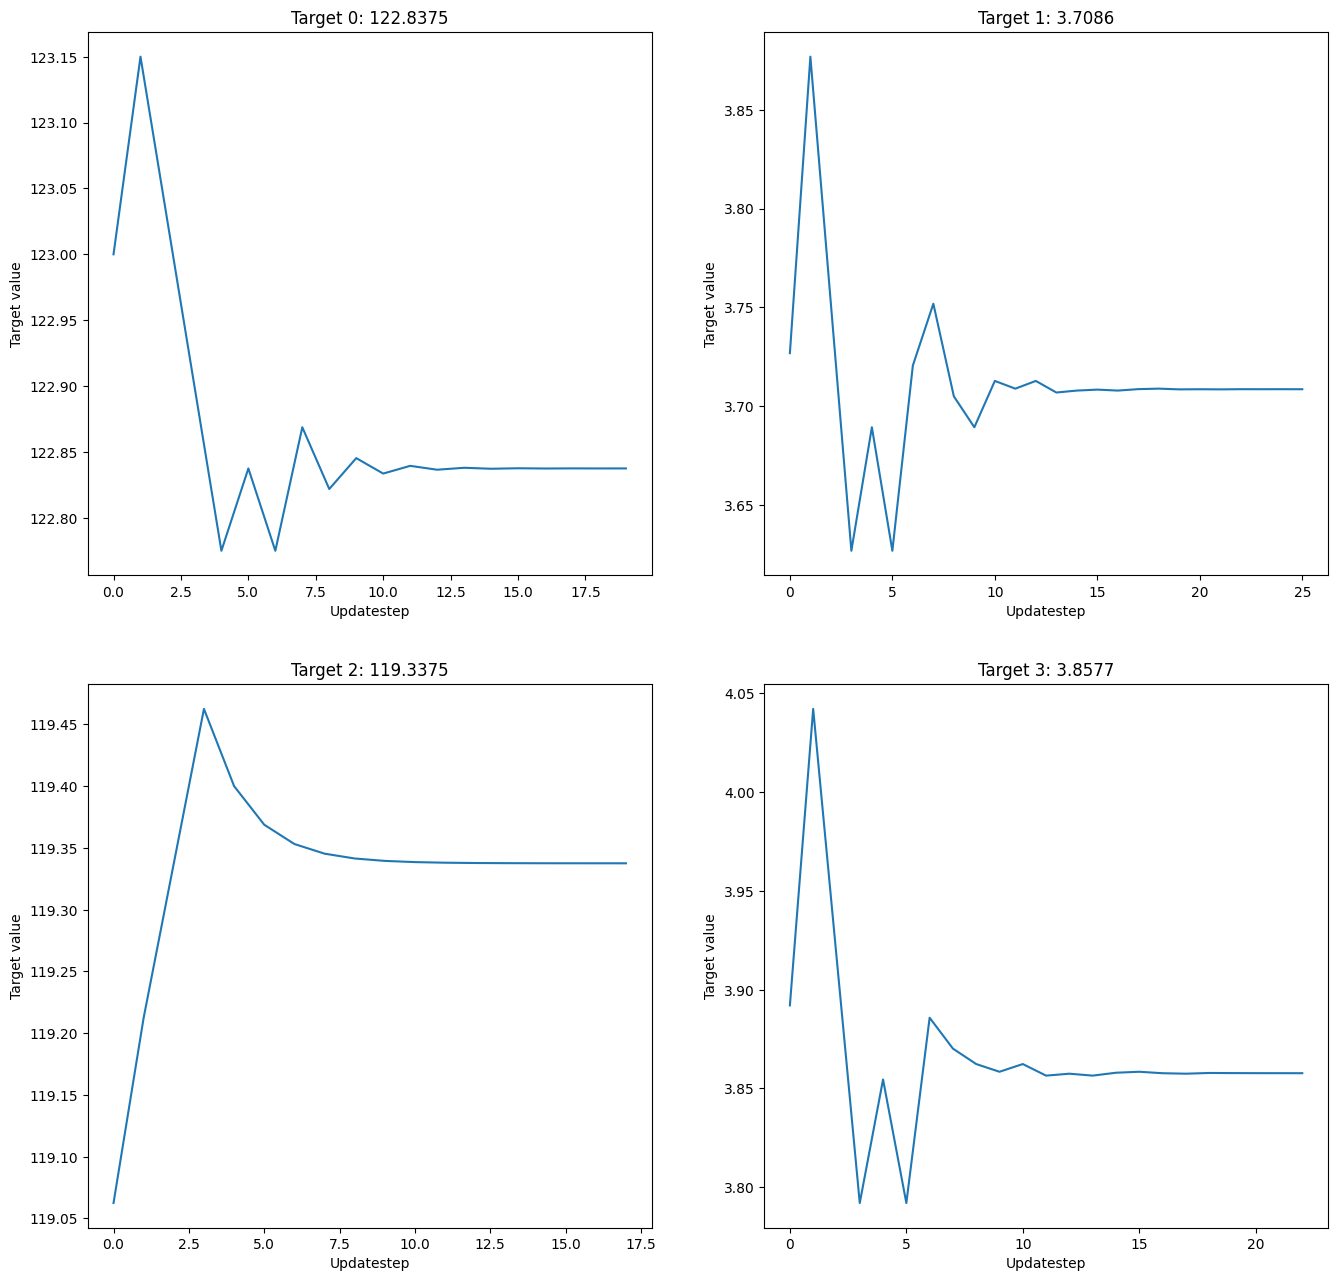

In [ ]:
_, axes = plt.subplots(lpr.l // 2 + 1, 2, figsize=(16, 8 * (lpr.l // 2 + 1)))

for i, ax in enumerate(axes.ravel()):
    if i >= lpr.l:
        ax.set_visible(False)
    else:
        ax.plot(lpr.all_targets[i])
        ax.set_title(f"Target {i}: {lpr.t_vals[i]:.4f}")
        ax.set_xlabel("Updatestep")
        ax.set_ylabel("Target value")
;

In [ ]:

print(np.array(lpr.t_vals))
print(f(np.array(lpr.t_vals)))

[122.83750763   3.70858556 119.33750763   3.85772691]
[  2.54946305 119.33736031   3.07347663 123.0000753 ]


#### Test 2: Ricker with Noise

In [ ]:
lpr2 = LoopStabilizer(gConst, 123, 15, buffer_size=21, max_loop_length=6, starting_m=0.1)

Target node:  98
0 :  [2, 91, 3, 98]
1 :  [2, 92, 3, 98]
2 :  [2, 93, 3, 98]
3 :  [2, 94, 3, 98]
4 :  [2, 95, 3, 98]
Choose loop for stabilization (Number): 4


In [ ]:
%%capture
x=134
all_vals = []
all_ints = []
print("")
i = 0
while not lpr2.found or len(all_vals) % lpr2.l != 0:
    print(i)
    i += 1
    if i >= 4000:
        break
    int_val = lpr2.stabilize(x)
    all_ints.append(int_val)
    all_vals.append(x+int_val)
    print("Current Target: ",lpr2.ints[lpr.int_idx].t)
    print("With Invervention: ", x+int_val)
    x = f(x+int_val)
    x *= 1 + 0.15 * (random.rand()*1.5-0.75)
    print("Next value with noise: ", x)
    print("Result: ", x)
    print("")

''

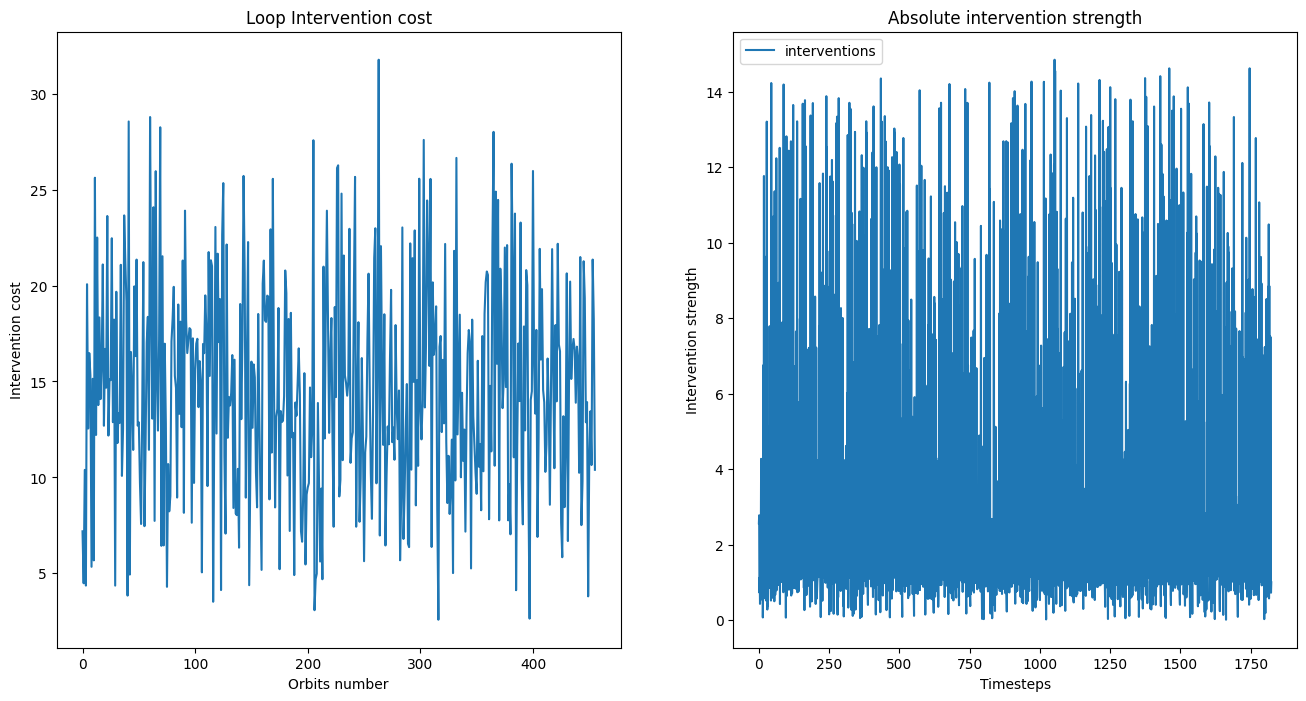

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))


ax1.plot(np.abs(all_ints).reshape((-1,lpr2.l)).sum(-1))

ax1.set_xlabel("Orbits number")
ax1.set_title("Loop Intervention cost")
ax1.set_ylabel("Intervention cost")

ax2.plot(np.abs(all_ints), label="interventions")
ax2.legend(loc="upper left")

ax2.set_xlabel("Timesteps")
ax2.set_ylabel("Intervention strength")
ax2.set_title("Absolute intervention strength")
;

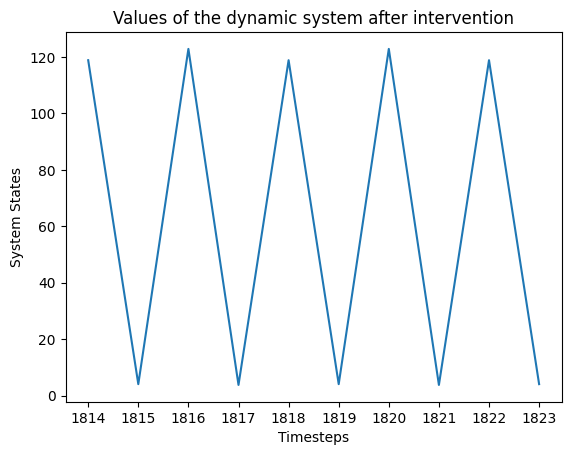

In [ ]:
plt.plot(all_vals[-10:])
plt.title("Values of the dynamic system after intervention")
plt.xlabel("Timesteps")
plt.ylabel("System States")
plt.xticks(np.arange(10), np.arange(len(all_vals))[-10:]);

''

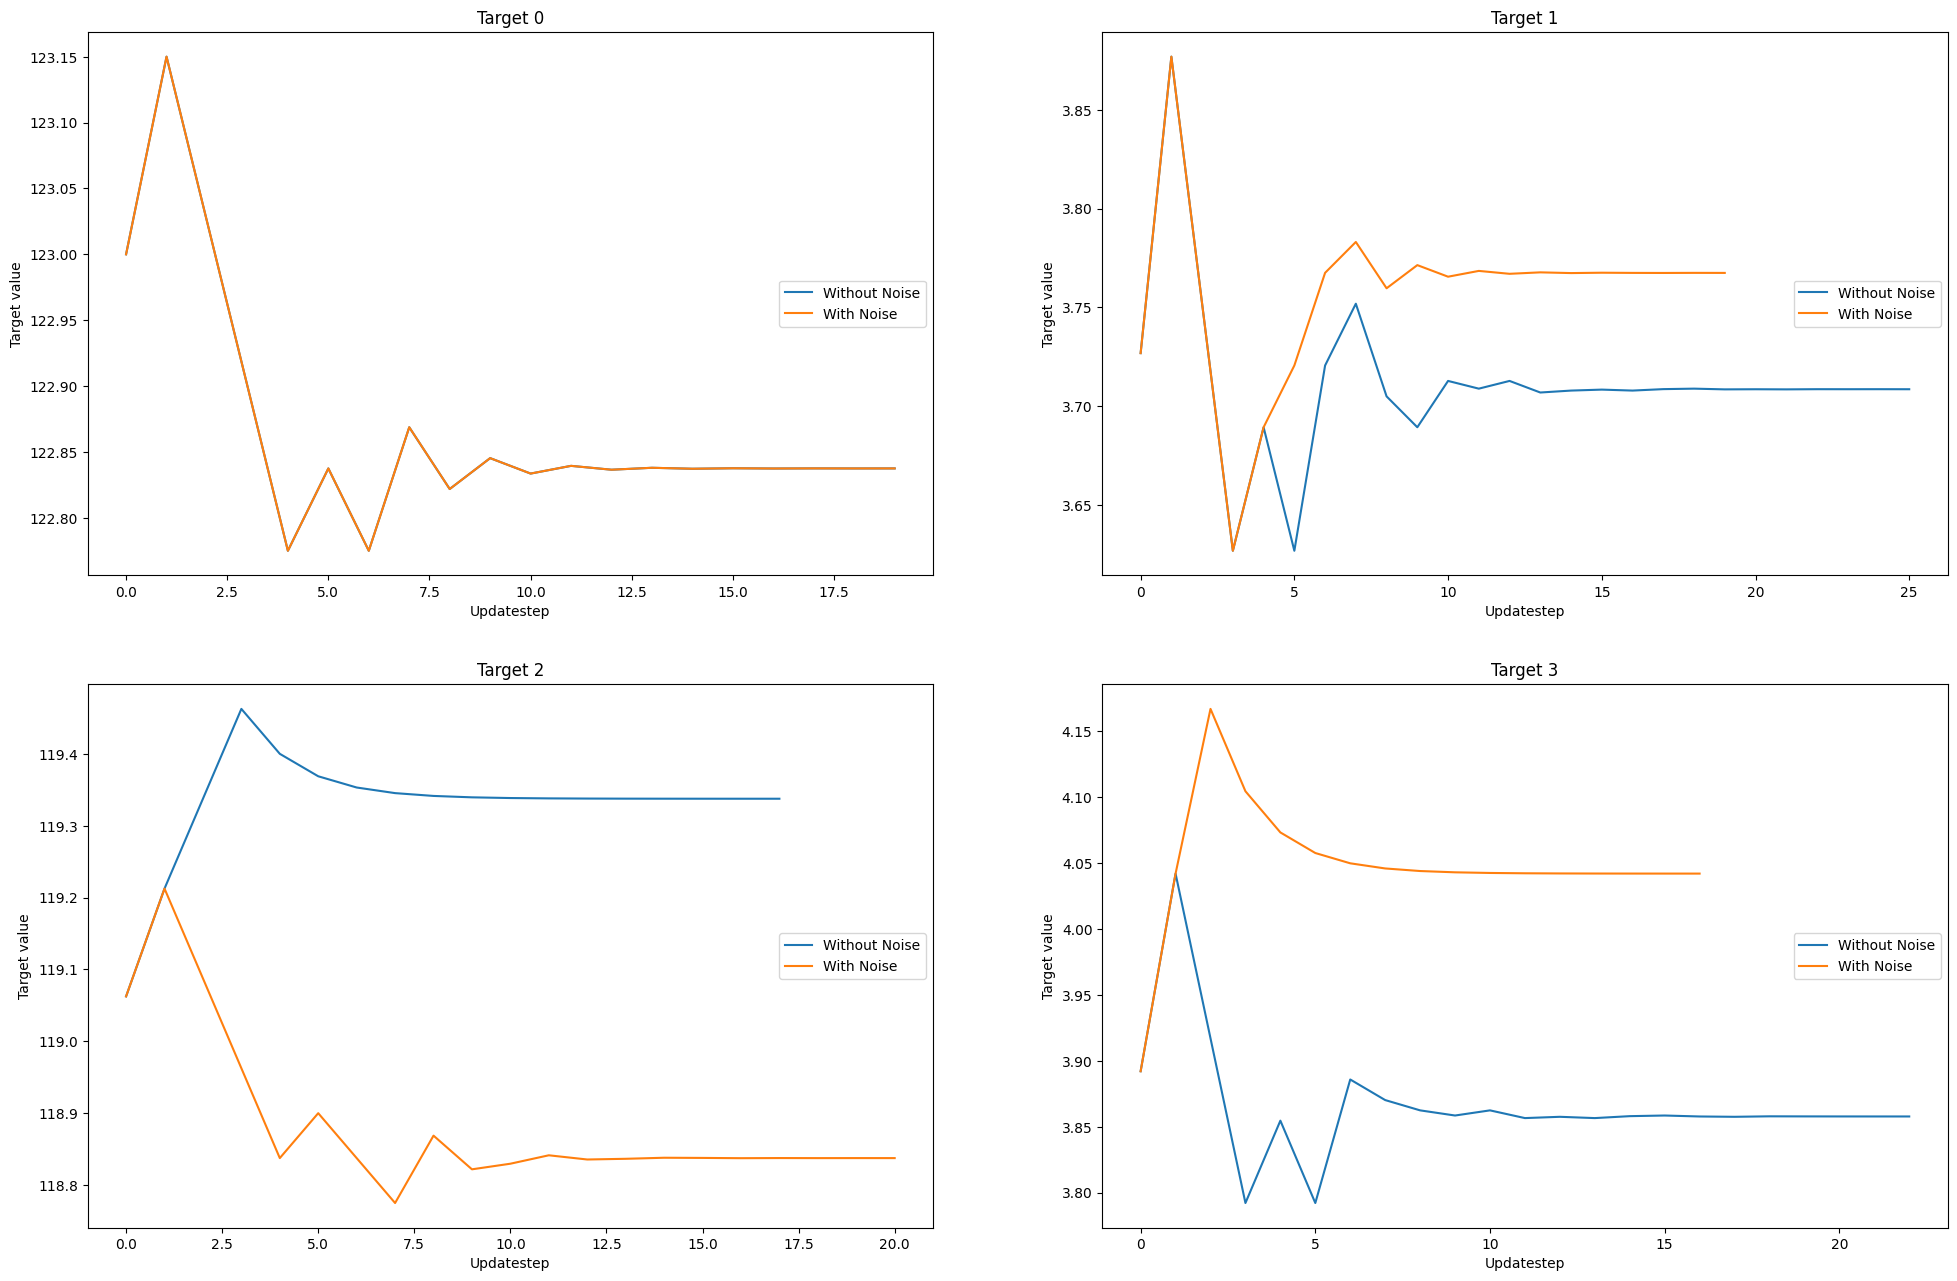

In [ ]:
_, axes = plt.subplots(lpr2.l // 2 + 1, 2, figsize=(24, 8 * (lpr2.l // 2 + 1)))

for i, ax in enumerate(axes.ravel()):
    if i >= lpr2.l:
        ax.set_visible(False)
    else:
        ax.plot(lpr.all_targets[i], label="Without Noise")
        ax.plot(lpr2.all_targets[i], label="With Noise")
        ax.set_title(f"Target {i}")
        ax.legend(loc="center right")
        ax.set_xlabel("Updatestep")
        ax.set_ylabel("Target value")
;

#### Test 3: Logistic without Noise

In [ ]:
data = make_samples(1, 1000, g, g.max_val, noise=0.05)
gConst= GraphConstructor(50, x=data[:-1], y=data[1:], min_val=0, max_val=g.max_val, automatic_padding="max", verbose=False)

In [ ]:
lpr = LoopStabilizer(gConst, 0.28, 0.05, buffer_size=1, max_loop_length=6, starting_m=0.1)

Target node:  14
0 :  [3, 14, 40, 28, 49]
1 :  [3, 14, 41, 25, 49]
2 :  [3, 14, 41, 26, 49]
3 :  [3, 14, 41, 27, 49]
4 :  [3, 14, 41, 28, 49]
5 :  [3, 14, 42, 22, 49]
6 :  [3, 14, 42, 23, 49]
7 :  [3, 14, 42, 24, 49]
8 :  [3, 14, 42, 25, 49]
9 :  [4, 14, 40, 28, 48]
10 :  [4, 14, 40, 28, 49]
11 :  [4, 14, 40, 29, 48]
12 :  [4, 14, 40, 30, 48]
13 :  [4, 14, 41, 25, 49]
14 :  [4, 14, 41, 26, 49]
15 :  [4, 14, 41, 27, 49]
16 :  [4, 14, 41, 28, 48]
17 :  [4, 14, 41, 28, 49]
18 :  [4, 14, 42, 22, 49]
19 :  [4, 14, 42, 23, 49]
20 :  [4, 14, 42, 24, 49]
21 :  [4, 14, 42, 25, 49]
Choose loop for stabilization (Number): 9


In [ ]:
%%capture
x=0.94
all_vals = []
all_ints = []
print("")
i = 0
while not lpr.found or len(all_vals) % lpr.l != 0:
    print(i)
    i += 1
    if i >= 601:
        break
    int_val = lpr.stabilize(x)
    all_ints.append(int_val)
    all_vals.append(x+int_val)
    print("Current Target: ",lpr.ints[lpr.int_idx].t)
    print("With Invervention: ", x+int_val)
    x = g(x+int_val)
    print("Result: ", x)
    print("")

''

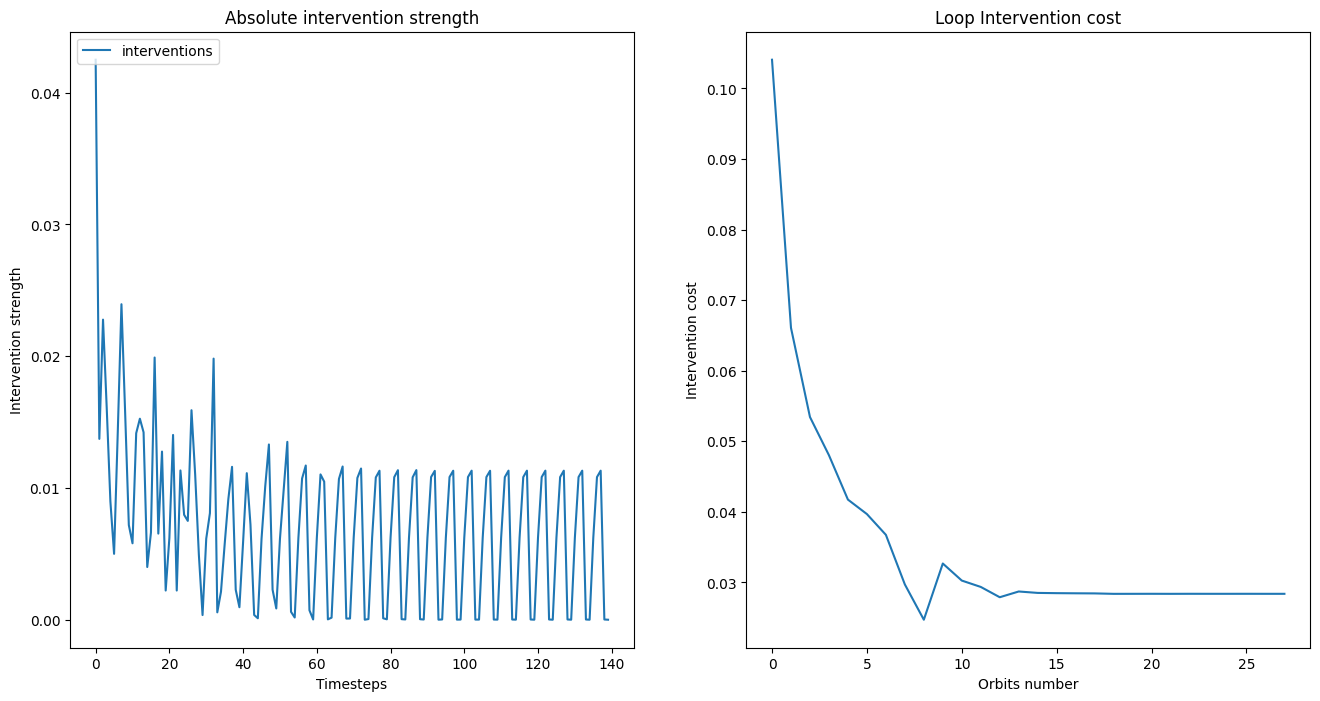

In [ ]:
_, (ax2, ax1) = plt.subplots(1, 2, figsize=(16,8))


ax1.plot(np.abs(np.array(all_ints).reshape((-1,lpr.l))).sum(-1))

ax1.set_xlabel("Orbits number")
ax1.set_title("Loop Intervention cost")
ax1.set_ylabel("Intervention cost")

ax2.plot(np.abs(all_ints), label="interventions")
ax2.legend(loc="upper left")

ax2.set_xlabel("Timesteps")
ax2.set_ylabel("Intervention strength")
ax2.set_title("Absolute intervention strength")
;

''

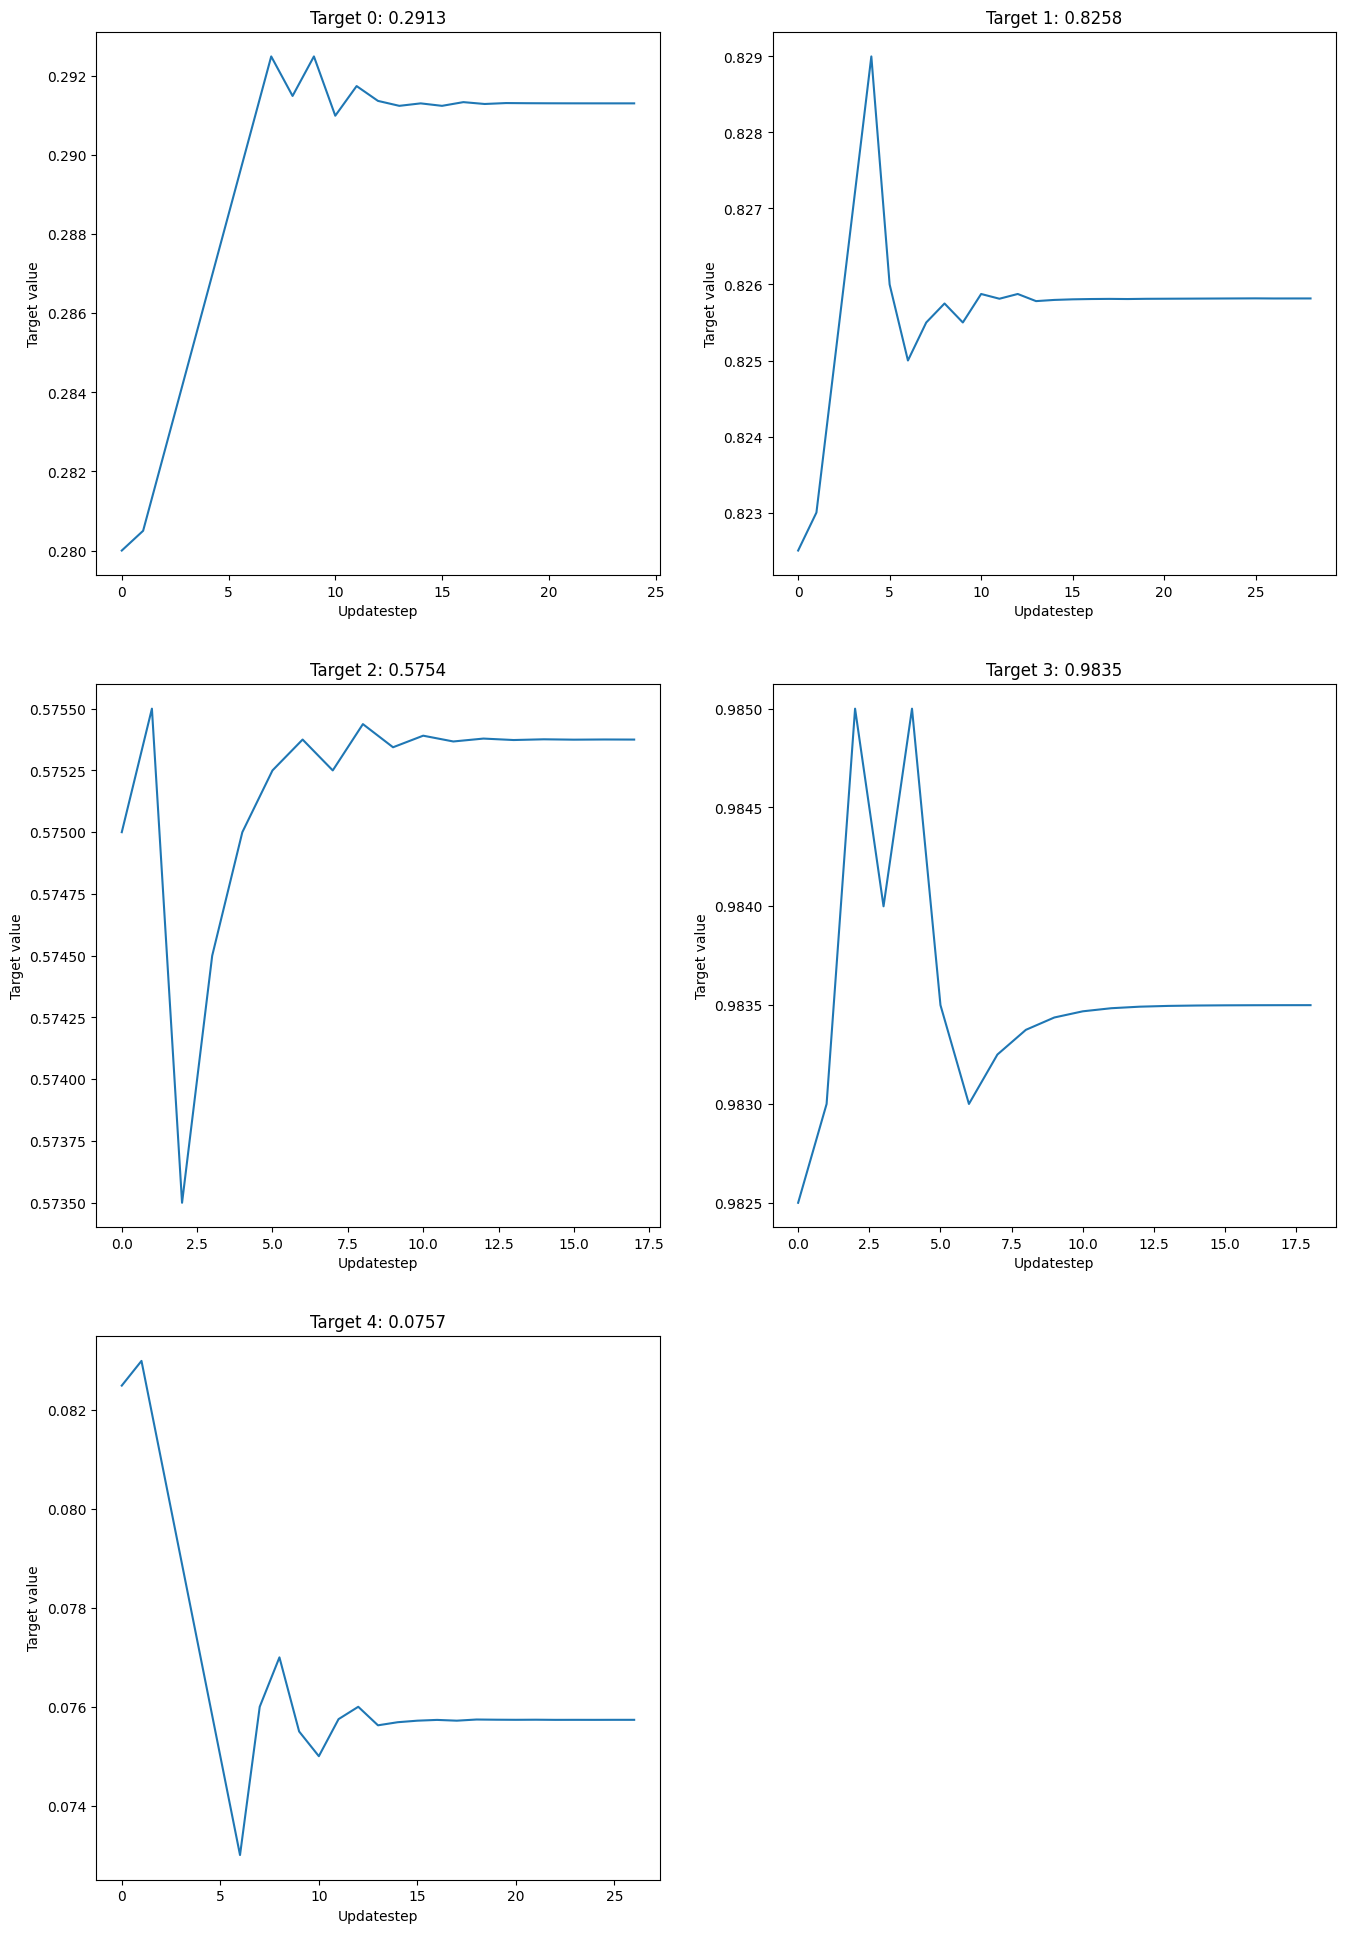

In [ ]:
_, axes = plt.subplots(lpr.l // 2 + 1, 2, figsize=(16, 8 * (lpr.l // 2 + 1)))

for i, ax in enumerate(axes.ravel()):
    if i >= lpr.l:
        ax.set_visible(False)
    else:
        ax.plot(lpr.all_targets[i])
        ax.set_title(f"Target {i}: {lpr.t_vals[i]:.4f}")
        ax.set_xlabel("Updatestep")
        ax.set_ylabel("Target value")
;

#### Test 4: Logistic with Noise

In [ ]:
lpr2 = LoopStabilizer(gConst, 0.28, 0.05, buffer_size=21, max_loop_length=6, starting_m=0.1)

Target node:  14
0 :  [3, 14, 40, 28, 49]
1 :  [3, 14, 41, 25, 49]
2 :  [3, 14, 41, 26, 49]
3 :  [3, 14, 41, 27, 49]
4 :  [3, 14, 41, 28, 49]
5 :  [3, 14, 42, 22, 49]
6 :  [3, 14, 42, 23, 49]
7 :  [3, 14, 42, 24, 49]
8 :  [3, 14, 42, 25, 49]
9 :  [4, 14, 40, 28, 48]
10 :  [4, 14, 40, 28, 49]
11 :  [4, 14, 40, 29, 48]
12 :  [4, 14, 40, 30, 48]
13 :  [4, 14, 41, 25, 49]
14 :  [4, 14, 41, 26, 49]
15 :  [4, 14, 41, 27, 49]
16 :  [4, 14, 41, 28, 48]
17 :  [4, 14, 41, 28, 49]
18 :  [4, 14, 42, 22, 49]
19 :  [4, 14, 42, 23, 49]
20 :  [4, 14, 42, 24, 49]
21 :  [4, 14, 42, 25, 49]
Choose loop for stabilization (Number): 9


In [ ]:
%%capture
x=0.94
all_vals = []
all_ints = []
print("")
i = 0
while not lpr2.found or len(all_vals) % lpr2.l != 0:
    print(i)
    i += 1
    if i >= 4000:
        break
    int_val = lpr2.stabilize(x)
    all_ints.append(int_val)
    all_vals.append(x+int_val)
    print("Current Target: ",lpr2.ints[lpr.int_idx].t)
    print("With Invervention: ", x+int_val)
    x = g(x+int_val)
    x *= 1 + 0.05 * (random.rand()*1.5-0.75)
    print("Next value with noise: ", x)
    print("Result: ", x)
    print("")

''

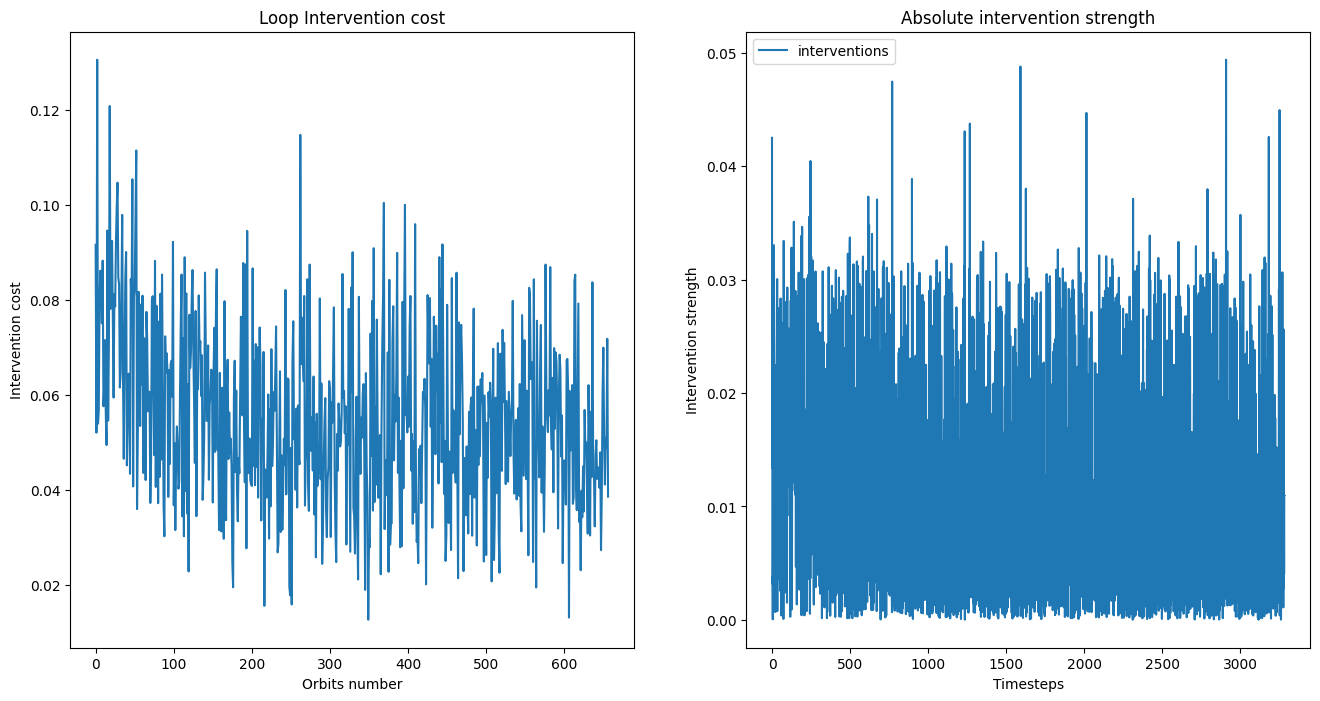

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))


ax1.plot(np.abs(all_ints).reshape((-1,lpr2.l)).sum(-1))

ax1.set_xlabel("Orbits number")
ax1.set_title("Loop Intervention cost")
ax1.set_ylabel("Intervention cost")

ax2.plot(np.abs(all_ints), label="interventions")
ax2.legend(loc="upper left")

ax2.set_xlabel("Timesteps")
ax2.set_ylabel("Intervention strength")
ax2.set_title("Absolute intervention strength")
;

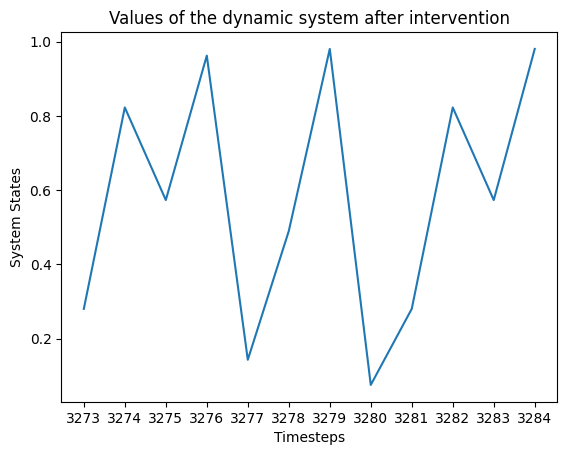

In [ ]:
plt.plot(all_vals[-12:])
plt.title("Values of the dynamic system after intervention")
plt.xlabel("Timesteps")
plt.ylabel("System States")
plt.xticks(np.arange(12), np.arange(len(all_vals))[-12:]);

''

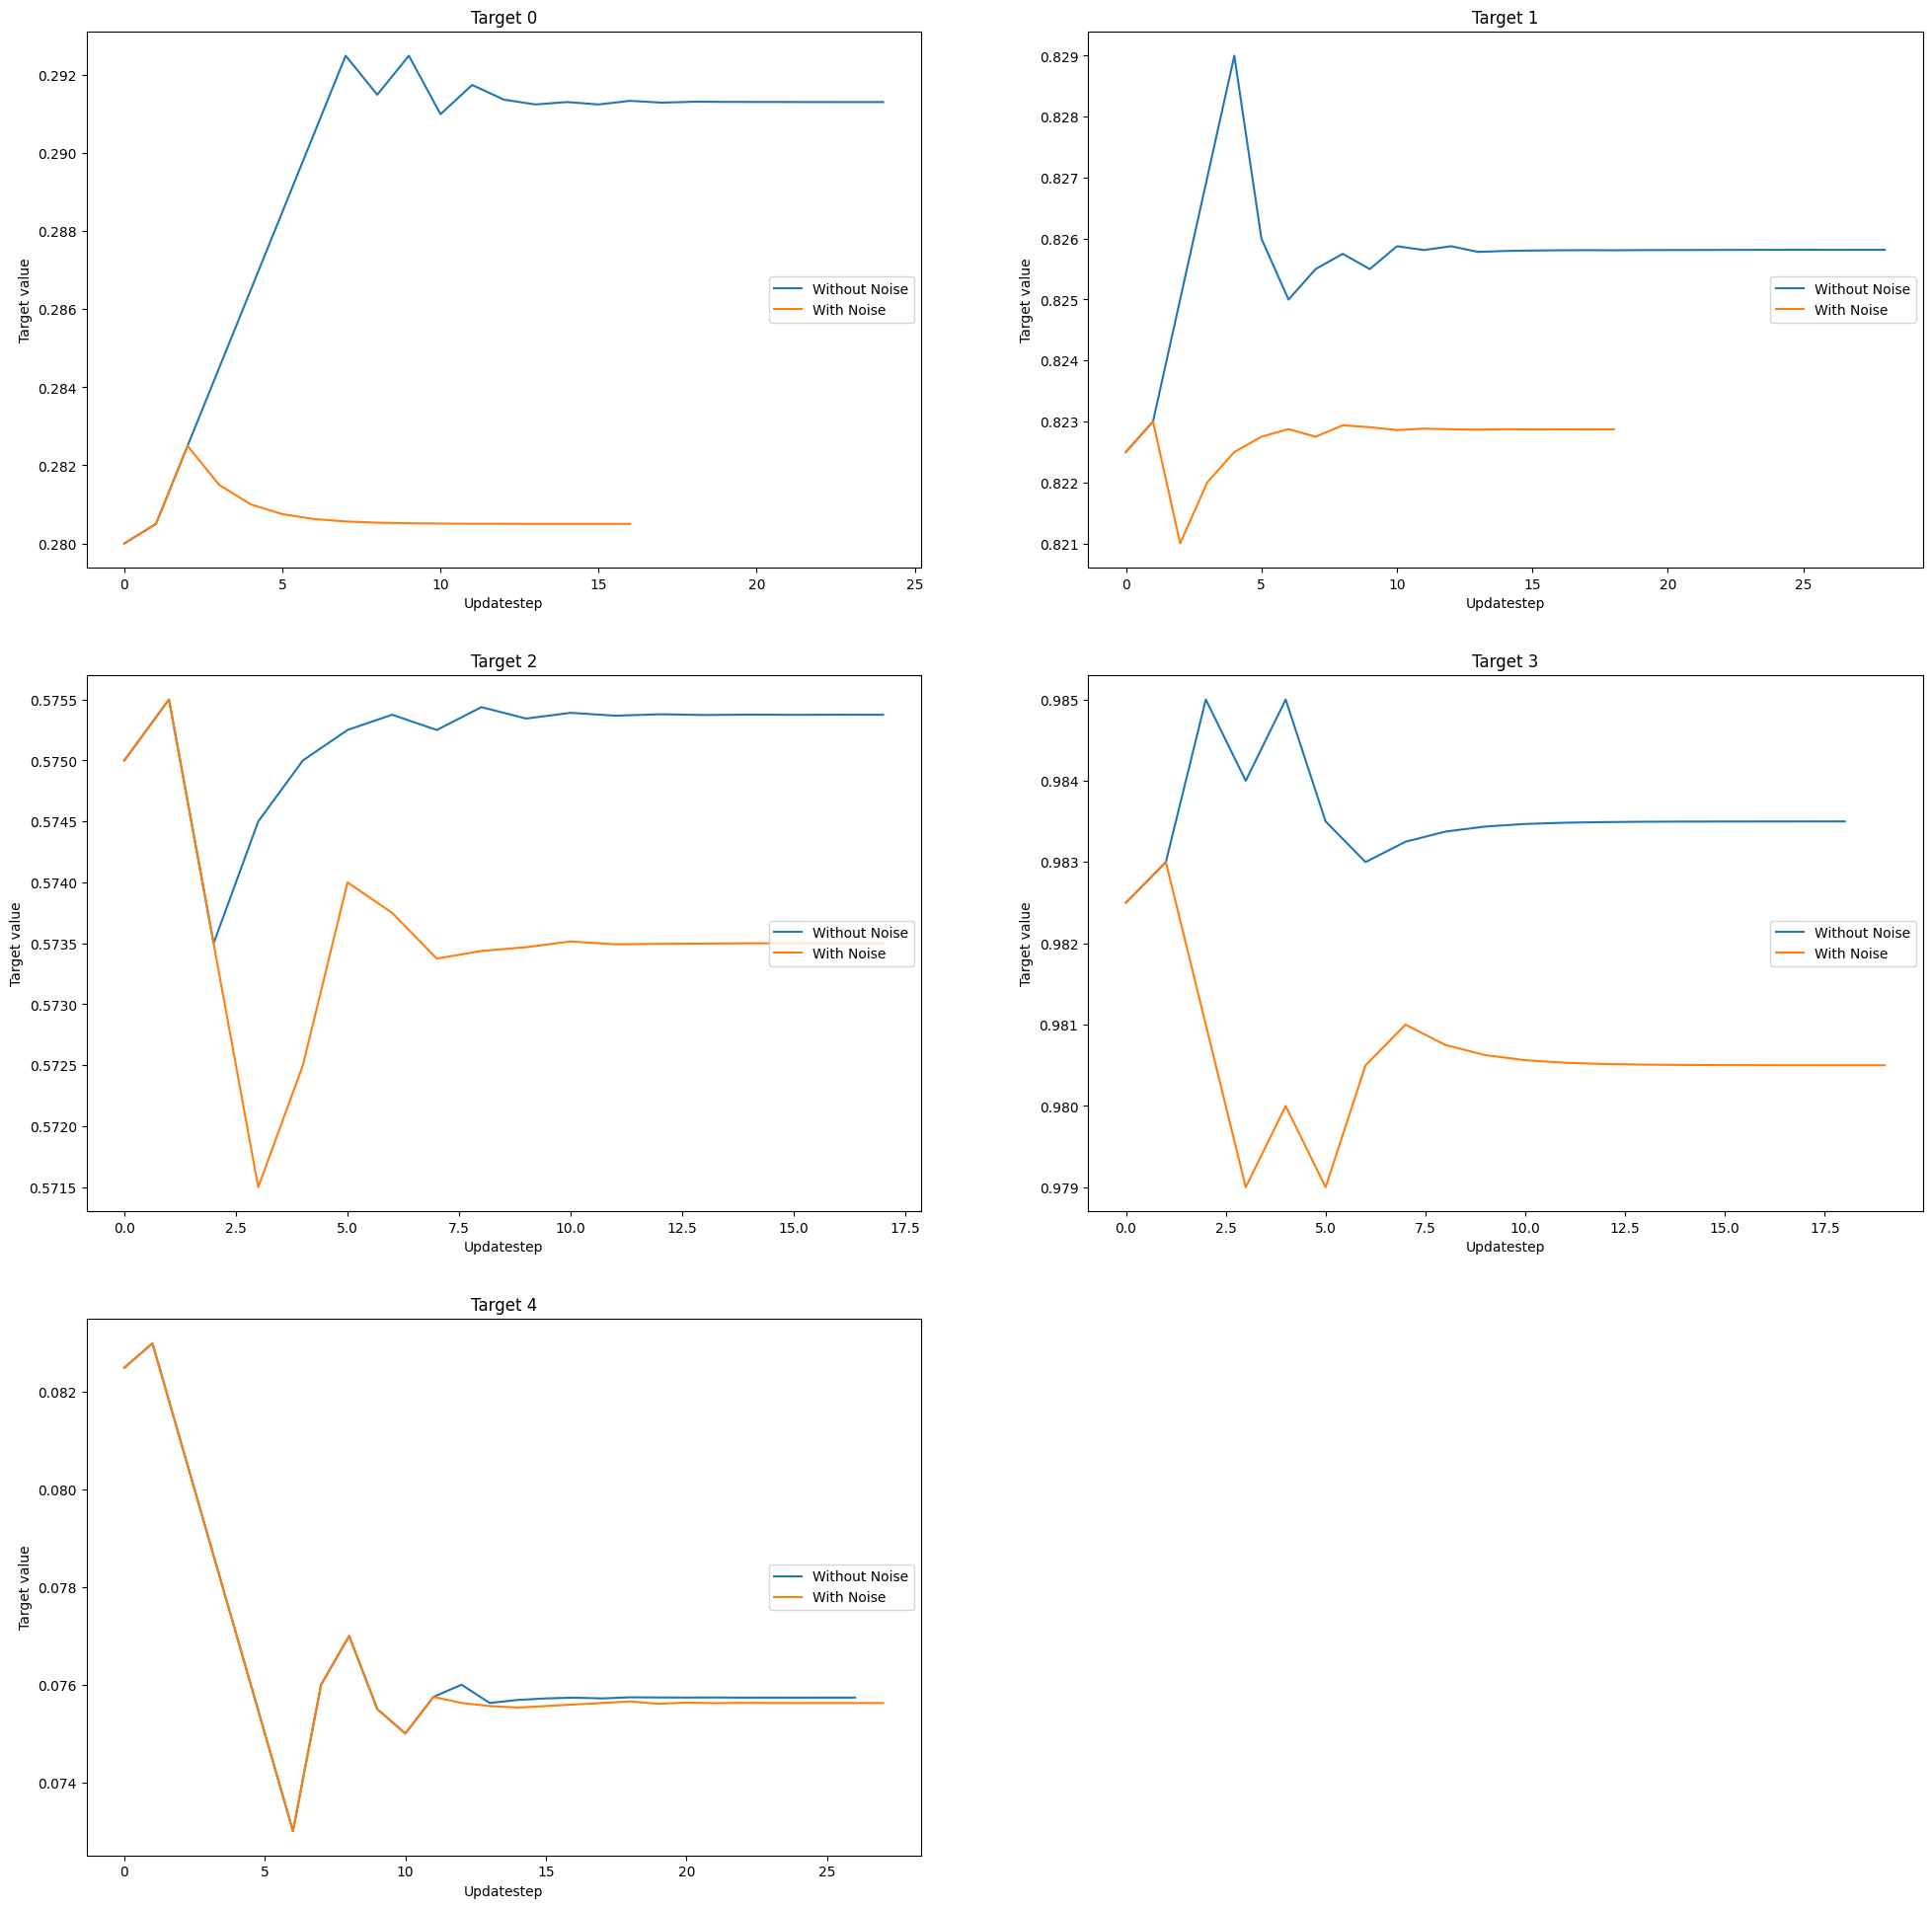

In [ ]:
_, axes = plt.subplots(lpr2.l // 2 + 1, 2, figsize=(24, 8 * (lpr2.l // 2 + 1)))

for i, ax in enumerate(axes.ravel()):
    if i >= lpr2.l:
        ax.set_visible(False)
    else:
        ax.plot(lpr.all_targets[i], label="Without Noise")
        ax.plot(lpr2.all_targets[i], label="With Noise")
        ax.set_title(f"Target {i}")
        ax.legend(loc="center right")
        ax.set_xlabel("Updatestep")
        ax.set_ylabel("Target value")
;

#### Test 5: Low sample size without Noise

In [ ]:
f = RickerFunction(K=58.34)
data = make_samples(1, 30, f, f.max_val, noise=0.1)
gConst= GraphConstructor(200, x=data[:-1], y=data[1:], min_val=0, max_val=250, automatic_padding="max", verbose=False)

In [ ]:
lpr = LoopStabilizer(gConst, 123, 15, buffer_size=1, max_loop_length=6, starting_m=0.1)

Target node:  98
0 :  [1, 50, 32, 98, 3, 111]
1 :  [1, 50, 32, 98, 3, 112]
2 :  [98, 3]
Choose loop for stabilization (Number): 2


In [ ]:
%%capture
x=134
all_vals = []
all_ints = []
print("")
i = 0
while not lpr.found or len(all_vals) % lpr.l != 0:
    print(i)
    i += 1
    if i >= 601:
        break
    int_val = lpr.stabilize(x)
    all_ints.append(int_val)
    all_vals.append(x+int_val)
    print("Current Target: ",lpr.ints[lpr.int_idx].t)
    print("With Invervention: ", x+int_val)
    x = f(x+int_val)
    print("Result: ", x)
    print("")

''

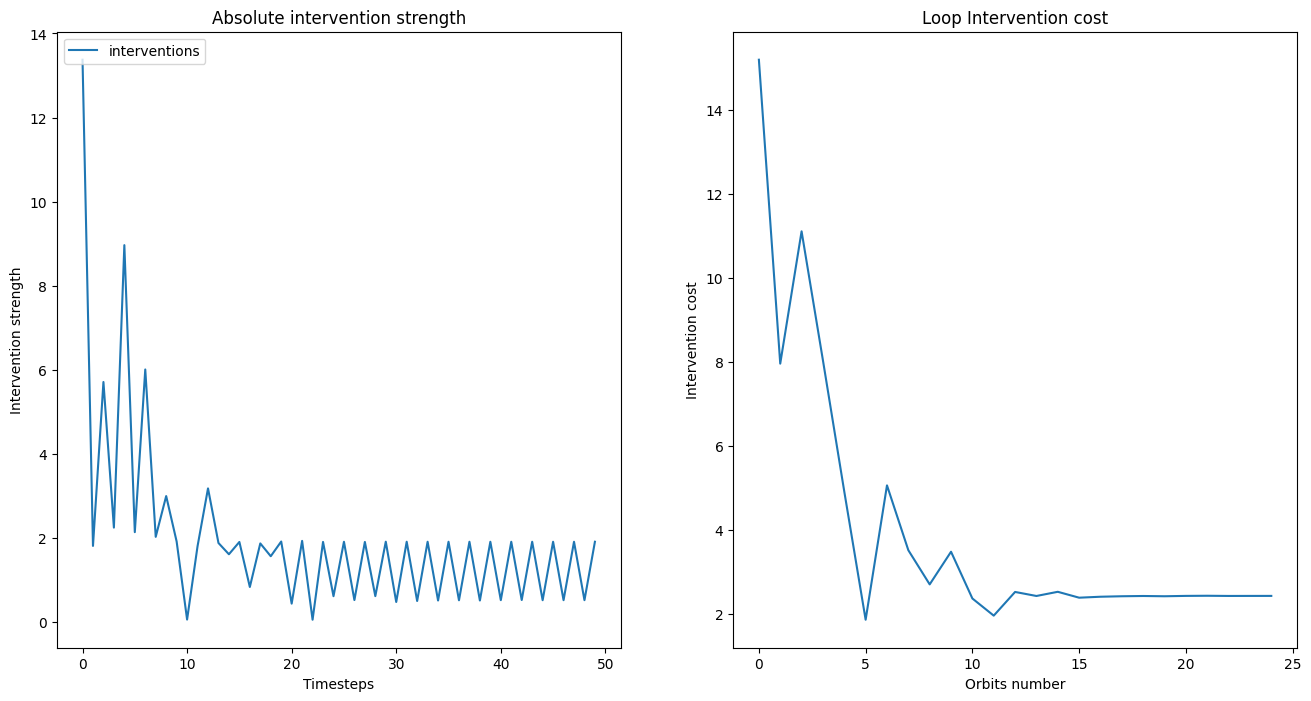

In [ ]:
_, (ax2, ax1) = plt.subplots(1, 2, figsize=(16,8))


ax1.plot(np.abs(np.array(all_ints).reshape((-1,lpr.l))).sum(-1))

ax1.set_xlabel("Orbits number")
ax1.set_title("Loop Intervention cost")
ax1.set_ylabel("Intervention cost")

ax2.plot(np.abs(all_ints), label="interventions")
ax2.legend(loc="upper left")

ax2.set_xlabel("Timesteps")
ax2.set_ylabel("Intervention strength")
ax2.set_title("Absolute intervention strength")
;

''

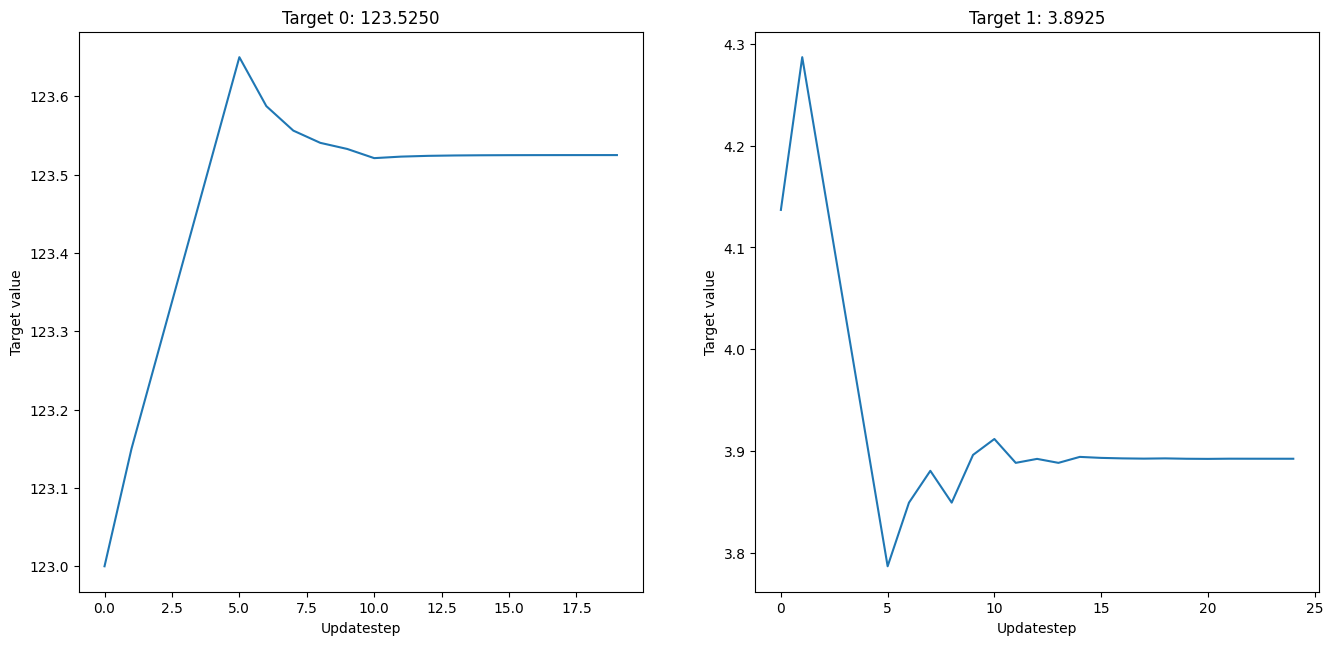

In [ ]:
_, axes = plt.subplots(lpr.l // 2 + 1, 2, figsize=(16, 8 * (lpr.l // 2 + 1)))

for i, ax in enumerate(axes.ravel()):
    if i >= lpr.l:
        ax.set_visible(False)
    else:
        ax.plot(lpr.all_targets[i])
        ax.set_title(f"Target {i}: {lpr.t_vals[i]:.4f}")
        ax.set_xlabel("Updatestep")
        ax.set_ylabel("Target value")
;

In [ ]:
print(np.array(lpr.t_vals))
print(f(np.array(lpr.t_vals)))

[123.52499237   3.89250321]
[  1.97847239 123.00004796]


#### Test 6: Low Sample size with Noise

In [ ]:
lpr2 = LoopStabilizer(gConst, 123, 15, buffer_size=21, max_loop_length=6, starting_m=0.1)

Target node:  98
0 :  [1, 50, 32, 98, 3, 111]
1 :  [1, 50, 32, 98, 3, 112]
2 :  [98, 3]
Choose loop for stabilization (Number): 2


In [ ]:
%%capture
x=134
all_vals = []
all_ints = []
print("")
i = 0
while not lpr2.found or len(all_vals) % lpr2.l != 0:
    print(i)
    i += 1
    if i >= 4000:
        break
    int_val = lpr2.stabilize(x)
    all_ints.append(int_val)
    all_vals.append(x+int_val)
    print("Current Target: ",lpr2.ints[lpr.int_idx].t)
    print("With Invervention: ", x+int_val)
    x = f(x+int_val)
    x *= 1 + 0.15 * (random.rand()*1.5-0.75)
    print("Next value with noise: ", x)
    print("Result: ", x)
    print("")

''

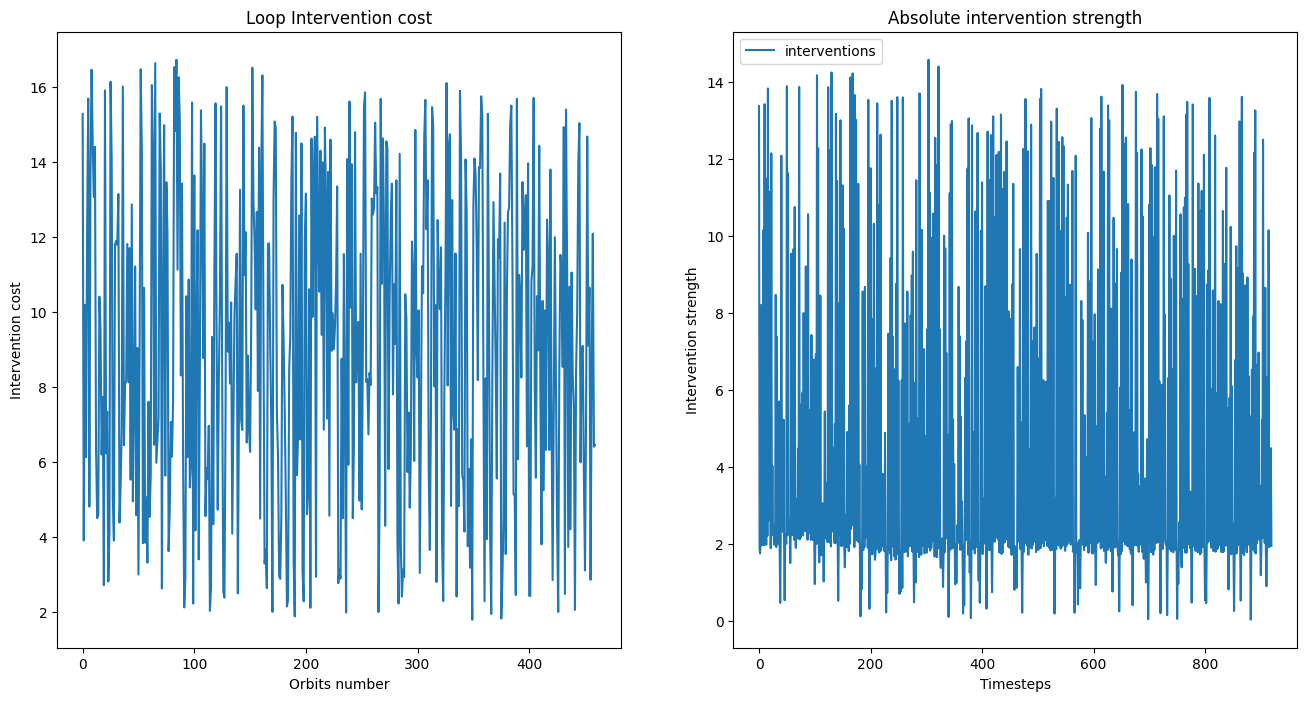

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))


ax1.plot(np.abs(all_ints).reshape((-1,lpr2.l)).sum(-1))

ax1.set_xlabel("Orbits number")
ax1.set_title("Loop Intervention cost")
ax1.set_ylabel("Intervention cost")

ax2.plot(np.abs(all_ints), label="interventions")
ax2.legend(loc="upper left")

ax2.set_xlabel("Timesteps")
ax2.set_ylabel("Intervention strength")
ax2.set_title("Absolute intervention strength")
;

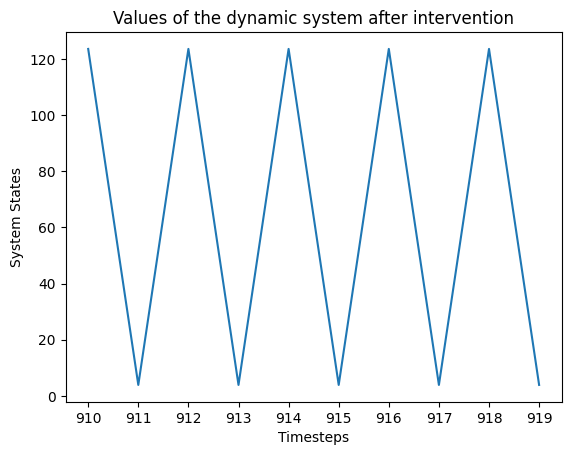

In [ ]:
plt.plot(all_vals[-10:])
plt.title("Values of the dynamic system after intervention")
plt.xlabel("Timesteps")
plt.ylabel("System States")
plt.xticks(np.arange(10), np.arange(len(all_vals))[-10:]);

''

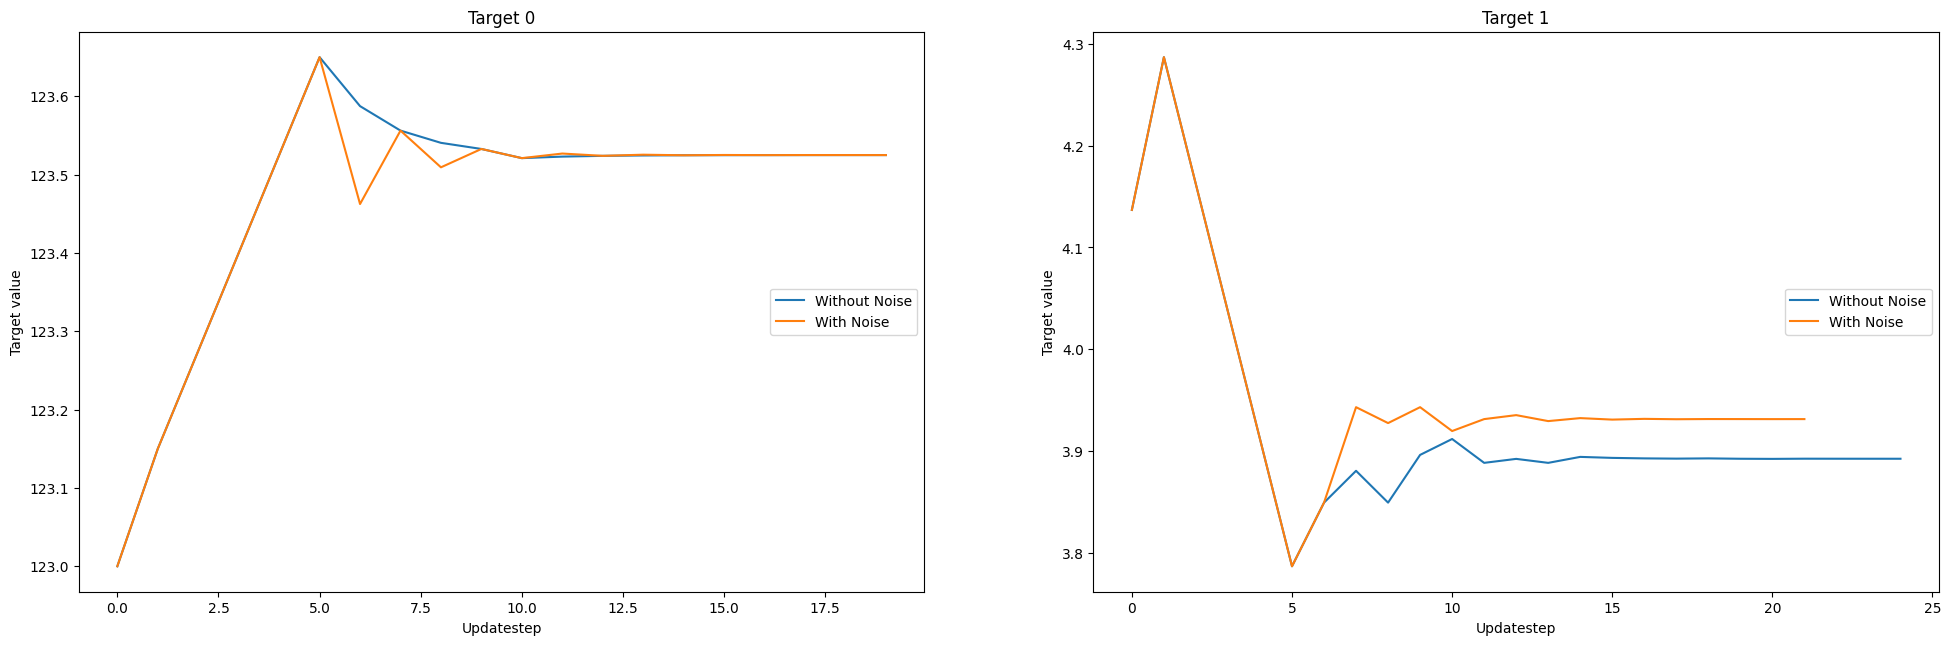

In [ ]:
_, axes = plt.subplots(lpr2.l // 2 + 1, 2, figsize=(24, 8 * (lpr2.l // 2 + 1)))

for i, ax in enumerate(axes.ravel()):
    if i >= lpr2.l:
        ax.set_visible(False)
    else:
        ax.plot(lpr.all_targets[i], label="Without Noise")
        ax.plot(lpr2.all_targets[i], label="With Noise")
        ax.set_title(f"Target {i}")
        ax.legend(loc="center right")
        ax.set_xlabel("Updatestep")
        ax.set_ylabel("Target value")
;